In [5]:
PATH_ = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"

In [6]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_val_score
import os 
from matplotlib import pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import seaborn as sb
import pandas as pd
import numpy as np
from scipy import stats
import sys
sys.path.append('C:\\Users\\ICN_admin\\Documents\\icn\\icn_stats\\')
import icn_permutation_test

In [7]:
def append_time_dim(arr, y_, time_stamps):
    """
    apply added time dimension for the data array and label given time_stamps (with downsample_rate=100) in 100ms / need to check with 1375Hz
    """
    time_arr = np.zeros([arr.shape[0]-time_stamps, int(time_stamps*arr.shape[1])])
    for time_idx, time_ in enumerate(np.arange(time_stamps, arr.shape[0])):
        for time_point in range(time_stamps):
            time_arr[time_idx, time_point*arr.shape[1]:(time_point+1)*arr.shape[1]] = arr[time_-time_point,:]
    return time_arr, y_[time_stamps:]

In [240]:
def evalerror(preds, dtrain):
        """
        Custom defined r^2 evaluation function
        """
        labels = dtrain.get_label()
        # return a pair metric_name, result. The metric name must not contain a
        # colon (:) or a space since preds are margin(before logistic
        # transformation, cutoff at 0)

        r2 = metrics.r2_score(labels, preds)

        if r2 < 0:
            r2 = 0

        return 'r2', r2
    
def get_sorted_score(importance_type="gain"):
    # sort feature importances, since the dict is not sorted! 
    
    dict_fi = model.get_score(importance_type=importance_type)
    
    l_ = []
    for i in list(dict_fi.keys()):
        l_.append(int(i[1:]))
    
    return np.array(list(dict_fi.values()))[np.argsort(l_)]

In [242]:
model = xgb.XGBRegressor()
df = pd.DataFrame()
for f in range(len(os.listdir(PATH_))):
    sub_ = os.listdir(PATH_)[f][4:7]
    if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
        continue
    print(sub_)
    with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
        run_ = pickle.load(handle)
        print(run_["ch_names"])
        if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
            continue
        print("PROCESS")
        for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
            if "ECOG" in ch_:
                loc = "ECOG"
            else:
                loc = "STN"
            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], label, time_stamps=5)
                #res_ = np.mean(cross_val_score(model, X, y, cv=3, scoring="r2", n_jobs=59))
                #res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X, label=y), 
                #              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                # REPLACE this CV by the 3 fold CV: 
                r2_here = []
                importances_gain = []
                importances_weight = []
                importances_cover = []
                importances_total_gain = []
                importances_total_cover = []
                for f in range(3):
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
                    dict_= xgb.XGBRegressor().get_params()
                    #dict_["eval_metric"]:evalerror
    
                    model = xgb.train(
                        params=dict_,
                        dtrain=xgb.DMatrix(X_train, label=y_train),
                        num_boost_round=50,
                        evals=[(xgb.DMatrix(X_val, label=y_val), "Val")],
                        early_stopping_rounds=10, 
                        #feval = evalerror, 
                        maximize = False
                    )
                    
                    #xgb_trained = xgb.XGBRegressor().fit(X_train, y_train, eval_metric =evalerror)
                    r2_ = metrics.r2_score(y_test, model.predict(xgb.DMatrix(X_test)))
                    
                    if r2_ < 0:
                        r2_here.append(0)
                    else:
                        r2_here.append(r2_)
                    
                    importances_weight.append(get_sorted_score(importance_type="weight"))
                    importances_gain.append(get_sorted_score(importance_type="gain"))
                    importances_cover.append(get_sorted_score(importance_type="cover"))
                    importances_total_gain.append(get_sorted_score(importance_type="total_gain"))
                    importances_total_cover.append(get_sorted_score(importance_type="total_cover"))
                    
                print(np.mean(r2_here))
                if "LEFT" in ch_:
                    hem = "LEFT"
                else:
                    hem = "RIGHT"
                df = df.append({
                    "r2": np.mean(r2_here),
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": loc,
                    "lat": lat,
                    "hem" : hem, 
                    "importances_weight" : np.mean(np.array(importances_weight), axis=0), 
                    "importances_gain" : np.mean(np.array(importances_gain), axis=0), 
                    "importances_cover" : np.mean(np.array(importances_cover), axis=0), 
                    "importances_total_gain" : np.mean(np.array(importances_total_gain), axis=0), 
                    "importances_total_cover" : np.mean(np.array(importances_total_cover), axis=0) 
                }, ignore_index=True)
            

000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
[0]	Val-rmse:0.37264
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29950
[2]	Val-rmse:0.25698
[3]	Val-rmse:0.23547
[4]	Val-rmse:0.22314
[5]	Val-rmse:0.21788
[6]	Val-rmse:0.21398
[7]	Val-rmse:0.21246
[8]	Val-rmse:0.21198
[9]	Val-rmse:0.21131
[10]	Val-rmse:0.21052
[11]	Val-rmse:0.20977
[12]	Val-rmse:0.20865
[13]	Val-rmse:0.21043
[14]	Val-rmse:0.21114
[15]	Val-rmse:0.21085
[16]	Val-rmse:0.20788
[17]	Val-rmse:0.20751
[

[1]	Val-rmse:0.26528
[2]	Val-rmse:0.20555
[3]	Val-rmse:0.16908
[4]	Val-rmse:0.14965
[5]	Val-rmse:0.13612
[6]	Val-rmse:0.12911
[7]	Val-rmse:0.12522
[8]	Val-rmse:0.12300
[9]	Val-rmse:0.12333
[10]	Val-rmse:0.12419
[11]	Val-rmse:0.12413
[12]	Val-rmse:0.12380
[13]	Val-rmse:0.12413
[14]	Val-rmse:0.12409
[15]	Val-rmse:0.12418
[16]	Val-rmse:0.12427
[17]	Val-rmse:0.12406
[18]	Val-rmse:0.12404
Stopping. Best iteration:
[8]	Val-rmse:0.12300

[0]	Val-rmse:0.35383
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26528
[2]	Val-rmse:0.20555
[3]	Val-rmse:0.16908
[4]	Val-rmse:0.14965
[5]	Val-rmse:0.13612
[6]	Val-rmse:0.12911
[7]	Val-rmse:0.12522
[8]	Val-rmse:0.12300
[9]	Val-rmse:0.12333
[10]	Val-rmse:0.12419
[11]	Val-rmse:0.12413
[12]	Val-rmse:0.12380
[13]	Val-rmse:0.12413
[14]	Val-rmse:0.12409
[15]	Val-rmse:0.12418
[16]	Val-rmse:0.12427
[17]	Val-rmse:0.12406
[18]	Val-rmse:0.12404
Stopping. Best iteration:
[8]	Val-rmse:0.12300

0.7906086834792627
[0]	Val-rmse:0.37436
Will train un

[6]	Val-rmse:0.13612
[7]	Val-rmse:0.13306
[8]	Val-rmse:0.13146
[9]	Val-rmse:0.13112
[10]	Val-rmse:0.12998
[11]	Val-rmse:0.12950
[12]	Val-rmse:0.12968
[13]	Val-rmse:0.12972
[14]	Val-rmse:0.12965
[15]	Val-rmse:0.12990
[16]	Val-rmse:0.12958
[17]	Val-rmse:0.12957
[18]	Val-rmse:0.12954
[19]	Val-rmse:0.12989
[20]	Val-rmse:0.12958
[21]	Val-rmse:0.12936
[22]	Val-rmse:0.12952
[23]	Val-rmse:0.12944
[24]	Val-rmse:0.12971
[25]	Val-rmse:0.12954
[26]	Val-rmse:0.12949
[27]	Val-rmse:0.12935
[28]	Val-rmse:0.12913
[29]	Val-rmse:0.12946
[30]	Val-rmse:0.12943
[31]	Val-rmse:0.12951
[32]	Val-rmse:0.12945
[33]	Val-rmse:0.12945
[34]	Val-rmse:0.12946
[35]	Val-rmse:0.12954
[36]	Val-rmse:0.12940
[37]	Val-rmse:0.12937
[38]	Val-rmse:0.12943
Stopping. Best iteration:
[28]	Val-rmse:0.12913

0.46152350182050234
[0]	Val-rmse:0.34684
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.24989
[2]	Val-rmse:0.18380
[3]	Val-rmse:0.14188
[4]	Val-rmse:0.11486
[5]	Val-rmse:0.09837
[6]	Val-rmse:0.08908
[7]	Va

[28]	Val-rmse:0.09096
Stopping. Best iteration:
[18]	Val-rmse:0.09082

[0]	Val-rmse:0.34936
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25334
[2]	Val-rmse:0.18953
[3]	Val-rmse:0.14955
[4]	Val-rmse:0.12360
[5]	Val-rmse:0.10947
[6]	Val-rmse:0.10096
[7]	Val-rmse:0.09571
[8]	Val-rmse:0.09392
[9]	Val-rmse:0.09262
[10]	Val-rmse:0.09219
[11]	Val-rmse:0.09150
[12]	Val-rmse:0.09142
[13]	Val-rmse:0.09123
[14]	Val-rmse:0.09120
[15]	Val-rmse:0.09108
[16]	Val-rmse:0.09093
[17]	Val-rmse:0.09099
[18]	Val-rmse:0.09082
[19]	Val-rmse:0.09085
[20]	Val-rmse:0.09095
[21]	Val-rmse:0.09101
[22]	Val-rmse:0.09098
[23]	Val-rmse:0.09101
[24]	Val-rmse:0.09104
[25]	Val-rmse:0.09099
[26]	Val-rmse:0.09094
[27]	Val-rmse:0.09094
[28]	Val-rmse:0.09096
Stopping. Best iteration:
[18]	Val-rmse:0.09082

[0]	Val-rmse:0.34936
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25334
[2]	Val-rmse:0.18953
[3]	Val-rmse:0.14955
[4]	Val-rmse:0.12360
[5]	Val-rmse:0.10947
[6]	Val-rmse:0

[25]	Val-rmse:0.08551
[26]	Val-rmse:0.08551
[27]	Val-rmse:0.08550
Stopping. Best iteration:
[17]	Val-rmse:0.08517

[0]	Val-rmse:0.35071
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25397
[2]	Val-rmse:0.19031
[3]	Val-rmse:0.14877
[4]	Val-rmse:0.12144
[5]	Val-rmse:0.10484
[6]	Val-rmse:0.09463
[7]	Val-rmse:0.08983
[8]	Val-rmse:0.08760
[9]	Val-rmse:0.08675
[10]	Val-rmse:0.08628
[11]	Val-rmse:0.08591
[12]	Val-rmse:0.08549
[13]	Val-rmse:0.08546
[14]	Val-rmse:0.08525
[15]	Val-rmse:0.08532
[16]	Val-rmse:0.08518
[17]	Val-rmse:0.08517
[18]	Val-rmse:0.08517
[19]	Val-rmse:0.08531
[20]	Val-rmse:0.08536
[21]	Val-rmse:0.08542
[22]	Val-rmse:0.08542
[23]	Val-rmse:0.08549
[24]	Val-rmse:0.08549
[25]	Val-rmse:0.08551
[26]	Val-rmse:0.08551
[27]	Val-rmse:0.08550
Stopping. Best iteration:
[17]	Val-rmse:0.08517

[0]	Val-rmse:0.35071
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25397
[2]	Val-rmse:0.19031
[3]	Val-rmse:0.14877
[4]	Val-rmse:0.12144
[5]	Val-rmse:

[48]	Val-rmse:0.15889
[49]	Val-rmse:0.15888
[0]	Val-rmse:0.36636
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28284
[2]	Val-rmse:0.23067
[3]	Val-rmse:0.19922
[4]	Val-rmse:0.18083
[5]	Val-rmse:0.17258
[6]	Val-rmse:0.16620
[7]	Val-rmse:0.16665
[8]	Val-rmse:0.16659
[9]	Val-rmse:0.16503
[10]	Val-rmse:0.16443
[11]	Val-rmse:0.16312
[12]	Val-rmse:0.16266
[13]	Val-rmse:0.16209
[14]	Val-rmse:0.16220
[15]	Val-rmse:0.16165
[16]	Val-rmse:0.16121
[17]	Val-rmse:0.16148
[18]	Val-rmse:0.16104
[19]	Val-rmse:0.16102
[20]	Val-rmse:0.16087
[21]	Val-rmse:0.16107
[22]	Val-rmse:0.15971
[23]	Val-rmse:0.15957
[24]	Val-rmse:0.15947
[25]	Val-rmse:0.15949
[26]	Val-rmse:0.15954
[27]	Val-rmse:0.15925
[28]	Val-rmse:0.15948
[29]	Val-rmse:0.15926
[30]	Val-rmse:0.15924
[31]	Val-rmse:0.15929
[32]	Val-rmse:0.15939
[33]	Val-rmse:0.15925
[34]	Val-rmse:0.15927
[35]	Val-rmse:0.15916
[36]	Val-rmse:0.15911
[37]	Val-rmse:0.15909
[38]	Val-rmse:0.15912
[39]	Val-rmse:0.15894
[40]	Val-rmse:0.15909
[41]	Val

[15]	Val-rmse:0.18474
[16]	Val-rmse:0.18541
[17]	Val-rmse:0.18521
[18]	Val-rmse:0.18536
[19]	Val-rmse:0.18551
[20]	Val-rmse:0.18636
[21]	Val-rmse:0.18651
[22]	Val-rmse:0.18621
Stopping. Best iteration:
[12]	Val-rmse:0.18419

[0]	Val-rmse:0.36756
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29026
[2]	Val-rmse:0.24211
[3]	Val-rmse:0.21474
[4]	Val-rmse:0.19785
[5]	Val-rmse:0.19134
[6]	Val-rmse:0.18848
[7]	Val-rmse:0.18735
[8]	Val-rmse:0.18577
[9]	Val-rmse:0.18451
[10]	Val-rmse:0.18453
[11]	Val-rmse:0.18483
[12]	Val-rmse:0.18419
[13]	Val-rmse:0.18437
[14]	Val-rmse:0.18434
[15]	Val-rmse:0.18474
[16]	Val-rmse:0.18541
[17]	Val-rmse:0.18521
[18]	Val-rmse:0.18536
[19]	Val-rmse:0.18551
[20]	Val-rmse:0.18636
[21]	Val-rmse:0.18651
[22]	Val-rmse:0.18621
Stopping. Best iteration:
[12]	Val-rmse:0.18419

[0]	Val-rmse:0.36756
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29026
[2]	Val-rmse:0.24211
[3]	Val-rmse:0.21474
[4]	Val-rmse:0.19785
[5]	Val-rmse:

[17]	Val-rmse:0.20816
[18]	Val-rmse:0.20815
Stopping. Best iteration:
[8]	Val-rmse:0.20461

0.0
[0]	Val-rmse:0.37272
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30183
[2]	Val-rmse:0.26333
[3]	Val-rmse:0.24331
[4]	Val-rmse:0.23369
[5]	Val-rmse:0.22922
[6]	Val-rmse:0.22877
[7]	Val-rmse:0.22718
[8]	Val-rmse:0.22712
[9]	Val-rmse:0.22852
[10]	Val-rmse:0.22795
[11]	Val-rmse:0.22816
[12]	Val-rmse:0.22875
[13]	Val-rmse:0.22886
[14]	Val-rmse:0.22752
[15]	Val-rmse:0.22738
[16]	Val-rmse:0.22746
[17]	Val-rmse:0.22786
[18]	Val-rmse:0.22802
Stopping. Best iteration:
[8]	Val-rmse:0.22712

[0]	Val-rmse:0.37272
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30183
[2]	Val-rmse:0.26333
[3]	Val-rmse:0.24331
[4]	Val-rmse:0.23369
[5]	Val-rmse:0.22922
[6]	Val-rmse:0.22877
[7]	Val-rmse:0.22718
[8]	Val-rmse:0.22712
[9]	Val-rmse:0.22852
[10]	Val-rmse:0.22795
[11]	Val-rmse:0.22816
[12]	Val-rmse:0.22875
[13]	Val-rmse:0.22886
[14]	Val-rmse:0.22752
[15]	Val-rmse:0.

[21]	Val-rmse:0.18714
[22]	Val-rmse:0.18693
[23]	Val-rmse:0.18648
Stopping. Best iteration:
[13]	Val-rmse:0.18569

[0]	Val-rmse:0.36972
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29169
[2]	Val-rmse:0.24228
[3]	Val-rmse:0.21639
[4]	Val-rmse:0.20169
[5]	Val-rmse:0.19289
[6]	Val-rmse:0.18854
[7]	Val-rmse:0.18712
[8]	Val-rmse:0.18730
[9]	Val-rmse:0.18646
[10]	Val-rmse:0.18591
[11]	Val-rmse:0.18596
[12]	Val-rmse:0.18606
[13]	Val-rmse:0.18569
[14]	Val-rmse:0.18656
[15]	Val-rmse:0.18617
[16]	Val-rmse:0.18609
[17]	Val-rmse:0.18621
[18]	Val-rmse:0.18695
[19]	Val-rmse:0.18662
[20]	Val-rmse:0.18680
[21]	Val-rmse:0.18714
[22]	Val-rmse:0.18693
[23]	Val-rmse:0.18648
Stopping. Best iteration:
[13]	Val-rmse:0.18569

[0]	Val-rmse:0.36972
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29169
[2]	Val-rmse:0.24228
[3]	Val-rmse:0.21639
[4]	Val-rmse:0.20169
[5]	Val-rmse:0.19289
[6]	Val-rmse:0.18854
[7]	Val-rmse:0.18712
[8]	Val-rmse:0.18730
[9]	Val-rmse:0.18

0.29583616573594484
[0]	Val-rmse:0.36975
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29583
[2]	Val-rmse:0.25134
[3]	Val-rmse:0.22531
[4]	Val-rmse:0.21104
[5]	Val-rmse:0.20590
[6]	Val-rmse:0.20336
[7]	Val-rmse:0.20183
[8]	Val-rmse:0.20143
[9]	Val-rmse:0.20084
[10]	Val-rmse:0.20012
[11]	Val-rmse:0.19957
[12]	Val-rmse:0.19901
[13]	Val-rmse:0.19918
[14]	Val-rmse:0.19854
[15]	Val-rmse:0.19899
[16]	Val-rmse:0.19874
[17]	Val-rmse:0.19890
[18]	Val-rmse:0.19849
[19]	Val-rmse:0.19858
[20]	Val-rmse:0.19882
[21]	Val-rmse:0.19868
[22]	Val-rmse:0.19913
[23]	Val-rmse:0.19917
[24]	Val-rmse:0.19979
[25]	Val-rmse:0.19993
[26]	Val-rmse:0.20005
[27]	Val-rmse:0.20010
[28]	Val-rmse:0.20078
Stopping. Best iteration:
[18]	Val-rmse:0.19849

[0]	Val-rmse:0.36975
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29583
[2]	Val-rmse:0.25134
[3]	Val-rmse:0.22531
[4]	Val-rmse:0.21104
[5]	Val-rmse:0.20590
[6]	Val-rmse:0.20336
[7]	Val-rmse:0.20183
[8]	Val-rmse:0.20143
[9

[31]	Val-rmse:0.12254
[32]	Val-rmse:0.12252
[33]	Val-rmse:0.12248
[34]	Val-rmse:0.12249
[35]	Val-rmse:0.12249
[36]	Val-rmse:0.12251
[37]	Val-rmse:0.12250
[38]	Val-rmse:0.12256
[39]	Val-rmse:0.12267
[40]	Val-rmse:0.12267
[41]	Val-rmse:0.12278
[42]	Val-rmse:0.12287
[43]	Val-rmse:0.12278
Stopping. Best iteration:
[33]	Val-rmse:0.12248

[0]	Val-rmse:0.35824
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26806
[2]	Val-rmse:0.20802
[3]	Val-rmse:0.17302
[4]	Val-rmse:0.15337
[5]	Val-rmse:0.14214
[6]	Val-rmse:0.13643
[7]	Val-rmse:0.13169
[8]	Val-rmse:0.12931
[9]	Val-rmse:0.12840
[10]	Val-rmse:0.12668
[11]	Val-rmse:0.12612
[12]	Val-rmse:0.12572
[13]	Val-rmse:0.12586
[14]	Val-rmse:0.12606
[15]	Val-rmse:0.12565
[16]	Val-rmse:0.12502
[17]	Val-rmse:0.12469
[18]	Val-rmse:0.12464
[19]	Val-rmse:0.12452
[20]	Val-rmse:0.12399
[21]	Val-rmse:0.12375
[22]	Val-rmse:0.12393
[23]	Val-rmse:0.12395
[24]	Val-rmse:0.12344
[25]	Val-rmse:0.12328
[26]	Val-rmse:0.12329
[27]	Val-rmse:0.12320
[28

[2]	Val-rmse:0.23794
[3]	Val-rmse:0.21139
[4]	Val-rmse:0.19525
[5]	Val-rmse:0.18937
[6]	Val-rmse:0.18625
[7]	Val-rmse:0.18455
[8]	Val-rmse:0.18478
[9]	Val-rmse:0.18455
[10]	Val-rmse:0.18477
[11]	Val-rmse:0.18531
[12]	Val-rmse:0.18419
[13]	Val-rmse:0.18370
[14]	Val-rmse:0.18355
[15]	Val-rmse:0.18305
[16]	Val-rmse:0.18291
[17]	Val-rmse:0.18296
[18]	Val-rmse:0.18280
[19]	Val-rmse:0.18317
[20]	Val-rmse:0.18304
[21]	Val-rmse:0.18288
[22]	Val-rmse:0.18332
[23]	Val-rmse:0.18350
[24]	Val-rmse:0.18329
[25]	Val-rmse:0.18347
[26]	Val-rmse:0.18379
[27]	Val-rmse:0.18390
[28]	Val-rmse:0.18392
Stopping. Best iteration:
[18]	Val-rmse:0.18280

0.2707061489260847
[0]	Val-rmse:0.35597
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26691
[2]	Val-rmse:0.21069
[3]	Val-rmse:0.17731
[4]	Val-rmse:0.15504
[5]	Val-rmse:0.14290
[6]	Val-rmse:0.13642
[7]	Val-rmse:0.13274
[8]	Val-rmse:0.13100
[9]	Val-rmse:0.12843
[10]	Val-rmse:0.12708
[11]	Val-rmse:0.12663
[12]	Val-rmse:0.12612
[13]	Val-rmse:

[15]	Val-rmse:0.19475
[16]	Val-rmse:0.19447
[17]	Val-rmse:0.19476
[18]	Val-rmse:0.19482
[19]	Val-rmse:0.19508
[20]	Val-rmse:0.19523
[21]	Val-rmse:0.19517
[22]	Val-rmse:0.19609
[23]	Val-rmse:0.19691
[24]	Val-rmse:0.19719
[25]	Val-rmse:0.19759
[26]	Val-rmse:0.19766
Stopping. Best iteration:
[16]	Val-rmse:0.19447

[0]	Val-rmse:0.36990
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29562
[2]	Val-rmse:0.25091
[3]	Val-rmse:0.22396
[4]	Val-rmse:0.20863
[5]	Val-rmse:0.20144
[6]	Val-rmse:0.19785
[7]	Val-rmse:0.19783
[8]	Val-rmse:0.19777
[9]	Val-rmse:0.19616
[10]	Val-rmse:0.19571
[11]	Val-rmse:0.19553
[12]	Val-rmse:0.19542
[13]	Val-rmse:0.19554
[14]	Val-rmse:0.19545
[15]	Val-rmse:0.19475
[16]	Val-rmse:0.19447
[17]	Val-rmse:0.19476
[18]	Val-rmse:0.19482
[19]	Val-rmse:0.19508
[20]	Val-rmse:0.19523
[21]	Val-rmse:0.19517
[22]	Val-rmse:0.19609
[23]	Val-rmse:0.19691
[24]	Val-rmse:0.19719
[25]	Val-rmse:0.19759
[26]	Val-rmse:0.19766
Stopping. Best iteration:
[16]	Val-rmse:0.19447

[12]	Val-rmse:0.19764
[13]	Val-rmse:0.19811
[14]	Val-rmse:0.19799
[15]	Val-rmse:0.19810
[16]	Val-rmse:0.19784
[17]	Val-rmse:0.19812
[18]	Val-rmse:0.19749
[19]	Val-rmse:0.19774
[20]	Val-rmse:0.19794
Stopping. Best iteration:
[10]	Val-rmse:0.19694

[0]	Val-rmse:0.36663
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29158
[2]	Val-rmse:0.24810
[3]	Val-rmse:0.22318
[4]	Val-rmse:0.21100
[5]	Val-rmse:0.20513
[6]	Val-rmse:0.20079
[7]	Val-rmse:0.19904
[8]	Val-rmse:0.19822
[9]	Val-rmse:0.19723
[10]	Val-rmse:0.19694
[11]	Val-rmse:0.19716
[12]	Val-rmse:0.19764
[13]	Val-rmse:0.19811
[14]	Val-rmse:0.19799
[15]	Val-rmse:0.19810
[16]	Val-rmse:0.19784
[17]	Val-rmse:0.19812
[18]	Val-rmse:0.19749
[19]	Val-rmse:0.19774
[20]	Val-rmse:0.19794
Stopping. Best iteration:
[10]	Val-rmse:0.19694

[0]	Val-rmse:0.36663
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29158
[2]	Val-rmse:0.24810
[3]	Val-rmse:0.22318
[4]	Val-rmse:0.21100
[5]	Val-rmse:0.20513
[6]	Val-rmse:0

Stopping. Best iteration:
[18]	Val-rmse:0.21091

[0]	Val-rmse:0.37522
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30288
[2]	Val-rmse:0.25965
[3]	Val-rmse:0.23580
[4]	Val-rmse:0.22383
[5]	Val-rmse:0.21762
[6]	Val-rmse:0.21364
[7]	Val-rmse:0.21250
[8]	Val-rmse:0.21265
[9]	Val-rmse:0.21259
[10]	Val-rmse:0.21314
[11]	Val-rmse:0.21186
[12]	Val-rmse:0.21247
[13]	Val-rmse:0.21120
[14]	Val-rmse:0.21185
[15]	Val-rmse:0.21191
[16]	Val-rmse:0.21159
[17]	Val-rmse:0.21148
[18]	Val-rmse:0.21091
[19]	Val-rmse:0.21109
[20]	Val-rmse:0.21111
[21]	Val-rmse:0.21118
[22]	Val-rmse:0.21118
[23]	Val-rmse:0.21174
[24]	Val-rmse:0.21181
[25]	Val-rmse:0.21158
[26]	Val-rmse:0.21155
[27]	Val-rmse:0.21185
[28]	Val-rmse:0.21177
Stopping. Best iteration:
[18]	Val-rmse:0.21091

[0]	Val-rmse:0.37522
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30288
[2]	Val-rmse:0.25965
[3]	Val-rmse:0.23580
[4]	Val-rmse:0.22383
[5]	Val-rmse:0.21762
[6]	Val-rmse:0.21364
[7]	Val-rmse:0.

[14]	Val-rmse:0.17490
[15]	Val-rmse:0.17487
[16]	Val-rmse:0.17468
[17]	Val-rmse:0.17472
[18]	Val-rmse:0.17444
[19]	Val-rmse:0.17477
[20]	Val-rmse:0.17466
[21]	Val-rmse:0.17504
[22]	Val-rmse:0.17518
[23]	Val-rmse:0.17491
Stopping. Best iteration:
[13]	Val-rmse:0.17422

0.2185362767631699
[0]	Val-rmse:0.37143
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29645
[2]	Val-rmse:0.25298
[3]	Val-rmse:0.22707
[4]	Val-rmse:0.21571
[5]	Val-rmse:0.20952
[6]	Val-rmse:0.20608
[7]	Val-rmse:0.20304
[8]	Val-rmse:0.20292
[9]	Val-rmse:0.20223
[10]	Val-rmse:0.20332
[11]	Val-rmse:0.20344
[12]	Val-rmse:0.20288
[13]	Val-rmse:0.20325
[14]	Val-rmse:0.20283
[15]	Val-rmse:0.20167
[16]	Val-rmse:0.20211
[17]	Val-rmse:0.20253
[18]	Val-rmse:0.20307
[19]	Val-rmse:0.20265
[20]	Val-rmse:0.20213
[21]	Val-rmse:0.20145
[22]	Val-rmse:0.20178
[23]	Val-rmse:0.20159
[24]	Val-rmse:0.20167
[25]	Val-rmse:0.20167
[26]	Val-rmse:0.20141
[27]	Val-rmse:0.20145
[28]	Val-rmse:0.20160
[29]	Val-rmse:0.20145
[30]	V

[16]	Val-rmse:0.14671
[17]	Val-rmse:0.14714
[18]	Val-rmse:0.14725
[19]	Val-rmse:0.14738
[20]	Val-rmse:0.14675
[21]	Val-rmse:0.14689
[22]	Val-rmse:0.14690
[23]	Val-rmse:0.14713
Stopping. Best iteration:
[13]	Val-rmse:0.14638

[0]	Val-rmse:0.36115
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27613
[2]	Val-rmse:0.22391
[3]	Val-rmse:0.19106
[4]	Val-rmse:0.17103
[5]	Val-rmse:0.16063
[6]	Val-rmse:0.15569
[7]	Val-rmse:0.15173
[8]	Val-rmse:0.14999
[9]	Val-rmse:0.14810
[10]	Val-rmse:0.14797
[11]	Val-rmse:0.14695
[12]	Val-rmse:0.14690
[13]	Val-rmse:0.14638
[14]	Val-rmse:0.14671
[15]	Val-rmse:0.14692
[16]	Val-rmse:0.14671
[17]	Val-rmse:0.14714
[18]	Val-rmse:0.14725
[19]	Val-rmse:0.14738
[20]	Val-rmse:0.14675
[21]	Val-rmse:0.14689
[22]	Val-rmse:0.14690
[23]	Val-rmse:0.14713
Stopping. Best iteration:
[13]	Val-rmse:0.14638

[0]	Val-rmse:0.36115
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27613
[2]	Val-rmse:0.22391
[3]	Val-rmse:0.19106
[4]	Val-rmse

[36]	Val-rmse:0.17548
[37]	Val-rmse:0.17561
[38]	Val-rmse:0.17553
[39]	Val-rmse:0.17569
[40]	Val-rmse:0.17583
[41]	Val-rmse:0.17577
[42]	Val-rmse:0.17586
[43]	Val-rmse:0.17582
[44]	Val-rmse:0.17573
Stopping. Best iteration:
[34]	Val-rmse:0.17548

[0]	Val-rmse:0.36856
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28765
[2]	Val-rmse:0.23977
[3]	Val-rmse:0.21130
[4]	Val-rmse:0.19562
[5]	Val-rmse:0.18681
[6]	Val-rmse:0.18245
[7]	Val-rmse:0.17941
[8]	Val-rmse:0.17919
[9]	Val-rmse:0.17918
[10]	Val-rmse:0.17934
[11]	Val-rmse:0.17898
[12]	Val-rmse:0.17934
[13]	Val-rmse:0.17843
[14]	Val-rmse:0.17790
[15]	Val-rmse:0.17826
[16]	Val-rmse:0.17821
[17]	Val-rmse:0.17794
[18]	Val-rmse:0.17794
[19]	Val-rmse:0.17653
[20]	Val-rmse:0.17695
[21]	Val-rmse:0.17677
[22]	Val-rmse:0.17675
[23]	Val-rmse:0.17613
[24]	Val-rmse:0.17611
[25]	Val-rmse:0.17602
[26]	Val-rmse:0.17582
[27]	Val-rmse:0.17580
[28]	Val-rmse:0.17585
[29]	Val-rmse:0.17566
[30]	Val-rmse:0.17563
[31]	Val-rmse:0.17575
[32

[5]	Val-rmse:0.15939
[6]	Val-rmse:0.15594
[7]	Val-rmse:0.15300
[8]	Val-rmse:0.15281
[9]	Val-rmse:0.15227
[10]	Val-rmse:0.15208
[11]	Val-rmse:0.15160
[12]	Val-rmse:0.15133
[13]	Val-rmse:0.15177
[14]	Val-rmse:0.15157
[15]	Val-rmse:0.15168
[16]	Val-rmse:0.15170
[17]	Val-rmse:0.15157
[18]	Val-rmse:0.15155
[19]	Val-rmse:0.15095
[20]	Val-rmse:0.15090
[21]	Val-rmse:0.15113
[22]	Val-rmse:0.15135
[23]	Val-rmse:0.15117
[24]	Val-rmse:0.15101
[25]	Val-rmse:0.15116
[26]	Val-rmse:0.15102
[27]	Val-rmse:0.15095
[28]	Val-rmse:0.15119
[29]	Val-rmse:0.15091
[30]	Val-rmse:0.15083
[31]	Val-rmse:0.15078
[32]	Val-rmse:0.15080
[33]	Val-rmse:0.15093
[34]	Val-rmse:0.15092
[35]	Val-rmse:0.15091
[36]	Val-rmse:0.15091
[37]	Val-rmse:0.15109
[38]	Val-rmse:0.15114
[39]	Val-rmse:0.15103
[40]	Val-rmse:0.15116
[41]	Val-rmse:0.15123
Stopping. Best iteration:
[31]	Val-rmse:0.15078

[0]	Val-rmse:0.36076
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27466
[2]	Val-rmse:0.22022
[3]	Val-rmse:0.18794
[4

[18]	Val-rmse:0.21641
[19]	Val-rmse:0.21696
[20]	Val-rmse:0.21656
[21]	Val-rmse:0.21566
[22]	Val-rmse:0.21580
Stopping. Best iteration:
[12]	Val-rmse:0.21543

[0]	Val-rmse:0.37443
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30377
[2]	Val-rmse:0.26579
[3]	Val-rmse:0.23921
[4]	Val-rmse:0.22575
[5]	Val-rmse:0.22151
[6]	Val-rmse:0.21772
[7]	Val-rmse:0.21662
[8]	Val-rmse:0.21601
[9]	Val-rmse:0.21716
[10]	Val-rmse:0.21591
[11]	Val-rmse:0.21551
[12]	Val-rmse:0.21543
[13]	Val-rmse:0.21616
[14]	Val-rmse:0.21633
[15]	Val-rmse:0.21655
[16]	Val-rmse:0.21652
[17]	Val-rmse:0.21579
[18]	Val-rmse:0.21641
[19]	Val-rmse:0.21696
[20]	Val-rmse:0.21656
[21]	Val-rmse:0.21566
[22]	Val-rmse:0.21580
Stopping. Best iteration:
[12]	Val-rmse:0.21543

0.020052222776993034
[0]	Val-rmse:0.36339
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27743
[2]	Val-rmse:0.22196
[3]	Val-rmse:0.18836
[4]	Val-rmse:0.16981
[5]	Val-rmse:0.15876
[6]	Val-rmse:0.15328
[7]	Val-rmse:0.1

[13]	Val-rmse:0.14508
[14]	Val-rmse:0.14507
[15]	Val-rmse:0.14495
[16]	Val-rmse:0.14489
[17]	Val-rmse:0.14485
[18]	Val-rmse:0.14517
[19]	Val-rmse:0.14513
[20]	Val-rmse:0.14493
[21]	Val-rmse:0.14478
[22]	Val-rmse:0.14455
[23]	Val-rmse:0.14452
[24]	Val-rmse:0.14463
[25]	Val-rmse:0.14430
[26]	Val-rmse:0.14418
[27]	Val-rmse:0.14417
[28]	Val-rmse:0.14399
[29]	Val-rmse:0.14398
[30]	Val-rmse:0.14392
[31]	Val-rmse:0.14386
[32]	Val-rmse:0.14388
[33]	Val-rmse:0.14380
[34]	Val-rmse:0.14366
[35]	Val-rmse:0.14360
[36]	Val-rmse:0.14361
[37]	Val-rmse:0.14367
[38]	Val-rmse:0.14364
[39]	Val-rmse:0.14372
[40]	Val-rmse:0.14362
[41]	Val-rmse:0.14361
[42]	Val-rmse:0.14359
[43]	Val-rmse:0.14361
[44]	Val-rmse:0.14363
[45]	Val-rmse:0.14363
[46]	Val-rmse:0.14363
[47]	Val-rmse:0.14361
[48]	Val-rmse:0.14358
[49]	Val-rmse:0.14354
[0]	Val-rmse:0.35919
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27372
[2]	Val-rmse:0.21905
[3]	Val-rmse:0.18644
[4]	Val-rmse:0.16718
[5]	Val-rmse:0.15729
[6]	

[11]	Val-rmse:0.18901
[12]	Val-rmse:0.18971
[13]	Val-rmse:0.18958
[14]	Val-rmse:0.18853
[15]	Val-rmse:0.18918
[16]	Val-rmse:0.18901
[17]	Val-rmse:0.18968
[18]	Val-rmse:0.18979
[19]	Val-rmse:0.19075
[20]	Val-rmse:0.19041
[21]	Val-rmse:0.19096
[22]	Val-rmse:0.19136
[23]	Val-rmse:0.19128
[24]	Val-rmse:0.19110
Stopping. Best iteration:
[14]	Val-rmse:0.18853

[0]	Val-rmse:0.36620
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29203
[2]	Val-rmse:0.24739
[3]	Val-rmse:0.22374
[4]	Val-rmse:0.20827
[5]	Val-rmse:0.20088
[6]	Val-rmse:0.19721
[7]	Val-rmse:0.19343
[8]	Val-rmse:0.19113
[9]	Val-rmse:0.19015
[10]	Val-rmse:0.19073
[11]	Val-rmse:0.18901
[12]	Val-rmse:0.18971
[13]	Val-rmse:0.18958
[14]	Val-rmse:0.18853
[15]	Val-rmse:0.18918
[16]	Val-rmse:0.18901
[17]	Val-rmse:0.18968
[18]	Val-rmse:0.18979
[19]	Val-rmse:0.19075
[20]	Val-rmse:0.19041
[21]	Val-rmse:0.19096
[22]	Val-rmse:0.19136
[23]	Val-rmse:0.19128
[24]	Val-rmse:0.19110
Stopping. Best iteration:
[14]	Val-rmse:0.18853

[3]	Val-rmse:0.22310
[4]	Val-rmse:0.20851
[5]	Val-rmse:0.20064
[6]	Val-rmse:0.19662
[7]	Val-rmse:0.19521
[8]	Val-rmse:0.19377
[9]	Val-rmse:0.19419
[10]	Val-rmse:0.19415
[11]	Val-rmse:0.19388
[12]	Val-rmse:0.19426
[13]	Val-rmse:0.19454
[14]	Val-rmse:0.19416
[15]	Val-rmse:0.19431
[16]	Val-rmse:0.19581
[17]	Val-rmse:0.19633
[18]	Val-rmse:0.19675
Stopping. Best iteration:
[8]	Val-rmse:0.19377

[0]	Val-rmse:0.36901
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29480
[2]	Val-rmse:0.24907
[3]	Val-rmse:0.22310
[4]	Val-rmse:0.20851
[5]	Val-rmse:0.20064
[6]	Val-rmse:0.19662
[7]	Val-rmse:0.19521
[8]	Val-rmse:0.19377
[9]	Val-rmse:0.19419
[10]	Val-rmse:0.19415
[11]	Val-rmse:0.19388
[12]	Val-rmse:0.19426
[13]	Val-rmse:0.19454
[14]	Val-rmse:0.19416
[15]	Val-rmse:0.19431
[16]	Val-rmse:0.19581
[17]	Val-rmse:0.19633
[18]	Val-rmse:0.19675
Stopping. Best iteration:
[8]	Val-rmse:0.19377

0.0
[0]	Val-rmse:0.37354
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0

[18]	Val-rmse:0.18587
[19]	Val-rmse:0.18597
Stopping. Best iteration:
[9]	Val-rmse:0.18180

0.0
[0]	Val-rmse:0.36400
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28153
[2]	Val-rmse:0.22996
[3]	Val-rmse:0.19970
[4]	Val-rmse:0.18243
[5]	Val-rmse:0.17298
[6]	Val-rmse:0.16978
[7]	Val-rmse:0.16797
[8]	Val-rmse:0.16676
[9]	Val-rmse:0.16717
[10]	Val-rmse:0.16820
[11]	Val-rmse:0.16853
[12]	Val-rmse:0.16653
[13]	Val-rmse:0.16634
[14]	Val-rmse:0.16721
[15]	Val-rmse:0.16700
[16]	Val-rmse:0.16714
[17]	Val-rmse:0.16670
[18]	Val-rmse:0.16692
[19]	Val-rmse:0.16712
[20]	Val-rmse:0.16732
[21]	Val-rmse:0.16770
[22]	Val-rmse:0.16806
[23]	Val-rmse:0.16749
Stopping. Best iteration:
[13]	Val-rmse:0.16634

[0]	Val-rmse:0.36400
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28153
[2]	Val-rmse:0.22996
[3]	Val-rmse:0.19970
[4]	Val-rmse:0.18243
[5]	Val-rmse:0.17298
[6]	Val-rmse:0.16978
[7]	Val-rmse:0.16797
[8]	Val-rmse:0.16676
[9]	Val-rmse:0.16717
[10]	Val-rmse:0

[31]	Val-rmse:0.14088
Stopping. Best iteration:
[21]	Val-rmse:0.14002

[0]	Val-rmse:0.36069
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27297
[2]	Val-rmse:0.21605
[3]	Val-rmse:0.18296
[4]	Val-rmse:0.16318
[5]	Val-rmse:0.15191
[6]	Val-rmse:0.14700
[7]	Val-rmse:0.14411
[8]	Val-rmse:0.14339
[9]	Val-rmse:0.14188
[10]	Val-rmse:0.14152
[11]	Val-rmse:0.14164
[12]	Val-rmse:0.14131
[13]	Val-rmse:0.14142
[14]	Val-rmse:0.14144
[15]	Val-rmse:0.14191
[16]	Val-rmse:0.14091
[17]	Val-rmse:0.14106
[18]	Val-rmse:0.14089
[19]	Val-rmse:0.14009
[20]	Val-rmse:0.14020
[21]	Val-rmse:0.14002
[22]	Val-rmse:0.14045
[23]	Val-rmse:0.14028
[24]	Val-rmse:0.14021
[25]	Val-rmse:0.14082
[26]	Val-rmse:0.14089
[27]	Val-rmse:0.14075
[28]	Val-rmse:0.14084
[29]	Val-rmse:0.14071
[30]	Val-rmse:0.14084
[31]	Val-rmse:0.14088
Stopping. Best iteration:
[21]	Val-rmse:0.14002

[0]	Val-rmse:0.36069
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27297
[2]	Val-rmse:0.21605
[3]	Val-rms

[30]	Val-rmse:0.12935
[31]	Val-rmse:0.12942
Stopping. Best iteration:
[21]	Val-rmse:0.12863

[0]	Val-rmse:0.36171
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27488
[2]	Val-rmse:0.21909
[3]	Val-rmse:0.18233
[4]	Val-rmse:0.16232
[5]	Val-rmse:0.14961
[6]	Val-rmse:0.14213
[7]	Val-rmse:0.13885
[8]	Val-rmse:0.13714
[9]	Val-rmse:0.13488
[10]	Val-rmse:0.13317
[11]	Val-rmse:0.13281
[12]	Val-rmse:0.13153
[13]	Val-rmse:0.13149
[14]	Val-rmse:0.13117
[15]	Val-rmse:0.13071
[16]	Val-rmse:0.13046
[17]	Val-rmse:0.12998
[18]	Val-rmse:0.12994
[19]	Val-rmse:0.12965
[20]	Val-rmse:0.12930
[21]	Val-rmse:0.12863
[22]	Val-rmse:0.12892
[23]	Val-rmse:0.12927
[24]	Val-rmse:0.12931
[25]	Val-rmse:0.12936
[26]	Val-rmse:0.12913
[27]	Val-rmse:0.12916
[28]	Val-rmse:0.12916
[29]	Val-rmse:0.12914
[30]	Val-rmse:0.12935
[31]	Val-rmse:0.12942
Stopping. Best iteration:
[21]	Val-rmse:0.12863

[0]	Val-rmse:0.36171
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27488
[2]	Val-rm

[16]	Val-rmse:0.12809
[17]	Val-rmse:0.12790
[18]	Val-rmse:0.12773
[19]	Val-rmse:0.12771
[20]	Val-rmse:0.12765
Stopping. Best iteration:
[10]	Val-rmse:0.12702

[0]	Val-rmse:0.35931
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27022
[2]	Val-rmse:0.21094
[3]	Val-rmse:0.17458
[4]	Val-rmse:0.15325
[5]	Val-rmse:0.13994
[6]	Val-rmse:0.13326
[7]	Val-rmse:0.12989
[8]	Val-rmse:0.12860
[9]	Val-rmse:0.12757
[10]	Val-rmse:0.12702
[11]	Val-rmse:0.12706
[12]	Val-rmse:0.12752
[13]	Val-rmse:0.12762
[14]	Val-rmse:0.12795
[15]	Val-rmse:0.12832
[16]	Val-rmse:0.12809
[17]	Val-rmse:0.12790
[18]	Val-rmse:0.12773
[19]	Val-rmse:0.12771
[20]	Val-rmse:0.12765
Stopping. Best iteration:
[10]	Val-rmse:0.12702

0.4741337300937001
[0]	Val-rmse:0.35904
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28011
[2]	Val-rmse:0.23079
[3]	Val-rmse:0.19973
[4]	Val-rmse:0.18398
[5]	Val-rmse:0.17474
[6]	Val-rmse:0.16973
[7]	Val-rmse:0.16684
[8]	Val-rmse:0.16442
[9]	Val-rmse:0.16356

[17]	Val-rmse:0.10006
[18]	Val-rmse:0.10026
[19]	Val-rmse:0.10034
[20]	Val-rmse:0.10028
[21]	Val-rmse:0.10032
[22]	Val-rmse:0.10042
[23]	Val-rmse:0.10051
[24]	Val-rmse:0.10048
[25]	Val-rmse:0.10050
Stopping. Best iteration:
[15]	Val-rmse:0.09988

[0]	Val-rmse:0.35391
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26032
[2]	Val-rmse:0.19653
[3]	Val-rmse:0.15537
[4]	Val-rmse:0.13091
[5]	Val-rmse:0.11672
[6]	Val-rmse:0.10838
[7]	Val-rmse:0.10494
[8]	Val-rmse:0.10325
[9]	Val-rmse:0.10297
[10]	Val-rmse:0.10208
[11]	Val-rmse:0.10173
[12]	Val-rmse:0.10043
[13]	Val-rmse:0.10022
[14]	Val-rmse:0.10042
[15]	Val-rmse:0.09988
[16]	Val-rmse:0.10017
[17]	Val-rmse:0.10006
[18]	Val-rmse:0.10026
[19]	Val-rmse:0.10034
[20]	Val-rmse:0.10028
[21]	Val-rmse:0.10032
[22]	Val-rmse:0.10042
[23]	Val-rmse:0.10051
[24]	Val-rmse:0.10048
[25]	Val-rmse:0.10050
Stopping. Best iteration:
[15]	Val-rmse:0.09988

0.6177098886366899
[0]	Val-rmse:0.35951
Will train until Val-rmse hasn't improved in 1

[14]	Val-rmse:0.15236
[15]	Val-rmse:0.15205
[16]	Val-rmse:0.15213
[17]	Val-rmse:0.15188
[18]	Val-rmse:0.15196
[19]	Val-rmse:0.15215
[20]	Val-rmse:0.15284
Stopping. Best iteration:
[10]	Val-rmse:0.15096

0.2025977189019874
[0]	Val-rmse:0.35718
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27822
[2]	Val-rmse:0.23054
[3]	Val-rmse:0.20167
[4]	Val-rmse:0.18671
[5]	Val-rmse:0.17830
[6]	Val-rmse:0.17519
[7]	Val-rmse:0.17269
[8]	Val-rmse:0.16975
[9]	Val-rmse:0.16921
[10]	Val-rmse:0.16929
[11]	Val-rmse:0.16916
[12]	Val-rmse:0.16866
[13]	Val-rmse:0.16857
[14]	Val-rmse:0.16848
[15]	Val-rmse:0.16856
[16]	Val-rmse:0.16851
[17]	Val-rmse:0.16895
[18]	Val-rmse:0.16959
[19]	Val-rmse:0.17005
[20]	Val-rmse:0.16989
[21]	Val-rmse:0.17040
[22]	Val-rmse:0.17044
[23]	Val-rmse:0.17063
[24]	Val-rmse:0.17105
Stopping. Best iteration:
[14]	Val-rmse:0.16848

[0]	Val-rmse:0.35718
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27822
[2]	Val-rmse:0.23054
[3]	Val-rmse:0

[1]	Val-rmse:0.27616
[2]	Val-rmse:0.22679
[3]	Val-rmse:0.19779
[4]	Val-rmse:0.18206
[5]	Val-rmse:0.17445
[6]	Val-rmse:0.17013
[7]	Val-rmse:0.16814
[8]	Val-rmse:0.16676
[9]	Val-rmse:0.16690
[10]	Val-rmse:0.16584
[11]	Val-rmse:0.16610
[12]	Val-rmse:0.16625
[13]	Val-rmse:0.16675
[14]	Val-rmse:0.16714
[15]	Val-rmse:0.16731
[16]	Val-rmse:0.16768
[17]	Val-rmse:0.16758
[18]	Val-rmse:0.16804
[19]	Val-rmse:0.16792
[20]	Val-rmse:0.16826
Stopping. Best iteration:
[10]	Val-rmse:0.16584

0.13526821490034924
[0]	Val-rmse:0.36625
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28270
[2]	Val-rmse:0.22853
[3]	Val-rmse:0.19850
[4]	Val-rmse:0.18058
[5]	Val-rmse:0.17171
[6]	Val-rmse:0.16753
[7]	Val-rmse:0.16708
[8]	Val-rmse:0.16645
[9]	Val-rmse:0.16493
[10]	Val-rmse:0.16538
[11]	Val-rmse:0.16527
[12]	Val-rmse:0.16506
[13]	Val-rmse:0.16474
[14]	Val-rmse:0.16462
[15]	Val-rmse:0.16492
[16]	Val-rmse:0.16542
[17]	Val-rmse:0.16586
[18]	Val-rmse:0.16564
[19]	Val-rmse:0.16538
[20]	Val-rmse:

Stopping. Best iteration:
[12]	Val-rmse:0.17083

[0]	Val-rmse:0.35817
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27828
[2]	Val-rmse:0.22961
[3]	Val-rmse:0.20121
[4]	Val-rmse:0.18556
[5]	Val-rmse:0.17895
[6]	Val-rmse:0.17511
[7]	Val-rmse:0.17283
[8]	Val-rmse:0.17164
[9]	Val-rmse:0.17132
[10]	Val-rmse:0.17155
[11]	Val-rmse:0.17124
[12]	Val-rmse:0.17083
[13]	Val-rmse:0.17106
[14]	Val-rmse:0.17181
[15]	Val-rmse:0.17203
[16]	Val-rmse:0.17281
[17]	Val-rmse:0.17204
[18]	Val-rmse:0.17192
[19]	Val-rmse:0.17209
[20]	Val-rmse:0.17265
[21]	Val-rmse:0.17253
[22]	Val-rmse:0.17171
Stopping. Best iteration:
[12]	Val-rmse:0.17083

0.08733903896834383
[0]	Val-rmse:0.36286
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27877
[2]	Val-rmse:0.22560
[3]	Val-rmse:0.19648
[4]	Val-rmse:0.18025
[5]	Val-rmse:0.17135
[6]	Val-rmse:0.16740
[7]	Val-rmse:0.16551
[8]	Val-rmse:0.16540
[9]	Val-rmse:0.16452
[10]	Val-rmse:0.16525
[11]	Val-rmse:0.16559
[12]	Val-rmse:0.1651

[19]	Val-rmse:0.14688
[20]	Val-rmse:0.14649
[21]	Val-rmse:0.14640
[22]	Val-rmse:0.14699
[23]	Val-rmse:0.14688
[24]	Val-rmse:0.14737
[25]	Val-rmse:0.14734
[26]	Val-rmse:0.14654
[27]	Val-rmse:0.14659
[28]	Val-rmse:0.14672
[29]	Val-rmse:0.14658
[30]	Val-rmse:0.14668
[31]	Val-rmse:0.14645
Stopping. Best iteration:
[21]	Val-rmse:0.14640

[0]	Val-rmse:0.36322
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27865
[2]	Val-rmse:0.22366
[3]	Val-rmse:0.19056
[4]	Val-rmse:0.17169
[5]	Val-rmse:0.16204
[6]	Val-rmse:0.15701
[7]	Val-rmse:0.15367
[8]	Val-rmse:0.15186
[9]	Val-rmse:0.14916
[10]	Val-rmse:0.14971
[11]	Val-rmse:0.14875
[12]	Val-rmse:0.14785
[13]	Val-rmse:0.14804
[14]	Val-rmse:0.14744
[15]	Val-rmse:0.14748
[16]	Val-rmse:0.14799
[17]	Val-rmse:0.14712
[18]	Val-rmse:0.14711
[19]	Val-rmse:0.14688
[20]	Val-rmse:0.14649
[21]	Val-rmse:0.14640
[22]	Val-rmse:0.14699
[23]	Val-rmse:0.14688
[24]	Val-rmse:0.14737
[25]	Val-rmse:0.14734
[26]	Val-rmse:0.14654
[27]	Val-rmse:0.14659
[28

[7]	Val-rmse:0.12041
[8]	Val-rmse:0.11881
[9]	Val-rmse:0.11743
[10]	Val-rmse:0.11659
[11]	Val-rmse:0.11625
[12]	Val-rmse:0.11574
[13]	Val-rmse:0.11557
[14]	Val-rmse:0.11489
[15]	Val-rmse:0.11467
[16]	Val-rmse:0.11509
[17]	Val-rmse:0.11495
[18]	Val-rmse:0.11532
[19]	Val-rmse:0.11533
[20]	Val-rmse:0.11536
[21]	Val-rmse:0.11541
[22]	Val-rmse:0.11532
[23]	Val-rmse:0.11504
[24]	Val-rmse:0.11515
[25]	Val-rmse:0.11510
Stopping. Best iteration:
[15]	Val-rmse:0.11467

[0]	Val-rmse:0.35805
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26596
[2]	Val-rmse:0.20546
[3]	Val-rmse:0.16797
[4]	Val-rmse:0.14398
[5]	Val-rmse:0.13103
[6]	Val-rmse:0.12397
[7]	Val-rmse:0.12041
[8]	Val-rmse:0.11881
[9]	Val-rmse:0.11743
[10]	Val-rmse:0.11659
[11]	Val-rmse:0.11625
[12]	Val-rmse:0.11574
[13]	Val-rmse:0.11557
[14]	Val-rmse:0.11489
[15]	Val-rmse:0.11467
[16]	Val-rmse:0.11509
[17]	Val-rmse:0.11495
[18]	Val-rmse:0.11532
[19]	Val-rmse:0.11533
[20]	Val-rmse:0.11536
[21]	Val-rmse:0.11541
[22]	V

[5]	Val-rmse:0.17021
[6]	Val-rmse:0.16642
[7]	Val-rmse:0.16396
[8]	Val-rmse:0.16288
[9]	Val-rmse:0.16217
[10]	Val-rmse:0.16168
[11]	Val-rmse:0.16144
[12]	Val-rmse:0.16143
[13]	Val-rmse:0.16217
[14]	Val-rmse:0.16244
[15]	Val-rmse:0.16229
[16]	Val-rmse:0.16265
[17]	Val-rmse:0.16334
[18]	Val-rmse:0.16289
[19]	Val-rmse:0.16297
[20]	Val-rmse:0.16273
[21]	Val-rmse:0.16277
[22]	Val-rmse:0.16332
Stopping. Best iteration:
[12]	Val-rmse:0.16143

0.12645741997238547
[0]	Val-rmse:0.35309
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25836
[2]	Val-rmse:0.19596
[3]	Val-rmse:0.15651
[4]	Val-rmse:0.13158
[5]	Val-rmse:0.11740
[6]	Val-rmse:0.11023
[7]	Val-rmse:0.10660
[8]	Val-rmse:0.10453
[9]	Val-rmse:0.10205
[10]	Val-rmse:0.10123
[11]	Val-rmse:0.10073
[12]	Val-rmse:0.10043
[13]	Val-rmse:0.10047
[14]	Val-rmse:0.10027
[15]	Val-rmse:0.10008
[16]	Val-rmse:0.09980
[17]	Val-rmse:0.09956
[18]	Val-rmse:0.09961
[19]	Val-rmse:0.09963
[20]	Val-rmse:0.09970
[21]	Val-rmse:0.09970
[22]	Val-r

[15]	Val-rmse:0.16412
[16]	Val-rmse:0.16444
[17]	Val-rmse:0.16448
[18]	Val-rmse:0.16470
[19]	Val-rmse:0.16526
[20]	Val-rmse:0.16512
[21]	Val-rmse:0.16518
[22]	Val-rmse:0.16542
[23]	Val-rmse:0.16586
[24]	Val-rmse:0.16588
Stopping. Best iteration:
[14]	Val-rmse:0.16368

[0]	Val-rmse:0.35695
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27625
[2]	Val-rmse:0.22641
[3]	Val-rmse:0.19803
[4]	Val-rmse:0.18340
[5]	Val-rmse:0.17494
[6]	Val-rmse:0.17037
[7]	Val-rmse:0.16746
[8]	Val-rmse:0.16600
[9]	Val-rmse:0.16523
[10]	Val-rmse:0.16504
[11]	Val-rmse:0.16439
[12]	Val-rmse:0.16472
[13]	Val-rmse:0.16387
[14]	Val-rmse:0.16368
[15]	Val-rmse:0.16412
[16]	Val-rmse:0.16444
[17]	Val-rmse:0.16448
[18]	Val-rmse:0.16470
[19]	Val-rmse:0.16526
[20]	Val-rmse:0.16512
[21]	Val-rmse:0.16518
[22]	Val-rmse:0.16542
[23]	Val-rmse:0.16586
[24]	Val-rmse:0.16588
Stopping. Best iteration:
[14]	Val-rmse:0.16368

0.0733177138501756
[0]	Val-rmse:0.35451
Will train until Val-rmse hasn't improved in 1

[20]	Val-rmse:0.17328
[21]	Val-rmse:0.17323
Stopping. Best iteration:
[11]	Val-rmse:0.17160

[0]	Val-rmse:0.35713
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27967
[2]	Val-rmse:0.22987
[3]	Val-rmse:0.20158
[4]	Val-rmse:0.18607
[5]	Val-rmse:0.17842
[6]	Val-rmse:0.17622
[7]	Val-rmse:0.17458
[8]	Val-rmse:0.17218
[9]	Val-rmse:0.17210
[10]	Val-rmse:0.17175
[11]	Val-rmse:0.17160
[12]	Val-rmse:0.17174
[13]	Val-rmse:0.17189
[14]	Val-rmse:0.17160
[15]	Val-rmse:0.17195
[16]	Val-rmse:0.17199
[17]	Val-rmse:0.17227
[18]	Val-rmse:0.17259
[19]	Val-rmse:0.17311
[20]	Val-rmse:0.17328
[21]	Val-rmse:0.17323
Stopping. Best iteration:
[11]	Val-rmse:0.17160

0.01807161346876851
[0]	Val-rmse:0.36249
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27812
[2]	Val-rmse:0.22464
[3]	Val-rmse:0.19358
[4]	Val-rmse:0.17553
[5]	Val-rmse:0.16702
[6]	Val-rmse:0.16035
[7]	Val-rmse:0.15724
[8]	Val-rmse:0.15632
[9]	Val-rmse:0.15603
[10]	Val-rmse:0.15365
[11]	Val-rmse:0.1545

[1]	Val-rmse:0.27699
[2]	Val-rmse:0.22762
[3]	Val-rmse:0.20023
[4]	Val-rmse:0.18430
[5]	Val-rmse:0.17654
[6]	Val-rmse:0.17190
[7]	Val-rmse:0.16976
[8]	Val-rmse:0.16857
[9]	Val-rmse:0.16878
[10]	Val-rmse:0.16774
[11]	Val-rmse:0.16801
[12]	Val-rmse:0.16795
[13]	Val-rmse:0.16751
[14]	Val-rmse:0.16789
[15]	Val-rmse:0.16811
[16]	Val-rmse:0.16766
[17]	Val-rmse:0.16803
[18]	Val-rmse:0.16806
[19]	Val-rmse:0.16793
[20]	Val-rmse:0.16741
[21]	Val-rmse:0.16724
[22]	Val-rmse:0.16646
[23]	Val-rmse:0.16631
[24]	Val-rmse:0.16690
[25]	Val-rmse:0.16740
[26]	Val-rmse:0.16777
[27]	Val-rmse:0.16761
[28]	Val-rmse:0.16719
[29]	Val-rmse:0.16747
[30]	Val-rmse:0.16774
[31]	Val-rmse:0.16729
[32]	Val-rmse:0.16732
[33]	Val-rmse:0.16730
Stopping. Best iteration:
[23]	Val-rmse:0.16631

[0]	Val-rmse:0.35887
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27699
[2]	Val-rmse:0.22762
[3]	Val-rmse:0.20023
[4]	Val-rmse:0.18430
[5]	Val-rmse:0.17654
[6]	Val-rmse:0.17190
[7]	Val-rmse:0.16976
[8]	Val-rm

[1]	Val-rmse:0.28092
[2]	Val-rmse:0.22911
[3]	Val-rmse:0.19929
[4]	Val-rmse:0.18238
[5]	Val-rmse:0.17298
[6]	Val-rmse:0.16873
[7]	Val-rmse:0.16593
[8]	Val-rmse:0.16448
[9]	Val-rmse:0.16517
[10]	Val-rmse:0.16472
[11]	Val-rmse:0.16375
[12]	Val-rmse:0.16445
[13]	Val-rmse:0.16481
[14]	Val-rmse:0.16531
[15]	Val-rmse:0.16538
[16]	Val-rmse:0.16521
[17]	Val-rmse:0.16570
[18]	Val-rmse:0.16556
[19]	Val-rmse:0.16618
[20]	Val-rmse:0.16582
[21]	Val-rmse:0.16625
Stopping. Best iteration:
[11]	Val-rmse:0.16375

[0]	Val-rmse:0.36488
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28092
[2]	Val-rmse:0.22911
[3]	Val-rmse:0.19929
[4]	Val-rmse:0.18238
[5]	Val-rmse:0.17298
[6]	Val-rmse:0.16873
[7]	Val-rmse:0.16593
[8]	Val-rmse:0.16448
[9]	Val-rmse:0.16517
[10]	Val-rmse:0.16472
[11]	Val-rmse:0.16375
[12]	Val-rmse:0.16445
[13]	Val-rmse:0.16481
[14]	Val-rmse:0.16531
[15]	Val-rmse:0.16538
[16]	Val-rmse:0.16521
[17]	Val-rmse:0.16570
[18]	Val-rmse:0.16556
[19]	Val-rmse:0.16618
[20]	Val-rms

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26455
[2]	Val-rmse:0.21365
[3]	Val-rmse:0.18277
[4]	Val-rmse:0.16538
[5]	Val-rmse:0.15541
[6]	Val-rmse:0.15057
[7]	Val-rmse:0.14852
[8]	Val-rmse:0.14762
[9]	Val-rmse:0.14775
[10]	Val-rmse:0.14765
[11]	Val-rmse:0.14737
[12]	Val-rmse:0.14794
[13]	Val-rmse:0.14758
[14]	Val-rmse:0.14757
[15]	Val-rmse:0.14737
[16]	Val-rmse:0.14665
[17]	Val-rmse:0.14645
[18]	Val-rmse:0.14677
[19]	Val-rmse:0.14674
[20]	Val-rmse:0.14676
[21]	Val-rmse:0.14708
[22]	Val-rmse:0.14718
[23]	Val-rmse:0.14700
[24]	Val-rmse:0.14697
[25]	Val-rmse:0.14720
[26]	Val-rmse:0.14725
[27]	Val-rmse:0.14713
Stopping. Best iteration:
[17]	Val-rmse:0.14645

[0]	Val-rmse:0.35020
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26455
[2]	Val-rmse:0.21365
[3]	Val-rmse:0.18277
[4]	Val-rmse:0.16538
[5]	Val-rmse:0.15541
[6]	Val-rmse:0.15057
[7]	Val-rmse:0.14852
[8]	Val-rmse:0.14762
[9]	Val-rmse:0.14775
[10]	Val-rmse:0.14765
[11]	Val-rmse:0.14737


[1]	Val-rmse:0.25887
[2]	Val-rmse:0.20324
[3]	Val-rmse:0.17059
[4]	Val-rmse:0.15063
[5]	Val-rmse:0.14153
[6]	Val-rmse:0.13613
[7]	Val-rmse:0.13344
[8]	Val-rmse:0.13290
[9]	Val-rmse:0.13234
[10]	Val-rmse:0.13241
[11]	Val-rmse:0.13171
[12]	Val-rmse:0.13174
[13]	Val-rmse:0.13198
[14]	Val-rmse:0.13226
[15]	Val-rmse:0.13244
[16]	Val-rmse:0.13237
[17]	Val-rmse:0.13247
[18]	Val-rmse:0.13225
[19]	Val-rmse:0.13249
[20]	Val-rmse:0.13264
[21]	Val-rmse:0.13281
Stopping. Best iteration:
[11]	Val-rmse:0.13171

[0]	Val-rmse:0.34678
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25887
[2]	Val-rmse:0.20324
[3]	Val-rmse:0.17059
[4]	Val-rmse:0.15063
[5]	Val-rmse:0.14153
[6]	Val-rmse:0.13613
[7]	Val-rmse:0.13344
[8]	Val-rmse:0.13290
[9]	Val-rmse:0.13234
[10]	Val-rmse:0.13241
[11]	Val-rmse:0.13171
[12]	Val-rmse:0.13174
[13]	Val-rmse:0.13198
[14]	Val-rmse:0.13226
[15]	Val-rmse:0.13244
[16]	Val-rmse:0.13237
[17]	Val-rmse:0.13247
[18]	Val-rmse:0.13225
[19]	Val-rmse:0.13249
[20]	Val-rms

[19]	Val-rmse:0.13734
[20]	Val-rmse:0.13725
[21]	Val-rmse:0.13717
[22]	Val-rmse:0.13734
[23]	Val-rmse:0.13734
[24]	Val-rmse:0.13742
[25]	Val-rmse:0.13734
[26]	Val-rmse:0.13732
[27]	Val-rmse:0.13752
[28]	Val-rmse:0.13731
[29]	Val-rmse:0.13730
[30]	Val-rmse:0.13722
[31]	Val-rmse:0.13713
[32]	Val-rmse:0.13681
[33]	Val-rmse:0.13659
[34]	Val-rmse:0.13649
[35]	Val-rmse:0.13661
[36]	Val-rmse:0.13672
[37]	Val-rmse:0.13665
[38]	Val-rmse:0.13659
[39]	Val-rmse:0.13645
[40]	Val-rmse:0.13647
[41]	Val-rmse:0.13655
[42]	Val-rmse:0.13664
[43]	Val-rmse:0.13643
[44]	Val-rmse:0.13645
[45]	Val-rmse:0.13642
[46]	Val-rmse:0.13638
[47]	Val-rmse:0.13640
[48]	Val-rmse:0.13645
[49]	Val-rmse:0.13648
[0]	Val-rmse:0.34907
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26177
[2]	Val-rmse:0.20738
[3]	Val-rmse:0.17640
[4]	Val-rmse:0.15711
[5]	Val-rmse:0.14734
[6]	Val-rmse:0.14195
[7]	Val-rmse:0.13943
[8]	Val-rmse:0.13927
[9]	Val-rmse:0.13884
[10]	Val-rmse:0.13843
[11]	Val-rmse:0.13772
[12]	Val

[18]	Val-rmse:0.14601
[19]	Val-rmse:0.14592
[20]	Val-rmse:0.14583
[21]	Val-rmse:0.14642
[22]	Val-rmse:0.14624
Stopping. Best iteration:
[12]	Val-rmse:0.14522

[0]	Val-rmse:0.35420
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26986
[2]	Val-rmse:0.21563
[3]	Val-rmse:0.18398
[4]	Val-rmse:0.16623
[5]	Val-rmse:0.15655
[6]	Val-rmse:0.15196
[7]	Val-rmse:0.14966
[8]	Val-rmse:0.14888
[9]	Val-rmse:0.14717
[10]	Val-rmse:0.14672
[11]	Val-rmse:0.14569
[12]	Val-rmse:0.14522
[13]	Val-rmse:0.14578
[14]	Val-rmse:0.14634
[15]	Val-rmse:0.14613
[16]	Val-rmse:0.14630
[17]	Val-rmse:0.14667
[18]	Val-rmse:0.14601
[19]	Val-rmse:0.14592
[20]	Val-rmse:0.14583
[21]	Val-rmse:0.14642
[22]	Val-rmse:0.14624
Stopping. Best iteration:
[12]	Val-rmse:0.14522

0.11784353425753336
[0]	Val-rmse:0.34758
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26016
[2]	Val-rmse:0.20533
[3]	Val-rmse:0.17136
[4]	Val-rmse:0.15317
[5]	Val-rmse:0.14306
[6]	Val-rmse:0.13814
[7]	Val-rmse:0.13

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27086
[2]	Val-rmse:0.21732
[3]	Val-rmse:0.18347
[4]	Val-rmse:0.16502
[5]	Val-rmse:0.15515
[6]	Val-rmse:0.14952
[7]	Val-rmse:0.14452
[8]	Val-rmse:0.14384
[9]	Val-rmse:0.14358
[10]	Val-rmse:0.14173
[11]	Val-rmse:0.14109
[12]	Val-rmse:0.14064
[13]	Val-rmse:0.14111
[14]	Val-rmse:0.14127
[15]	Val-rmse:0.14159
[16]	Val-rmse:0.14147
[17]	Val-rmse:0.14105
[18]	Val-rmse:0.14108
[19]	Val-rmse:0.14137
[20]	Val-rmse:0.14155
[21]	Val-rmse:0.14129
[22]	Val-rmse:0.14128
Stopping. Best iteration:
[12]	Val-rmse:0.14064

0.11799842060040633
[0]	Val-rmse:0.34646
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25698
[2]	Val-rmse:0.19948
[3]	Val-rmse:0.16323
[4]	Val-rmse:0.14223
[5]	Val-rmse:0.13044
[6]	Val-rmse:0.12476
[7]	Val-rmse:0.12209
[8]	Val-rmse:0.12011
[9]	Val-rmse:0.12001
[10]	Val-rmse:0.11981
[11]	Val-rmse:0.11994
[12]	Val-rmse:0.12048
[13]	Val-rmse:0.12024
[14]	Val-rmse:0.12014
[15]	Val-rmse:0.12011
[1

[10]	Val-rmse:0.16832
[11]	Val-rmse:0.16784
[12]	Val-rmse:0.16810
[13]	Val-rmse:0.16867
[14]	Val-rmse:0.16890
[15]	Val-rmse:0.16897
[16]	Val-rmse:0.16905
[17]	Val-rmse:0.16828
[18]	Val-rmse:0.16848
Stopping. Best iteration:
[8]	Val-rmse:0.16731

[0]	Val-rmse:0.35454
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27348
[2]	Val-rmse:0.22459
[3]	Val-rmse:0.19542
[4]	Val-rmse:0.18041
[5]	Val-rmse:0.17177
[6]	Val-rmse:0.16892
[7]	Val-rmse:0.16769
[8]	Val-rmse:0.16731
[9]	Val-rmse:0.16758
[10]	Val-rmse:0.16832
[11]	Val-rmse:0.16784
[12]	Val-rmse:0.16810
[13]	Val-rmse:0.16867
[14]	Val-rmse:0.16890
[15]	Val-rmse:0.16897
[16]	Val-rmse:0.16905
[17]	Val-rmse:0.16828
[18]	Val-rmse:0.16848
Stopping. Best iteration:
[8]	Val-rmse:0.16731

0.018525914036726654
[0]	Val-rmse:0.35526
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27640
[2]	Val-rmse:0.22861
[3]	Val-rmse:0.20067
[4]	Val-rmse:0.18457
[5]	Val-rmse:0.17742
[6]	Val-rmse:0.17340
[7]	Val-rmse:0.171

[12]	Val-rmse:0.12702
[13]	Val-rmse:0.12671
[14]	Val-rmse:0.12604
[15]	Val-rmse:0.12635
[16]	Val-rmse:0.12655
[17]	Val-rmse:0.12639
[18]	Val-rmse:0.12637
[19]	Val-rmse:0.12651
[20]	Val-rmse:0.12651
[21]	Val-rmse:0.12654
[22]	Val-rmse:0.12698
[23]	Val-rmse:0.12708
[24]	Val-rmse:0.12695
Stopping. Best iteration:
[14]	Val-rmse:0.12604

0.34312168093145834
[0]	Val-rmse:0.35213
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27065
[2]	Val-rmse:0.21982
[3]	Val-rmse:0.18849
[4]	Val-rmse:0.17183
[5]	Val-rmse:0.16419
[6]	Val-rmse:0.15845
[7]	Val-rmse:0.15663
[8]	Val-rmse:0.15596
[9]	Val-rmse:0.15495
[10]	Val-rmse:0.15460
[11]	Val-rmse:0.15417
[12]	Val-rmse:0.15460
[13]	Val-rmse:0.15458
[14]	Val-rmse:0.15582
[15]	Val-rmse:0.15559
[16]	Val-rmse:0.15558
[17]	Val-rmse:0.15639
[18]	Val-rmse:0.15646
[19]	Val-rmse:0.15645
[20]	Val-rmse:0.15553
[21]	Val-rmse:0.15546
Stopping. Best iteration:
[11]	Val-rmse:0.15417

[0]	Val-rmse:0.35213
Will train until Val-rmse hasn't improved in 

[8]	Val-rmse:0.15034
[9]	Val-rmse:0.15041
[10]	Val-rmse:0.14972
[11]	Val-rmse:0.15007
[12]	Val-rmse:0.15079
[13]	Val-rmse:0.15045
[14]	Val-rmse:0.15057
[15]	Val-rmse:0.15066
[16]	Val-rmse:0.15079
[17]	Val-rmse:0.15035
[18]	Val-rmse:0.15036
[19]	Val-rmse:0.14967
[20]	Val-rmse:0.15047
[21]	Val-rmse:0.15034
[22]	Val-rmse:0.15034
[23]	Val-rmse:0.15040
[24]	Val-rmse:0.14997
[25]	Val-rmse:0.15019
[26]	Val-rmse:0.15001
[27]	Val-rmse:0.14941
[28]	Val-rmse:0.14966
[29]	Val-rmse:0.14940
[30]	Val-rmse:0.14980
[31]	Val-rmse:0.15016
[32]	Val-rmse:0.15033
[33]	Val-rmse:0.15029
[34]	Val-rmse:0.15021
[35]	Val-rmse:0.15033
[36]	Val-rmse:0.15050
[37]	Val-rmse:0.15020
[38]	Val-rmse:0.15040
[39]	Val-rmse:0.15037
Stopping. Best iteration:
[29]	Val-rmse:0.14940

[0]	Val-rmse:0.35182
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26855
[2]	Val-rmse:0.21534
[3]	Val-rmse:0.18461
[4]	Val-rmse:0.16639
[5]	Val-rmse:0.15783
[6]	Val-rmse:0.15272
[7]	Val-rmse:0.15182
[8]	Val-rmse:0.15034
[9]	

[22]	Val-rmse:0.12059
[23]	Val-rmse:0.12094
[24]	Val-rmse:0.12172
[25]	Val-rmse:0.12161
[26]	Val-rmse:0.12191
[27]	Val-rmse:0.12194
[28]	Val-rmse:0.12191
[29]	Val-rmse:0.12211
[30]	Val-rmse:0.12216
[31]	Val-rmse:0.12204
Stopping. Best iteration:
[21]	Val-rmse:0.12039

[0]	Val-rmse:0.34666
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25891
[2]	Val-rmse:0.20240
[3]	Val-rmse:0.16745
[4]	Val-rmse:0.14697
[5]	Val-rmse:0.13562
[6]	Val-rmse:0.12910
[7]	Val-rmse:0.12560
[8]	Val-rmse:0.12542
[9]	Val-rmse:0.12480
[10]	Val-rmse:0.12414
[11]	Val-rmse:0.12346
[12]	Val-rmse:0.12233
[13]	Val-rmse:0.12224
[14]	Val-rmse:0.12221
[15]	Val-rmse:0.12195
[16]	Val-rmse:0.12133
[17]	Val-rmse:0.12114
[18]	Val-rmse:0.12080
[19]	Val-rmse:0.12089
[20]	Val-rmse:0.12100
[21]	Val-rmse:0.12039
[22]	Val-rmse:0.12059
[23]	Val-rmse:0.12094
[24]	Val-rmse:0.12172
[25]	Val-rmse:0.12161
[26]	Val-rmse:0.12191
[27]	Val-rmse:0.12194
[28]	Val-rmse:0.12191
[29]	Val-rmse:0.12211
[30]	Val-rmse:0.12216
[31

[3]	Val-rmse:0.18161
[4]	Val-rmse:0.16381
[5]	Val-rmse:0.15418
[6]	Val-rmse:0.14949
[7]	Val-rmse:0.14652
[8]	Val-rmse:0.14597
[9]	Val-rmse:0.14556
[10]	Val-rmse:0.14533
[11]	Val-rmse:0.14553
[12]	Val-rmse:0.14513
[13]	Val-rmse:0.14452
[14]	Val-rmse:0.14439
[15]	Val-rmse:0.14383
[16]	Val-rmse:0.14211
[17]	Val-rmse:0.14151
[18]	Val-rmse:0.14138
[19]	Val-rmse:0.14136
[20]	Val-rmse:0.14182
[21]	Val-rmse:0.14214
[22]	Val-rmse:0.14283
[23]	Val-rmse:0.14318
[24]	Val-rmse:0.14256
[25]	Val-rmse:0.14273
[26]	Val-rmse:0.14314
[27]	Val-rmse:0.14324
[28]	Val-rmse:0.14322
[29]	Val-rmse:0.14331
Stopping. Best iteration:
[19]	Val-rmse:0.14136

0.20313849232211223
[0]	Val-rmse:0.34630
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25781
[2]	Val-rmse:0.20337
[3]	Val-rmse:0.16816
[4]	Val-rmse:0.14648
[5]	Val-rmse:0.13394
[6]	Val-rmse:0.12806
[7]	Val-rmse:0.12499
[8]	Val-rmse:0.12344
[9]	Val-rmse:0.12269
[10]	Val-rmse:0.12171
[11]	Val-rmse:0.12193
[12]	Val-rmse:0.12180
[13]	Val-rms

[19]	Val-rmse:0.16609
[20]	Val-rmse:0.16607
[21]	Val-rmse:0.16666
[22]	Val-rmse:0.16736
[23]	Val-rmse:0.16747
[24]	Val-rmse:0.16694
[25]	Val-rmse:0.16668
Stopping. Best iteration:
[15]	Val-rmse:0.16561

0.019146280592882592
[0]	Val-rmse:0.35232
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27116
[2]	Val-rmse:0.22026
[3]	Val-rmse:0.19388
[4]	Val-rmse:0.17899
[5]	Val-rmse:0.17061
[6]	Val-rmse:0.16673
[7]	Val-rmse:0.16457
[8]	Val-rmse:0.16435
[9]	Val-rmse:0.16321
[10]	Val-rmse:0.16343
[11]	Val-rmse:0.16378
[12]	Val-rmse:0.16431
[13]	Val-rmse:0.16396
[14]	Val-rmse:0.16478
[15]	Val-rmse:0.16479
[16]	Val-rmse:0.16417
[17]	Val-rmse:0.16442
[18]	Val-rmse:0.16487
[19]	Val-rmse:0.16485
Stopping. Best iteration:
[9]	Val-rmse:0.16321

[0]	Val-rmse:0.35232
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27116
[2]	Val-rmse:0.22026
[3]	Val-rmse:0.19388
[4]	Val-rmse:0.17899
[5]	Val-rmse:0.17061
[6]	Val-rmse:0.16673
[7]	Val-rmse:0.16457
[8]	Val-rmse:0.164

[11]	Val-rmse:0.17441
[12]	Val-rmse:0.17503
[13]	Val-rmse:0.17477
[14]	Val-rmse:0.17513
[15]	Val-rmse:0.17494
[16]	Val-rmse:0.17522
[17]	Val-rmse:0.17500
Stopping. Best iteration:
[7]	Val-rmse:0.17376

[0]	Val-rmse:0.35400
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27533
[2]	Val-rmse:0.22601
[3]	Val-rmse:0.19839
[4]	Val-rmse:0.18328
[5]	Val-rmse:0.17733
[6]	Val-rmse:0.17433
[7]	Val-rmse:0.17376
[8]	Val-rmse:0.17399
[9]	Val-rmse:0.17467
[10]	Val-rmse:0.17435
[11]	Val-rmse:0.17441
[12]	Val-rmse:0.17503
[13]	Val-rmse:0.17477
[14]	Val-rmse:0.17513
[15]	Val-rmse:0.17494
[16]	Val-rmse:0.17522
[17]	Val-rmse:0.17500
Stopping. Best iteration:
[7]	Val-rmse:0.17376

0.0
[0]	Val-rmse:0.35496
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26607
[2]	Val-rmse:0.20947
[3]	Val-rmse:0.17293
[4]	Val-rmse:0.15056
[5]	Val-rmse:0.13909
[6]	Val-rmse:0.13288
[7]	Val-rmse:0.13001
[8]	Val-rmse:0.12865
[9]	Val-rmse:0.12710
[10]	Val-rmse:0.12677
[11]	Val-rmse:0.

[15]	Val-rmse:0.14395
[16]	Val-rmse:0.14412
[17]	Val-rmse:0.14363
[18]	Val-rmse:0.14376
[19]	Val-rmse:0.14421
[20]	Val-rmse:0.14471
Stopping. Best iteration:
[10]	Val-rmse:0.14344

[0]	Val-rmse:0.35659
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27012
[2]	Val-rmse:0.21559
[3]	Val-rmse:0.18265
[4]	Val-rmse:0.16388
[5]	Val-rmse:0.15383
[6]	Val-rmse:0.14855
[7]	Val-rmse:0.14588
[8]	Val-rmse:0.14353
[9]	Val-rmse:0.14361
[10]	Val-rmse:0.14344
[11]	Val-rmse:0.14400
[12]	Val-rmse:0.14385
[13]	Val-rmse:0.14421
[14]	Val-rmse:0.14398
[15]	Val-rmse:0.14395
[16]	Val-rmse:0.14412
[17]	Val-rmse:0.14363
[18]	Val-rmse:0.14376
[19]	Val-rmse:0.14421
[20]	Val-rmse:0.14471
Stopping. Best iteration:
[10]	Val-rmse:0.14344

0.08421218207619452
[0]	Val-rmse:0.35568
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27510
[2]	Val-rmse:0.22728
[3]	Val-rmse:0.20057
[4]	Val-rmse:0.18753
[5]	Val-rmse:0.18177
[6]	Val-rmse:0.17905
[7]	Val-rmse:0.17807
[8]	Val-rmse:0.178

[1]	Val-rmse:0.27070
[2]	Val-rmse:0.22337
[3]	Val-rmse:0.19598
[4]	Val-rmse:0.18096
[5]	Val-rmse:0.17249
[6]	Val-rmse:0.16952
[7]	Val-rmse:0.16826
[8]	Val-rmse:0.16788
[9]	Val-rmse:0.16761
[10]	Val-rmse:0.16794
[11]	Val-rmse:0.16873
[12]	Val-rmse:0.16890
[13]	Val-rmse:0.16816
[14]	Val-rmse:0.16827
[15]	Val-rmse:0.16851
[16]	Val-rmse:0.16849
[17]	Val-rmse:0.16861
[18]	Val-rmse:0.16870
[19]	Val-rmse:0.16886
Stopping. Best iteration:
[9]	Val-rmse:0.16761

0.030075770542395186
[0]	Val-rmse:0.35769
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26904
[2]	Val-rmse:0.21462
[3]	Val-rmse:0.18222
[4]	Val-rmse:0.16422
[5]	Val-rmse:0.15562
[6]	Val-rmse:0.15090
[7]	Val-rmse:0.14878
[8]	Val-rmse:0.14897
[9]	Val-rmse:0.14866
[10]	Val-rmse:0.14858
[11]	Val-rmse:0.14870
[12]	Val-rmse:0.14899
[13]	Val-rmse:0.14918
[14]	Val-rmse:0.14942
[15]	Val-rmse:0.14973
[16]	Val-rmse:0.15000
[17]	Val-rmse:0.14951
[18]	Val-rmse:0.15003
[19]	Val-rmse:0.15020
[20]	Val-rmse:0.14991
Stopping. Best

[17]	Val-rmse:0.11989
[18]	Val-rmse:0.12014
[19]	Val-rmse:0.12034
[20]	Val-rmse:0.12025
[21]	Val-rmse:0.12016
[22]	Val-rmse:0.12016
[23]	Val-rmse:0.12040
Stopping. Best iteration:
[13]	Val-rmse:0.11984

[0]	Val-rmse:0.35286
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26110
[2]	Val-rmse:0.20253
[3]	Val-rmse:0.16628
[4]	Val-rmse:0.14429
[5]	Val-rmse:0.13287
[6]	Val-rmse:0.12715
[7]	Val-rmse:0.12409
[8]	Val-rmse:0.12209
[9]	Val-rmse:0.12115
[10]	Val-rmse:0.12071
[11]	Val-rmse:0.11992
[12]	Val-rmse:0.12021
[13]	Val-rmse:0.11984
[14]	Val-rmse:0.11996
[15]	Val-rmse:0.12028
[16]	Val-rmse:0.12032
[17]	Val-rmse:0.11989
[18]	Val-rmse:0.12014
[19]	Val-rmse:0.12034
[20]	Val-rmse:0.12025
[21]	Val-rmse:0.12016
[22]	Val-rmse:0.12016
[23]	Val-rmse:0.12040
Stopping. Best iteration:
[13]	Val-rmse:0.11984

0.20691313369328845
[0]	Val-rmse:0.35012
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26597
[2]	Val-rmse:0.21441
[3]	Val-rmse:0.18456
[4]	Val-rmse:0

[10]	Val-rmse:0.15424
[11]	Val-rmse:0.15463
[12]	Val-rmse:0.15402
[13]	Val-rmse:0.15410
[14]	Val-rmse:0.15315
[15]	Val-rmse:0.15369
[16]	Val-rmse:0.15391
[17]	Val-rmse:0.15394
[18]	Val-rmse:0.15430
[19]	Val-rmse:0.15446
[20]	Val-rmse:0.15477
[21]	Val-rmse:0.15460
[22]	Val-rmse:0.15483
[23]	Val-rmse:0.15476
[24]	Val-rmse:0.15508
Stopping. Best iteration:
[14]	Val-rmse:0.15315

0.0
[0]	Val-rmse:0.35487
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27230
[2]	Val-rmse:0.22302
[3]	Val-rmse:0.19632
[4]	Val-rmse:0.18280
[5]	Val-rmse:0.17685
[6]	Val-rmse:0.17356
[7]	Val-rmse:0.17279
[8]	Val-rmse:0.17273
[9]	Val-rmse:0.17347
[10]	Val-rmse:0.17378
[11]	Val-rmse:0.17385
[12]	Val-rmse:0.17407
[13]	Val-rmse:0.17437
[14]	Val-rmse:0.17405
[15]	Val-rmse:0.17409
[16]	Val-rmse:0.17456
[17]	Val-rmse:0.17465
[18]	Val-rmse:0.17482
Stopping. Best iteration:
[8]	Val-rmse:0.17273

[0]	Val-rmse:0.35487
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27230
[2]	Val

[15]	Val-rmse:0.12888
[16]	Val-rmse:0.12845
[17]	Val-rmse:0.12940
[18]	Val-rmse:0.12952
[19]	Val-rmse:0.13010
[20]	Val-rmse:0.13010
[21]	Val-rmse:0.13017
[22]	Val-rmse:0.12992
[23]	Val-rmse:0.12974
[24]	Val-rmse:0.13047
[25]	Val-rmse:0.13047
[26]	Val-rmse:0.13056
Stopping. Best iteration:
[16]	Val-rmse:0.12845

[0]	Val-rmse:0.34963
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26039
[2]	Val-rmse:0.20174
[3]	Val-rmse:0.16703
[4]	Val-rmse:0.14730
[5]	Val-rmse:0.13673
[6]	Val-rmse:0.13248
[7]	Val-rmse:0.12992
[8]	Val-rmse:0.12930
[9]	Val-rmse:0.12904
[10]	Val-rmse:0.12910
[11]	Val-rmse:0.12955
[12]	Val-rmse:0.12913
[13]	Val-rmse:0.12926
[14]	Val-rmse:0.12942
[15]	Val-rmse:0.12888
[16]	Val-rmse:0.12845
[17]	Val-rmse:0.12940
[18]	Val-rmse:0.12952
[19]	Val-rmse:0.13010
[20]	Val-rmse:0.13010
[21]	Val-rmse:0.13017
[22]	Val-rmse:0.12992
[23]	Val-rmse:0.12974
[24]	Val-rmse:0.13047
[25]	Val-rmse:0.13047
[26]	Val-rmse:0.13056
Stopping. Best iteration:
[16]	Val-rmse:0.12845

[17]	Val-rmse:0.13645
[18]	Val-rmse:0.13636
[19]	Val-rmse:0.13656
Stopping. Best iteration:
[9]	Val-rmse:0.13398

[0]	Val-rmse:0.35083
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26101
[2]	Val-rmse:0.20439
[3]	Val-rmse:0.16977
[4]	Val-rmse:0.15137
[5]	Val-rmse:0.14185
[6]	Val-rmse:0.13757
[7]	Val-rmse:0.13507
[8]	Val-rmse:0.13442
[9]	Val-rmse:0.13398
[10]	Val-rmse:0.13432
[11]	Val-rmse:0.13422
[12]	Val-rmse:0.13467
[13]	Val-rmse:0.13539
[14]	Val-rmse:0.13514
[15]	Val-rmse:0.13561
[16]	Val-rmse:0.13621
[17]	Val-rmse:0.13645
[18]	Val-rmse:0.13636
[19]	Val-rmse:0.13656
Stopping. Best iteration:
[9]	Val-rmse:0.13398

[0]	Val-rmse:0.35083
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26101
[2]	Val-rmse:0.20439
[3]	Val-rmse:0.16977
[4]	Val-rmse:0.15137
[5]	Val-rmse:0.14185
[6]	Val-rmse:0.13757
[7]	Val-rmse:0.13507
[8]	Val-rmse:0.13442
[9]	Val-rmse:0.13398
[10]	Val-rmse:0.13432
[11]	Val-rmse:0.13422
[12]	Val-rmse:0.13467
[13]	Val-rmse:0.1353

0.0
[0]	Val-rmse:0.35578
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26508
[2]	Val-rmse:0.20816
[3]	Val-rmse:0.17123
[4]	Val-rmse:0.14882
[5]	Val-rmse:0.13640
[6]	Val-rmse:0.13039
[7]	Val-rmse:0.12652
[8]	Val-rmse:0.12407
[9]	Val-rmse:0.12405
[10]	Val-rmse:0.12485
[11]	Val-rmse:0.12443
[12]	Val-rmse:0.12459
[13]	Val-rmse:0.12477
[14]	Val-rmse:0.12498
[15]	Val-rmse:0.12543
[16]	Val-rmse:0.12574
[17]	Val-rmse:0.12577
[18]	Val-rmse:0.12556
[19]	Val-rmse:0.12556
Stopping. Best iteration:
[9]	Val-rmse:0.12405

[0]	Val-rmse:0.35578
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26508
[2]	Val-rmse:0.20816
[3]	Val-rmse:0.17123
[4]	Val-rmse:0.14882
[5]	Val-rmse:0.13640
[6]	Val-rmse:0.13039
[7]	Val-rmse:0.12652
[8]	Val-rmse:0.12407
[9]	Val-rmse:0.12405
[10]	Val-rmse:0.12485
[11]	Val-rmse:0.12443
[12]	Val-rmse:0.12459
[13]	Val-rmse:0.12477
[14]	Val-rmse:0.12498
[15]	Val-rmse:0.12543
[16]	Val-rmse:0.12574
[17]	Val-rmse:0.12577
[18]	Val-rmse:0.1255

[12]	Val-rmse:0.12265
[13]	Val-rmse:0.12360
[14]	Val-rmse:0.12375
[15]	Val-rmse:0.12257
[16]	Val-rmse:0.12241
[17]	Val-rmse:0.12336
[18]	Val-rmse:0.12533
[19]	Val-rmse:0.12524
[20]	Val-rmse:0.12516
[21]	Val-rmse:0.12555
[22]	Val-rmse:0.12547
[23]	Val-rmse:0.12560
[24]	Val-rmse:0.12552
[25]	Val-rmse:0.12588
[26]	Val-rmse:0.12603
Stopping. Best iteration:
[16]	Val-rmse:0.12241

[0]	Val-rmse:0.35406
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26563
[2]	Val-rmse:0.20735
[3]	Val-rmse:0.17135
[4]	Val-rmse:0.15004
[5]	Val-rmse:0.13783
[6]	Val-rmse:0.13137
[7]	Val-rmse:0.12791
[8]	Val-rmse:0.12431
[9]	Val-rmse:0.12357
[10]	Val-rmse:0.12383
[11]	Val-rmse:0.12276
[12]	Val-rmse:0.12265
[13]	Val-rmse:0.12360
[14]	Val-rmse:0.12375
[15]	Val-rmse:0.12257
[16]	Val-rmse:0.12241
[17]	Val-rmse:0.12336
[18]	Val-rmse:0.12533
[19]	Val-rmse:0.12524
[20]	Val-rmse:0.12516
[21]	Val-rmse:0.12555
[22]	Val-rmse:0.12547
[23]	Val-rmse:0.12560
[24]	Val-rmse:0.12552
[25]	Val-rmse:0.12588
[26

[8]	Val-rmse:0.12030
[9]	Val-rmse:0.11961
[10]	Val-rmse:0.12069
[11]	Val-rmse:0.12072
[12]	Val-rmse:0.12019
[13]	Val-rmse:0.12079
[14]	Val-rmse:0.12093
[15]	Val-rmse:0.12084
[16]	Val-rmse:0.12096
[17]	Val-rmse:0.12200
[18]	Val-rmse:0.12269
[19]	Val-rmse:0.12280
Stopping. Best iteration:
[9]	Val-rmse:0.11961

0.0
[0]	Val-rmse:0.35056
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26217
[2]	Val-rmse:0.20613
[3]	Val-rmse:0.17171
[4]	Val-rmse:0.15181
[5]	Val-rmse:0.14160
[6]	Val-rmse:0.13649
[7]	Val-rmse:0.13427
[8]	Val-rmse:0.13327
[9]	Val-rmse:0.13391
[10]	Val-rmse:0.13412
[11]	Val-rmse:0.13395
[12]	Val-rmse:0.13462
[13]	Val-rmse:0.13426
[14]	Val-rmse:0.13455
[15]	Val-rmse:0.13474
[16]	Val-rmse:0.13480
[17]	Val-rmse:0.13493
[18]	Val-rmse:0.13514
Stopping. Best iteration:
[8]	Val-rmse:0.13327

[0]	Val-rmse:0.35056
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26217
[2]	Val-rmse:0.20613
[3]	Val-rmse:0.17171
[4]	Val-rmse:0.15181
[5]	Val-rmse:

[14]	Val-rmse:0.18002
[15]	Val-rmse:0.17976
[16]	Val-rmse:0.18036
[17]	Val-rmse:0.18040
[18]	Val-rmse:0.18017
Stopping. Best iteration:
[8]	Val-rmse:0.17785

[0]	Val-rmse:0.35811
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27745
[2]	Val-rmse:0.22748
[3]	Val-rmse:0.20094
[4]	Val-rmse:0.18834
[5]	Val-rmse:0.18147
[6]	Val-rmse:0.17934
[7]	Val-rmse:0.17808
[8]	Val-rmse:0.17785
[9]	Val-rmse:0.17832
[10]	Val-rmse:0.17874
[11]	Val-rmse:0.17882
[12]	Val-rmse:0.17959
[13]	Val-rmse:0.18023
[14]	Val-rmse:0.18002
[15]	Val-rmse:0.17976
[16]	Val-rmse:0.18036
[17]	Val-rmse:0.18040
[18]	Val-rmse:0.18017
Stopping. Best iteration:
[8]	Val-rmse:0.17785

[0]	Val-rmse:0.35811
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27745
[2]	Val-rmse:0.22748
[3]	Val-rmse:0.20094
[4]	Val-rmse:0.18834
[5]	Val-rmse:0.18147
[6]	Val-rmse:0.17934
[7]	Val-rmse:0.17808
[8]	Val-rmse:0.17785
[9]	Val-rmse:0.17832
[10]	Val-rmse:0.17874
[11]	Val-rmse:0.17882
[12]	Val-rmse:0.1795

[5]	Val-rmse:0.17913
[6]	Val-rmse:0.17433
[7]	Val-rmse:0.17191
[8]	Val-rmse:0.17033
[9]	Val-rmse:0.16825
[10]	Val-rmse:0.16800
[11]	Val-rmse:0.16727
[12]	Val-rmse:0.16913
[13]	Val-rmse:0.16891
[14]	Val-rmse:0.16903
[15]	Val-rmse:0.16943
[16]	Val-rmse:0.17089
[17]	Val-rmse:0.17159
[18]	Val-rmse:0.17184
[19]	Val-rmse:0.17144
[20]	Val-rmse:0.17176
[21]	Val-rmse:0.17192
Stopping. Best iteration:
[11]	Val-rmse:0.16727

[0]	Val-rmse:0.36806
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28887
[2]	Val-rmse:0.23735
[3]	Val-rmse:0.20868
[4]	Val-rmse:0.18969
[5]	Val-rmse:0.17913
[6]	Val-rmse:0.17433
[7]	Val-rmse:0.17191
[8]	Val-rmse:0.17033
[9]	Val-rmse:0.16825
[10]	Val-rmse:0.16800
[11]	Val-rmse:0.16727
[12]	Val-rmse:0.16913
[13]	Val-rmse:0.16891
[14]	Val-rmse:0.16903
[15]	Val-rmse:0.16943
[16]	Val-rmse:0.17089
[17]	Val-rmse:0.17159
[18]	Val-rmse:0.17184
[19]	Val-rmse:0.17144
[20]	Val-rmse:0.17176
[21]	Val-rmse:0.17192
Stopping. Best iteration:
[11]	Val-rmse:0.16727

[0]

[7]	Val-rmse:0.18835
[8]	Val-rmse:0.18824
[9]	Val-rmse:0.18834
[10]	Val-rmse:0.18884
[11]	Val-rmse:0.18935
[12]	Val-rmse:0.19006
[13]	Val-rmse:0.18891
[14]	Val-rmse:0.18915
[15]	Val-rmse:0.18959
[16]	Val-rmse:0.18970
[17]	Val-rmse:0.18943
[18]	Val-rmse:0.18942
Stopping. Best iteration:
[8]	Val-rmse:0.18824

[0]	Val-rmse:0.35829
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28182
[2]	Val-rmse:0.23668
[3]	Val-rmse:0.21000
[4]	Val-rmse:0.19737
[5]	Val-rmse:0.19022
[6]	Val-rmse:0.18844
[7]	Val-rmse:0.18835
[8]	Val-rmse:0.18824
[9]	Val-rmse:0.18834
[10]	Val-rmse:0.18884
[11]	Val-rmse:0.18935
[12]	Val-rmse:0.19006
[13]	Val-rmse:0.18891
[14]	Val-rmse:0.18915
[15]	Val-rmse:0.18959
[16]	Val-rmse:0.18970
[17]	Val-rmse:0.18943
[18]	Val-rmse:0.18942
Stopping. Best iteration:
[8]	Val-rmse:0.18824

[0]	Val-rmse:0.35829
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28182
[2]	Val-rmse:0.23668
[3]	Val-rmse:0.21000
[4]	Val-rmse:0.19737
[5]	Val-rmse:0.190

[8]	Val-rmse:0.17255
[9]	Val-rmse:0.17205
[10]	Val-rmse:0.17220
[11]	Val-rmse:0.17288
[12]	Val-rmse:0.17252
[13]	Val-rmse:0.17286
[14]	Val-rmse:0.17268
[15]	Val-rmse:0.17348
[16]	Val-rmse:0.17316
[17]	Val-rmse:0.17255
[18]	Val-rmse:0.17238
[19]	Val-rmse:0.17312
Stopping. Best iteration:
[9]	Val-rmse:0.17205

[0]	Val-rmse:0.36875
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28805
[2]	Val-rmse:0.23902
[3]	Val-rmse:0.20852
[4]	Val-rmse:0.19188
[5]	Val-rmse:0.18182
[6]	Val-rmse:0.17645
[7]	Val-rmse:0.17494
[8]	Val-rmse:0.17255
[9]	Val-rmse:0.17205
[10]	Val-rmse:0.17220
[11]	Val-rmse:0.17288
[12]	Val-rmse:0.17252
[13]	Val-rmse:0.17286
[14]	Val-rmse:0.17268
[15]	Val-rmse:0.17348
[16]	Val-rmse:0.17316
[17]	Val-rmse:0.17255
[18]	Val-rmse:0.17238
[19]	Val-rmse:0.17312
Stopping. Best iteration:
[9]	Val-rmse:0.17205

0.0
[0]	Val-rmse:0.35950
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28137
[2]	Val-rmse:0.23540
[3]	Val-rmse:0.20955
[4]	Val-rmse

[14]	Val-rmse:0.16294
[15]	Val-rmse:0.16262
[16]	Val-rmse:0.16213
[17]	Val-rmse:0.16205
[18]	Val-rmse:0.16204
[19]	Val-rmse:0.16280
[20]	Val-rmse:0.16201
[21]	Val-rmse:0.16233
[22]	Val-rmse:0.16336
[23]	Val-rmse:0.16383
[24]	Val-rmse:0.16455
[25]	Val-rmse:0.16459
[26]	Val-rmse:0.16494
[27]	Val-rmse:0.16487
[28]	Val-rmse:0.16484
[29]	Val-rmse:0.16483
[30]	Val-rmse:0.16448
Stopping. Best iteration:
[20]	Val-rmse:0.16201

[0]	Val-rmse:0.37060
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28966
[2]	Val-rmse:0.23902
[3]	Val-rmse:0.20431
[4]	Val-rmse:0.18638
[5]	Val-rmse:0.17730
[6]	Val-rmse:0.17162
[7]	Val-rmse:0.16817
[8]	Val-rmse:0.16555
[9]	Val-rmse:0.16432
[10]	Val-rmse:0.16268
[11]	Val-rmse:0.16224
[12]	Val-rmse:0.16256
[13]	Val-rmse:0.16268
[14]	Val-rmse:0.16294
[15]	Val-rmse:0.16262
[16]	Val-rmse:0.16213
[17]	Val-rmse:0.16205
[18]	Val-rmse:0.16204
[19]	Val-rmse:0.16280
[20]	Val-rmse:0.16201
[21]	Val-rmse:0.16233
[22]	Val-rmse:0.16336
[23]	Val-rmse:0.16383
[24

[1]	Val-rmse:0.27366
[2]	Val-rmse:0.22650
[3]	Val-rmse:0.19773
[4]	Val-rmse:0.18228
[5]	Val-rmse:0.17626
[6]	Val-rmse:0.17459
[7]	Val-rmse:0.17145
[8]	Val-rmse:0.17088
[9]	Val-rmse:0.17085
[10]	Val-rmse:0.17053
[11]	Val-rmse:0.17001
[12]	Val-rmse:0.16942
[13]	Val-rmse:0.16914
[14]	Val-rmse:0.16915
[15]	Val-rmse:0.16926
[16]	Val-rmse:0.16932
[17]	Val-rmse:0.16895
[18]	Val-rmse:0.16878
[19]	Val-rmse:0.16891
[20]	Val-rmse:0.16922
[21]	Val-rmse:0.16991
[22]	Val-rmse:0.16945
[23]	Val-rmse:0.16919
[24]	Val-rmse:0.16959
[25]	Val-rmse:0.16953
[26]	Val-rmse:0.16958
[27]	Val-rmse:0.17021
[28]	Val-rmse:0.17015
Stopping. Best iteration:
[18]	Val-rmse:0.16878

[0]	Val-rmse:0.35600
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27366
[2]	Val-rmse:0.22650
[3]	Val-rmse:0.19773
[4]	Val-rmse:0.18228
[5]	Val-rmse:0.17626
[6]	Val-rmse:0.17459
[7]	Val-rmse:0.17145
[8]	Val-rmse:0.17088
[9]	Val-rmse:0.17085
[10]	Val-rmse:0.17053
[11]	Val-rmse:0.17001
[12]	Val-rmse:0.16942
[13]	Val-rms

[0]	Val-rmse:0.35951
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27776
[2]	Val-rmse:0.23083
[3]	Val-rmse:0.20301
[4]	Val-rmse:0.18729
[5]	Val-rmse:0.17880
[6]	Val-rmse:0.17417
[7]	Val-rmse:0.17224
[8]	Val-rmse:0.17192
[9]	Val-rmse:0.17121
[10]	Val-rmse:0.16960
[11]	Val-rmse:0.17066
[12]	Val-rmse:0.17124
[13]	Val-rmse:0.17142
[14]	Val-rmse:0.17120
[15]	Val-rmse:0.17261
[16]	Val-rmse:0.17273
[17]	Val-rmse:0.17275
[18]	Val-rmse:0.17267
[19]	Val-rmse:0.17245
[20]	Val-rmse:0.17302
Stopping. Best iteration:
[10]	Val-rmse:0.16960

[0]	Val-rmse:0.35951
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27776
[2]	Val-rmse:0.23083
[3]	Val-rmse:0.20301
[4]	Val-rmse:0.18729
[5]	Val-rmse:0.17880
[6]	Val-rmse:0.17417
[7]	Val-rmse:0.17224
[8]	Val-rmse:0.17192
[9]	Val-rmse:0.17121
[10]	Val-rmse:0.16960
[11]	Val-rmse:0.17066
[12]	Val-rmse:0.17124
[13]	Val-rmse:0.17142
[14]	Val-rmse:0.17120
[15]	Val-rmse:0.17261
[16]	Val-rmse:0.17273
[17]	Val-rmse:0.17275
[

[4]	Val-rmse:0.18959
[5]	Val-rmse:0.18117
[6]	Val-rmse:0.17516
[7]	Val-rmse:0.17416
[8]	Val-rmse:0.17131
[9]	Val-rmse:0.17243
[10]	Val-rmse:0.17287
[11]	Val-rmse:0.17342
[12]	Val-rmse:0.17350
[13]	Val-rmse:0.17322
[14]	Val-rmse:0.17304
[15]	Val-rmse:0.17358
[16]	Val-rmse:0.17328
[17]	Val-rmse:0.17347
[18]	Val-rmse:0.17380
Stopping. Best iteration:
[8]	Val-rmse:0.17131

[0]	Val-rmse:0.35805
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27759
[2]	Val-rmse:0.23039
[3]	Val-rmse:0.20149
[4]	Val-rmse:0.18959
[5]	Val-rmse:0.18117
[6]	Val-rmse:0.17516
[7]	Val-rmse:0.17416
[8]	Val-rmse:0.17131
[9]	Val-rmse:0.17243
[10]	Val-rmse:0.17287
[11]	Val-rmse:0.17342
[12]	Val-rmse:0.17350
[13]	Val-rmse:0.17322
[14]	Val-rmse:0.17304
[15]	Val-rmse:0.17358
[16]	Val-rmse:0.17328
[17]	Val-rmse:0.17347
[18]	Val-rmse:0.17380
Stopping. Best iteration:
[8]	Val-rmse:0.17131

0.20088294035337517
[0]	Val-rmse:0.36697
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.2839

[1]	Val-rmse:0.27846
[2]	Val-rmse:0.22854
[3]	Val-rmse:0.19854
[4]	Val-rmse:0.18261
[5]	Val-rmse:0.17423
[6]	Val-rmse:0.17018
[7]	Val-rmse:0.16855
[8]	Val-rmse:0.16715
[9]	Val-rmse:0.16709
[10]	Val-rmse:0.16614
[11]	Val-rmse:0.16652
[12]	Val-rmse:0.16662
[13]	Val-rmse:0.16688
[14]	Val-rmse:0.16728
[15]	Val-rmse:0.16697
[16]	Val-rmse:0.16736
[17]	Val-rmse:0.16780
[18]	Val-rmse:0.16715
[19]	Val-rmse:0.16649
[20]	Val-rmse:0.16628
Stopping. Best iteration:
[10]	Val-rmse:0.16614

[0]	Val-rmse:0.35973
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27846
[2]	Val-rmse:0.22854
[3]	Val-rmse:0.19854
[4]	Val-rmse:0.18261
[5]	Val-rmse:0.17423
[6]	Val-rmse:0.17018
[7]	Val-rmse:0.16855
[8]	Val-rmse:0.16715
[9]	Val-rmse:0.16709
[10]	Val-rmse:0.16614
[11]	Val-rmse:0.16652
[12]	Val-rmse:0.16662
[13]	Val-rmse:0.16688
[14]	Val-rmse:0.16728
[15]	Val-rmse:0.16697
[16]	Val-rmse:0.16736
[17]	Val-rmse:0.16780
[18]	Val-rmse:0.16715
[19]	Val-rmse:0.16649
[20]	Val-rmse:0.16628
Stopping. Be

[3]	Val-rmse:0.19016
[4]	Val-rmse:0.17436
[5]	Val-rmse:0.16677
[6]	Val-rmse:0.16415
[7]	Val-rmse:0.16182
[8]	Val-rmse:0.16142
[9]	Val-rmse:0.16000
[10]	Val-rmse:0.16011
[11]	Val-rmse:0.15992
[12]	Val-rmse:0.16111
[13]	Val-rmse:0.16092
[14]	Val-rmse:0.16120
[15]	Val-rmse:0.16054
[16]	Val-rmse:0.16008
[17]	Val-rmse:0.16021
[18]	Val-rmse:0.16043
[19]	Val-rmse:0.16117
[20]	Val-rmse:0.16130
[21]	Val-rmse:0.16113
Stopping. Best iteration:
[11]	Val-rmse:0.15992

[0]	Val-rmse:0.35804
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27533
[2]	Val-rmse:0.22226
[3]	Val-rmse:0.19016
[4]	Val-rmse:0.17436
[5]	Val-rmse:0.16677
[6]	Val-rmse:0.16415
[7]	Val-rmse:0.16182
[8]	Val-rmse:0.16142
[9]	Val-rmse:0.16000
[10]	Val-rmse:0.16011
[11]	Val-rmse:0.15992
[12]	Val-rmse:0.16111
[13]	Val-rmse:0.16092
[14]	Val-rmse:0.16120
[15]	Val-rmse:0.16054
[16]	Val-rmse:0.16008
[17]	Val-rmse:0.16021
[18]	Val-rmse:0.16043
[19]	Val-rmse:0.16117
[20]	Val-rmse:0.16130
[21]	Val-rmse:0.16113
Stopping. 

[6]	Val-rmse:0.16583
[7]	Val-rmse:0.16467
[8]	Val-rmse:0.16448
[9]	Val-rmse:0.16392
[10]	Val-rmse:0.16446
[11]	Val-rmse:0.16402
[12]	Val-rmse:0.16440
[13]	Val-rmse:0.16419
[14]	Val-rmse:0.16456
[15]	Val-rmse:0.16473
[16]	Val-rmse:0.16490
[17]	Val-rmse:0.16506
[18]	Val-rmse:0.16548
[19]	Val-rmse:0.16546
Stopping. Best iteration:
[9]	Val-rmse:0.16392

[0]	Val-rmse:0.35675
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27438
[2]	Val-rmse:0.22388
[3]	Val-rmse:0.19146
[4]	Val-rmse:0.17593
[5]	Val-rmse:0.16819
[6]	Val-rmse:0.16583
[7]	Val-rmse:0.16467
[8]	Val-rmse:0.16448
[9]	Val-rmse:0.16392
[10]	Val-rmse:0.16446
[11]	Val-rmse:0.16402
[12]	Val-rmse:0.16440
[13]	Val-rmse:0.16419
[14]	Val-rmse:0.16456
[15]	Val-rmse:0.16473
[16]	Val-rmse:0.16490
[17]	Val-rmse:0.16506
[18]	Val-rmse:0.16548
[19]	Val-rmse:0.16546
Stopping. Best iteration:
[9]	Val-rmse:0.16392

0.11974936892333488
[0]	Val-rmse:0.36530
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28

[26]	Val-rmse:0.16458
[27]	Val-rmse:0.16451
[28]	Val-rmse:0.16475
[29]	Val-rmse:0.16457
[30]	Val-rmse:0.16450
[31]	Val-rmse:0.16443
[32]	Val-rmse:0.16443
Stopping. Best iteration:
[22]	Val-rmse:0.16375

[0]	Val-rmse:0.35725
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28009
[2]	Val-rmse:0.23073
[3]	Val-rmse:0.19978
[4]	Val-rmse:0.18050
[5]	Val-rmse:0.17206
[6]	Val-rmse:0.16943
[7]	Val-rmse:0.16775
[8]	Val-rmse:0.16608
[9]	Val-rmse:0.16587
[10]	Val-rmse:0.16636
[11]	Val-rmse:0.16574
[12]	Val-rmse:0.16506
[13]	Val-rmse:0.16494
[14]	Val-rmse:0.16448
[15]	Val-rmse:0.16413
[16]	Val-rmse:0.16478
[17]	Val-rmse:0.16441
[18]	Val-rmse:0.16451
[19]	Val-rmse:0.16392
[20]	Val-rmse:0.16383
[21]	Val-rmse:0.16401
[22]	Val-rmse:0.16375
[23]	Val-rmse:0.16415
[24]	Val-rmse:0.16431
[25]	Val-rmse:0.16438
[26]	Val-rmse:0.16458
[27]	Val-rmse:0.16451
[28]	Val-rmse:0.16475
[29]	Val-rmse:0.16457
[30]	Val-rmse:0.16450
[31]	Val-rmse:0.16443
[32]	Val-rmse:0.16443
Stopping. Best iteration:

[25]	Val-rmse:0.16691
[26]	Val-rmse:0.16551
Stopping. Best iteration:
[16]	Val-rmse:0.16404

[0]	Val-rmse:0.36693
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28616
[2]	Val-rmse:0.23291
[3]	Val-rmse:0.20237
[4]	Val-rmse:0.18426
[5]	Val-rmse:0.17446
[6]	Val-rmse:0.16883
[7]	Val-rmse:0.16868
[8]	Val-rmse:0.16696
[9]	Val-rmse:0.16527
[10]	Val-rmse:0.16460
[11]	Val-rmse:0.16425
[12]	Val-rmse:0.16441
[13]	Val-rmse:0.16478
[14]	Val-rmse:0.16407
[15]	Val-rmse:0.16407
[16]	Val-rmse:0.16404
[17]	Val-rmse:0.16442
[18]	Val-rmse:0.16500
[19]	Val-rmse:0.16528
[20]	Val-rmse:0.16501
[21]	Val-rmse:0.16537
[22]	Val-rmse:0.16595
[23]	Val-rmse:0.16606
[24]	Val-rmse:0.16607
[25]	Val-rmse:0.16691
[26]	Val-rmse:0.16551
Stopping. Best iteration:
[16]	Val-rmse:0.16404

0.0
[0]	Val-rmse:0.35517
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27126
[2]	Val-rmse:0.21976
[3]	Val-rmse:0.18491
[4]	Val-rmse:0.16702
[5]	Val-rmse:0.15787
[6]	Val-rmse:0.15395
[7]	Val-rms

[24]	Val-rmse:0.15766
[25]	Val-rmse:0.15806
Stopping. Best iteration:
[15]	Val-rmse:0.15499

[0]	Val-rmse:0.36554
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28279
[2]	Val-rmse:0.23042
[3]	Val-rmse:0.19931
[4]	Val-rmse:0.18056
[5]	Val-rmse:0.16848
[6]	Val-rmse:0.16255
[7]	Val-rmse:0.16006
[8]	Val-rmse:0.15789
[9]	Val-rmse:0.15659
[10]	Val-rmse:0.15710
[11]	Val-rmse:0.15651
[12]	Val-rmse:0.15558
[13]	Val-rmse:0.15541
[14]	Val-rmse:0.15514
[15]	Val-rmse:0.15499
[16]	Val-rmse:0.15571
[17]	Val-rmse:0.15650
[18]	Val-rmse:0.15633
[19]	Val-rmse:0.15731
[20]	Val-rmse:0.15728
[21]	Val-rmse:0.15699
[22]	Val-rmse:0.15690
[23]	Val-rmse:0.15720
[24]	Val-rmse:0.15766
[25]	Val-rmse:0.15806
Stopping. Best iteration:
[15]	Val-rmse:0.15499

0.06983052945248702
[0]	Val-rmse:0.34928
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26041
[2]	Val-rmse:0.20291
[3]	Val-rmse:0.17002
[4]	Val-rmse:0.15109
[5]	Val-rmse:0.14085
[6]	Val-rmse:0.13667
[7]	Val-rmse:0.13

[24]	Val-rmse:0.16651
[25]	Val-rmse:0.16635
[26]	Val-rmse:0.16616
Stopping. Best iteration:
[16]	Val-rmse:0.16495

[0]	Val-rmse:0.36538
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28534
[2]	Val-rmse:0.23625
[3]	Val-rmse:0.20855
[4]	Val-rmse:0.19000
[5]	Val-rmse:0.18013
[6]	Val-rmse:0.17470
[7]	Val-rmse:0.17126
[8]	Val-rmse:0.17095
[9]	Val-rmse:0.16976
[10]	Val-rmse:0.16661
[11]	Val-rmse:0.16591
[12]	Val-rmse:0.16546
[13]	Val-rmse:0.16531
[14]	Val-rmse:0.16579
[15]	Val-rmse:0.16591
[16]	Val-rmse:0.16495
[17]	Val-rmse:0.16535
[18]	Val-rmse:0.16584
[19]	Val-rmse:0.16563
[20]	Val-rmse:0.16595
[21]	Val-rmse:0.16579
[22]	Val-rmse:0.16623
[23]	Val-rmse:0.16647
[24]	Val-rmse:0.16651
[25]	Val-rmse:0.16635
[26]	Val-rmse:0.16616
Stopping. Best iteration:
[16]	Val-rmse:0.16495

[0]	Val-rmse:0.36538
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28534
[2]	Val-rmse:0.23625
[3]	Val-rmse:0.20855
[4]	Val-rmse:0.19000
[5]	Val-rmse:0.18013
[6]	Val-rmse:0

[6]	Val-rmse:0.17089
[7]	Val-rmse:0.16903
[8]	Val-rmse:0.16816
[9]	Val-rmse:0.16883
[10]	Val-rmse:0.16740
[11]	Val-rmse:0.16697
[12]	Val-rmse:0.16817
[13]	Val-rmse:0.16842
[14]	Val-rmse:0.16848
[15]	Val-rmse:0.16806
[16]	Val-rmse:0.16800
[17]	Val-rmse:0.16729
[18]	Val-rmse:0.16765
[19]	Val-rmse:0.16759
[20]	Val-rmse:0.16786
[21]	Val-rmse:0.16738
Stopping. Best iteration:
[11]	Val-rmse:0.16697

0.21674205233966637
[0]	Val-rmse:0.36647
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28684
[2]	Val-rmse:0.23817
[3]	Val-rmse:0.20676
[4]	Val-rmse:0.18766
[5]	Val-rmse:0.17858
[6]	Val-rmse:0.17515
[7]	Val-rmse:0.17469
[8]	Val-rmse:0.17583
[9]	Val-rmse:0.17454
[10]	Val-rmse:0.17499
[11]	Val-rmse:0.17638
[12]	Val-rmse:0.17641
[13]	Val-rmse:0.17725
[14]	Val-rmse:0.17688
[15]	Val-rmse:0.17908
[16]	Val-rmse:0.17978
[17]	Val-rmse:0.18009
[18]	Val-rmse:0.18125
[19]	Val-rmse:0.18115
Stopping. Best iteration:
[9]	Val-rmse:0.17454

[0]	Val-rmse:0.36647
Will train until Val-rmse ha

0.14259576428172238
[0]	Val-rmse:0.36409
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28363
[2]	Val-rmse:0.23092
[3]	Val-rmse:0.19940
[4]	Val-rmse:0.18329
[5]	Val-rmse:0.17223
[6]	Val-rmse:0.16775
[7]	Val-rmse:0.16453
[8]	Val-rmse:0.16449
[9]	Val-rmse:0.16421
[10]	Val-rmse:0.16408
[11]	Val-rmse:0.16502
[12]	Val-rmse:0.16511
[13]	Val-rmse:0.16531
[14]	Val-rmse:0.16482
[15]	Val-rmse:0.16443
[16]	Val-rmse:0.16487
[17]	Val-rmse:0.16517
[18]	Val-rmse:0.16554
[19]	Val-rmse:0.16557
[20]	Val-rmse:0.16592
Stopping. Best iteration:
[10]	Val-rmse:0.16408

[0]	Val-rmse:0.36409
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28363
[2]	Val-rmse:0.23092
[3]	Val-rmse:0.19940
[4]	Val-rmse:0.18329
[5]	Val-rmse:0.17223
[6]	Val-rmse:0.16775
[7]	Val-rmse:0.16453
[8]	Val-rmse:0.16449
[9]	Val-rmse:0.16421
[10]	Val-rmse:0.16408
[11]	Val-rmse:0.16502
[12]	Val-rmse:0.16511
[13]	Val-rmse:0.16531
[14]	Val-rmse:0.16482
[15]	Val-rmse:0.16443
[16]	Val-rmse:0.16487
[17

[1]	Val-rmse:0.28078
[2]	Val-rmse:0.22852
[3]	Val-rmse:0.19796
[4]	Val-rmse:0.18186
[5]	Val-rmse:0.17405
[6]	Val-rmse:0.16899
[7]	Val-rmse:0.16724
[8]	Val-rmse:0.16576
[9]	Val-rmse:0.16520
[10]	Val-rmse:0.16528
[11]	Val-rmse:0.16475
[12]	Val-rmse:0.16403
[13]	Val-rmse:0.16495
[14]	Val-rmse:0.16479
[15]	Val-rmse:0.16456
[16]	Val-rmse:0.16424
[17]	Val-rmse:0.16368
[18]	Val-rmse:0.16426
[19]	Val-rmse:0.16421
[20]	Val-rmse:0.16460
[21]	Val-rmse:0.16472
[22]	Val-rmse:0.16538
[23]	Val-rmse:0.16574
[24]	Val-rmse:0.16532
[25]	Val-rmse:0.16555
[26]	Val-rmse:0.16608
[27]	Val-rmse:0.16599
Stopping. Best iteration:
[17]	Val-rmse:0.16368

[0]	Val-rmse:0.36411
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28078
[2]	Val-rmse:0.22852
[3]	Val-rmse:0.19796
[4]	Val-rmse:0.18186
[5]	Val-rmse:0.17405
[6]	Val-rmse:0.16899
[7]	Val-rmse:0.16724
[8]	Val-rmse:0.16576
[9]	Val-rmse:0.16520
[10]	Val-rmse:0.16528
[11]	Val-rmse:0.16475
[12]	Val-rmse:0.16403
[13]	Val-rmse:0.16495
[14]	Val-rms

[17]	Val-rmse:0.20627
[18]	Val-rmse:0.20627
[19]	Val-rmse:0.20642
[20]	Val-rmse:0.20654
[21]	Val-rmse:0.20632
[22]	Val-rmse:0.20584
Stopping. Best iteration:
[12]	Val-rmse:0.20410

[0]	Val-rmse:0.37040
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29918
[2]	Val-rmse:0.25612
[3]	Val-rmse:0.23134
[4]	Val-rmse:0.21709
[5]	Val-rmse:0.21056
[6]	Val-rmse:0.20809
[7]	Val-rmse:0.20592
[8]	Val-rmse:0.20489
[9]	Val-rmse:0.20440
[10]	Val-rmse:0.20422
[11]	Val-rmse:0.20432
[12]	Val-rmse:0.20410
[13]	Val-rmse:0.20493
[14]	Val-rmse:0.20618
[15]	Val-rmse:0.20591
[16]	Val-rmse:0.20630
[17]	Val-rmse:0.20627
[18]	Val-rmse:0.20627
[19]	Val-rmse:0.20642
[20]	Val-rmse:0.20654
[21]	Val-rmse:0.20632
[22]	Val-rmse:0.20584
Stopping. Best iteration:
[12]	Val-rmse:0.20410

0.08616431590608664
[0]	Val-rmse:0.37827
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32015
[2]	Val-rmse:0.28661
[3]	Val-rmse:0.27139
[4]	Val-rmse:0.26270
[5]	Val-rmse:0.25755
[6]	Val-rmse:0.2

[1]	Val-rmse:0.32084
[2]	Val-rmse:0.28857
[3]	Val-rmse:0.27189
[4]	Val-rmse:0.26515
[5]	Val-rmse:0.26169
[6]	Val-rmse:0.26181
[7]	Val-rmse:0.26198
[8]	Val-rmse:0.26230
[9]	Val-rmse:0.26244
[10]	Val-rmse:0.26364
[11]	Val-rmse:0.26263
[12]	Val-rmse:0.26269
[13]	Val-rmse:0.26327
[14]	Val-rmse:0.26327
[15]	Val-rmse:0.26366
Stopping. Best iteration:
[5]	Val-rmse:0.26169

0.0
[0]	Val-rmse:0.37153
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30176
[2]	Val-rmse:0.25922
[3]	Val-rmse:0.23583
[4]	Val-rmse:0.22355
[5]	Val-rmse:0.21592
[6]	Val-rmse:0.21251
[7]	Val-rmse:0.20998
[8]	Val-rmse:0.20916
[9]	Val-rmse:0.20906
[10]	Val-rmse:0.20861
[11]	Val-rmse:0.20858
[12]	Val-rmse:0.20894
[13]	Val-rmse:0.20973
[14]	Val-rmse:0.20993
[15]	Val-rmse:0.21053
[16]	Val-rmse:0.21089
[17]	Val-rmse:0.21179
[18]	Val-rmse:0.21232
[19]	Val-rmse:0.21278
[20]	Val-rmse:0.21309
[21]	Val-rmse:0.21341
Stopping. Best iteration:
[11]	Val-rmse:0.20858

[0]	Val-rmse:0.37153
Will train until Val-rmse h

[9]	Val-rmse:0.20767
[10]	Val-rmse:0.20778
[11]	Val-rmse:0.20802
[12]	Val-rmse:0.20952
[13]	Val-rmse:0.21094
[14]	Val-rmse:0.21207
[15]	Val-rmse:0.21174
[16]	Val-rmse:0.21171
[17]	Val-rmse:0.21148
[18]	Val-rmse:0.21101
Stopping. Best iteration:
[8]	Val-rmse:0.20760

0.0
[0]	Val-rmse:0.37858
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31780
[2]	Val-rmse:0.28531
[3]	Val-rmse:0.26857
[4]	Val-rmse:0.26133
[5]	Val-rmse:0.25822
[6]	Val-rmse:0.25682
[7]	Val-rmse:0.25684
[8]	Val-rmse:0.25699
[9]	Val-rmse:0.25733
[10]	Val-rmse:0.25862
[11]	Val-rmse:0.25911
[12]	Val-rmse:0.25899
[13]	Val-rmse:0.25910
[14]	Val-rmse:0.25920
[15]	Val-rmse:0.26004
[16]	Val-rmse:0.25931
Stopping. Best iteration:
[6]	Val-rmse:0.25682

[0]	Val-rmse:0.37858
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31780
[2]	Val-rmse:0.28531
[3]	Val-rmse:0.26857
[4]	Val-rmse:0.26133
[5]	Val-rmse:0.25822
[6]	Val-rmse:0.25682
[7]	Val-rmse:0.25684
[8]	Val-rmse:0.25699
[9]	Val-rmse:0.2

[11]	Val-rmse:0.20805
[12]	Val-rmse:0.20855
[13]	Val-rmse:0.20765
[14]	Val-rmse:0.20876
[15]	Val-rmse:0.20989
[16]	Val-rmse:0.20988
[17]	Val-rmse:0.21005
[18]	Val-rmse:0.21029
[19]	Val-rmse:0.20990
Stopping. Best iteration:
[9]	Val-rmse:0.20744

[0]	Val-rmse:0.37125
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30140
[2]	Val-rmse:0.25954
[3]	Val-rmse:0.23526
[4]	Val-rmse:0.22226
[5]	Val-rmse:0.21493
[6]	Val-rmse:0.21127
[7]	Val-rmse:0.20872
[8]	Val-rmse:0.20779
[9]	Val-rmse:0.20744
[10]	Val-rmse:0.20786
[11]	Val-rmse:0.20805
[12]	Val-rmse:0.20855
[13]	Val-rmse:0.20765
[14]	Val-rmse:0.20876
[15]	Val-rmse:0.20989
[16]	Val-rmse:0.20988
[17]	Val-rmse:0.21005
[18]	Val-rmse:0.21029
[19]	Val-rmse:0.20990
Stopping. Best iteration:
[9]	Val-rmse:0.20744

[0]	Val-rmse:0.37125
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30140
[2]	Val-rmse:0.25954
[3]	Val-rmse:0.23526
[4]	Val-rmse:0.22226
[5]	Val-rmse:0.21493
[6]	Val-rmse:0.21127
[7]	Val-rmse:0.20

[15]	Val-rmse:0.24431
[16]	Val-rmse:0.24466
[17]	Val-rmse:0.24348
[18]	Val-rmse:0.24331
[19]	Val-rmse:0.24353
Stopping. Best iteration:
[9]	Val-rmse:0.24254

[0]	Val-rmse:0.37404
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31238
[2]	Val-rmse:0.27739
[3]	Val-rmse:0.25870
[4]	Val-rmse:0.25034
[5]	Val-rmse:0.24619
[6]	Val-rmse:0.24400
[7]	Val-rmse:0.24349
[8]	Val-rmse:0.24272
[9]	Val-rmse:0.24254
[10]	Val-rmse:0.24363
[11]	Val-rmse:0.24399
[12]	Val-rmse:0.24399
[13]	Val-rmse:0.24480
[14]	Val-rmse:0.24468
[15]	Val-rmse:0.24431
[16]	Val-rmse:0.24466
[17]	Val-rmse:0.24348
[18]	Val-rmse:0.24331
[19]	Val-rmse:0.24353
Stopping. Best iteration:
[9]	Val-rmse:0.24254

[0]	Val-rmse:0.37404
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31238
[2]	Val-rmse:0.27739
[3]	Val-rmse:0.25870
[4]	Val-rmse:0.25034
[5]	Val-rmse:0.24619
[6]	Val-rmse:0.24400
[7]	Val-rmse:0.24349
[8]	Val-rmse:0.24272
[9]	Val-rmse:0.24254
[10]	Val-rmse:0.24363
[11]	Val-rmse:0.2439

[10]	Val-rmse:0.18920
[11]	Val-rmse:0.18978
[12]	Val-rmse:0.18942
[13]	Val-rmse:0.18894
[14]	Val-rmse:0.18899
[15]	Val-rmse:0.18878
[16]	Val-rmse:0.18962
[17]	Val-rmse:0.19010
[18]	Val-rmse:0.18952
[19]	Val-rmse:0.18978
[20]	Val-rmse:0.18992
[21]	Val-rmse:0.19068
[22]	Val-rmse:0.19072
[23]	Val-rmse:0.19092
[24]	Val-rmse:0.19052
[25]	Val-rmse:0.19083
Stopping. Best iteration:
[15]	Val-rmse:0.18878

[0]	Val-rmse:0.36458
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28889
[2]	Val-rmse:0.24471
[3]	Val-rmse:0.21907
[4]	Val-rmse:0.20641
[5]	Val-rmse:0.19737
[6]	Val-rmse:0.19393
[7]	Val-rmse:0.19217
[8]	Val-rmse:0.19079
[9]	Val-rmse:0.19027
[10]	Val-rmse:0.18920
[11]	Val-rmse:0.18978
[12]	Val-rmse:0.18942
[13]	Val-rmse:0.18894
[14]	Val-rmse:0.18899
[15]	Val-rmse:0.18878
[16]	Val-rmse:0.18962
[17]	Val-rmse:0.19010
[18]	Val-rmse:0.18952
[19]	Val-rmse:0.18978
[20]	Val-rmse:0.18992
[21]	Val-rmse:0.19068
[22]	Val-rmse:0.19072
[23]	Val-rmse:0.19092
[24]	Val-rmse:0.19052
[25

[25]	Val-rmse:0.16607
[26]	Val-rmse:0.16573
[27]	Val-rmse:0.16627
[28]	Val-rmse:0.16642
[29]	Val-rmse:0.16630
[30]	Val-rmse:0.16649
[31]	Val-rmse:0.16663
[32]	Val-rmse:0.16668
Stopping. Best iteration:
[22]	Val-rmse:0.16551

[0]	Val-rmse:0.36029
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27906
[2]	Val-rmse:0.23179
[3]	Val-rmse:0.20402
[4]	Val-rmse:0.18691
[5]	Val-rmse:0.17727
[6]	Val-rmse:0.17318
[7]	Val-rmse:0.17016
[8]	Val-rmse:0.16868
[9]	Val-rmse:0.16825
[10]	Val-rmse:0.16762
[11]	Val-rmse:0.16724
[12]	Val-rmse:0.16703
[13]	Val-rmse:0.16672
[14]	Val-rmse:0.16668
[15]	Val-rmse:0.16700
[16]	Val-rmse:0.16680
[17]	Val-rmse:0.16634
[18]	Val-rmse:0.16598
[19]	Val-rmse:0.16602
[20]	Val-rmse:0.16573
[21]	Val-rmse:0.16556
[22]	Val-rmse:0.16551
[23]	Val-rmse:0.16600
[24]	Val-rmse:0.16595
[25]	Val-rmse:0.16607
[26]	Val-rmse:0.16573
[27]	Val-rmse:0.16627
[28]	Val-rmse:0.16642
[29]	Val-rmse:0.16630
[30]	Val-rmse:0.16649
[31]	Val-rmse:0.16663
[32]	Val-rmse:0.16668
Sto

[1]	Val-rmse:0.28550
[2]	Val-rmse:0.23778
[3]	Val-rmse:0.20872
[4]	Val-rmse:0.19326
[5]	Val-rmse:0.18415
[6]	Val-rmse:0.17917
[7]	Val-rmse:0.17707
[8]	Val-rmse:0.17465
[9]	Val-rmse:0.17387
[10]	Val-rmse:0.17232
[11]	Val-rmse:0.17235
[12]	Val-rmse:0.17214
[13]	Val-rmse:0.17190
[14]	Val-rmse:0.17202
[15]	Val-rmse:0.17265
[16]	Val-rmse:0.17174
[17]	Val-rmse:0.17148
[18]	Val-rmse:0.17158
[19]	Val-rmse:0.17089
[20]	Val-rmse:0.17134
[21]	Val-rmse:0.17241
[22]	Val-rmse:0.17210
[23]	Val-rmse:0.17214
[24]	Val-rmse:0.17232
[25]	Val-rmse:0.17217
[26]	Val-rmse:0.17222
[27]	Val-rmse:0.17219
[28]	Val-rmse:0.17212
[29]	Val-rmse:0.17280
Stopping. Best iteration:
[19]	Val-rmse:0.17089

[0]	Val-rmse:0.36226
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28550
[2]	Val-rmse:0.23778
[3]	Val-rmse:0.20872
[4]	Val-rmse:0.19326
[5]	Val-rmse:0.18415
[6]	Val-rmse:0.17917
[7]	Val-rmse:0.17707
[8]	Val-rmse:0.17465
[9]	Val-rmse:0.17387
[10]	Val-rmse:0.17232
[11]	Val-rmse:0.17235
[12]	Val-rms

[12]	Val-rmse:0.23641
[13]	Val-rmse:0.23681
[14]	Val-rmse:0.23790
[15]	Val-rmse:0.23779
[16]	Val-rmse:0.23800
[17]	Val-rmse:0.23844
[18]	Val-rmse:0.23816
Stopping. Best iteration:
[8]	Val-rmse:0.23501

[0]	Val-rmse:0.37359
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30699
[2]	Val-rmse:0.27216
[3]	Val-rmse:0.25275
[4]	Val-rmse:0.24341
[5]	Val-rmse:0.23807
[6]	Val-rmse:0.23674
[7]	Val-rmse:0.23563
[8]	Val-rmse:0.23501
[9]	Val-rmse:0.23588
[10]	Val-rmse:0.23560
[11]	Val-rmse:0.23524
[12]	Val-rmse:0.23641
[13]	Val-rmse:0.23681
[14]	Val-rmse:0.23790
[15]	Val-rmse:0.23779
[16]	Val-rmse:0.23800
[17]	Val-rmse:0.23844
[18]	Val-rmse:0.23816
Stopping. Best iteration:
[8]	Val-rmse:0.23501

[0]	Val-rmse:0.37359
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30699
[2]	Val-rmse:0.27216
[3]	Val-rmse:0.25275
[4]	Val-rmse:0.24341
[5]	Val-rmse:0.23807
[6]	Val-rmse:0.23674
[7]	Val-rmse:0.23563
[8]	Val-rmse:0.23501
[9]	Val-rmse:0.23588
[10]	Val-rmse:0.2356

[26]	Val-rmse:0.16758
[27]	Val-rmse:0.16806
[28]	Val-rmse:0.16811
[29]	Val-rmse:0.16760
[30]	Val-rmse:0.16777
[31]	Val-rmse:0.16771
[32]	Val-rmse:0.16761
Stopping. Best iteration:
[22]	Val-rmse:0.16703

[0]	Val-rmse:0.36264
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28469
[2]	Val-rmse:0.23694
[3]	Val-rmse:0.20728
[4]	Val-rmse:0.18966
[5]	Val-rmse:0.18032
[6]	Val-rmse:0.17594
[7]	Val-rmse:0.17248
[8]	Val-rmse:0.17126
[9]	Val-rmse:0.17086
[10]	Val-rmse:0.17028
[11]	Val-rmse:0.16891
[12]	Val-rmse:0.16863
[13]	Val-rmse:0.16848
[14]	Val-rmse:0.16846
[15]	Val-rmse:0.16816
[16]	Val-rmse:0.16783
[17]	Val-rmse:0.16771
[18]	Val-rmse:0.16710
[19]	Val-rmse:0.16715
[20]	Val-rmse:0.16720
[21]	Val-rmse:0.16725
[22]	Val-rmse:0.16703
[23]	Val-rmse:0.16718
[24]	Val-rmse:0.16765
[25]	Val-rmse:0.16758
[26]	Val-rmse:0.16758
[27]	Val-rmse:0.16806
[28]	Val-rmse:0.16811
[29]	Val-rmse:0.16760
[30]	Val-rmse:0.16777
[31]	Val-rmse:0.16771
[32]	Val-rmse:0.16761
Stopping. Best iteration:

[12]	Val-rmse:0.24398
[13]	Val-rmse:0.24494
[14]	Val-rmse:0.24422
[15]	Val-rmse:0.24378
[16]	Val-rmse:0.24276
[17]	Val-rmse:0.24238
[18]	Val-rmse:0.24214
[19]	Val-rmse:0.24277
[20]	Val-rmse:0.24328
[21]	Val-rmse:0.24374
[22]	Val-rmse:0.24437
[23]	Val-rmse:0.24485
[24]	Val-rmse:0.24522
[25]	Val-rmse:0.24480
[26]	Val-rmse:0.24496
[27]	Val-rmse:0.24500
[28]	Val-rmse:0.24532
Stopping. Best iteration:
[18]	Val-rmse:0.24214

0.06909060633373676
[0]	Val-rmse:0.36538
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28979
[2]	Val-rmse:0.24265
[3]	Val-rmse:0.21683
[4]	Val-rmse:0.20241
[5]	Val-rmse:0.19567
[6]	Val-rmse:0.19223
[7]	Val-rmse:0.18960
[8]	Val-rmse:0.18801
[9]	Val-rmse:0.18729
[10]	Val-rmse:0.18627
[11]	Val-rmse:0.18575
[12]	Val-rmse:0.18571
[13]	Val-rmse:0.18579
[14]	Val-rmse:0.18574
[15]	Val-rmse:0.18522
[16]	Val-rmse:0.18509
[17]	Val-rmse:0.18436
[18]	Val-rmse:0.18459
[19]	Val-rmse:0.18541
[20]	Val-rmse:0.18498
[21]	Val-rmse:0.18490
[22]	Val-rmse:0.18437
[23]	

[0]	Val-rmse:0.37703
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31355
[2]	Val-rmse:0.28066
[3]	Val-rmse:0.26169
[4]	Val-rmse:0.25288
[5]	Val-rmse:0.24814
[6]	Val-rmse:0.24571
[7]	Val-rmse:0.24465
[8]	Val-rmse:0.24435
[9]	Val-rmse:0.24329
[10]	Val-rmse:0.24301
[11]	Val-rmse:0.24341
[12]	Val-rmse:0.24299
[13]	Val-rmse:0.24337
[14]	Val-rmse:0.24450
[15]	Val-rmse:0.24452
[16]	Val-rmse:0.24454
[17]	Val-rmse:0.24522
[18]	Val-rmse:0.24525
[19]	Val-rmse:0.24583
[20]	Val-rmse:0.24544
[21]	Val-rmse:0.24523
[22]	Val-rmse:0.24514
Stopping. Best iteration:
[12]	Val-rmse:0.24299

0.0
[0]	Val-rmse:0.36891
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29698
[2]	Val-rmse:0.25188
[3]	Val-rmse:0.22721
[4]	Val-rmse:0.21477
[5]	Val-rmse:0.20539
[6]	Val-rmse:0.20112
[7]	Val-rmse:0.19852
[8]	Val-rmse:0.19782
[9]	Val-rmse:0.19706
[10]	Val-rmse:0.19751
[11]	Val-rmse:0.19705
[12]	Val-rmse:0.19657
[13]	Val-rmse:0.19672
[14]	Val-rmse:0.19707
[15]	Val-rmse:0.197

[18]	Val-rmse:0.25054
Stopping. Best iteration:
[8]	Val-rmse:0.24780

0.05020701987032561
[0]	Val-rmse:0.36651
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29300
[2]	Val-rmse:0.24913
[3]	Val-rmse:0.22350
[4]	Val-rmse:0.20936
[5]	Val-rmse:0.20087
[6]	Val-rmse:0.19804
[7]	Val-rmse:0.19636
[8]	Val-rmse:0.19613
[9]	Val-rmse:0.19540
[10]	Val-rmse:0.19480
[11]	Val-rmse:0.19397
[12]	Val-rmse:0.19272
[13]	Val-rmse:0.19271
[14]	Val-rmse:0.19315
[15]	Val-rmse:0.19340
[16]	Val-rmse:0.19316
[17]	Val-rmse:0.19407
[18]	Val-rmse:0.19419
[19]	Val-rmse:0.19543
[20]	Val-rmse:0.19584
[21]	Val-rmse:0.19597
[22]	Val-rmse:0.19634
[23]	Val-rmse:0.19648
Stopping. Best iteration:
[13]	Val-rmse:0.19271

[0]	Val-rmse:0.36651
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29300
[2]	Val-rmse:0.24913
[3]	Val-rmse:0.22350
[4]	Val-rmse:0.20936
[5]	Val-rmse:0.20087
[6]	Val-rmse:0.19804
[7]	Val-rmse:0.19636
[8]	Val-rmse:0.19613
[9]	Val-rmse:0.19540
[10]	Val-rmse:0.19480

[14]	Val-rmse:0.24978
[15]	Val-rmse:0.25117
[16]	Val-rmse:0.25155
[17]	Val-rmse:0.25171
Stopping. Best iteration:
[7]	Val-rmse:0.24519

0.05833150074570859
[0]	Val-rmse:0.36382
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28609
[2]	Val-rmse:0.23794
[3]	Val-rmse:0.20916
[4]	Val-rmse:0.19379
[5]	Val-rmse:0.18549
[6]	Val-rmse:0.18151
[7]	Val-rmse:0.17909
[8]	Val-rmse:0.17715
[9]	Val-rmse:0.17661
[10]	Val-rmse:0.17498
[11]	Val-rmse:0.17413
[12]	Val-rmse:0.17427
[13]	Val-rmse:0.17401
[14]	Val-rmse:0.17539
[15]	Val-rmse:0.17513
[16]	Val-rmse:0.17508
[17]	Val-rmse:0.17514
[18]	Val-rmse:0.17536
[19]	Val-rmse:0.17529
[20]	Val-rmse:0.17475
[21]	Val-rmse:0.17513
[22]	Val-rmse:0.17517
[23]	Val-rmse:0.17552
Stopping. Best iteration:
[13]	Val-rmse:0.17401

[0]	Val-rmse:0.36382
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28609
[2]	Val-rmse:0.23794
[3]	Val-rmse:0.20916
[4]	Val-rmse:0.19379
[5]	Val-rmse:0.18549
[6]	Val-rmse:0.18151
[7]	Val-rmse:0.179

[3]	Val-rmse:0.18832
[4]	Val-rmse:0.17001
[5]	Val-rmse:0.16106
[6]	Val-rmse:0.15582
[7]	Val-rmse:0.15110
[8]	Val-rmse:0.14967
[9]	Val-rmse:0.14846
[10]	Val-rmse:0.14775
[11]	Val-rmse:0.14749
[12]	Val-rmse:0.14754
[13]	Val-rmse:0.14734
[14]	Val-rmse:0.14732
[15]	Val-rmse:0.14711
[16]	Val-rmse:0.14679
[17]	Val-rmse:0.14682
[18]	Val-rmse:0.14690
[19]	Val-rmse:0.14702
[20]	Val-rmse:0.14725
[21]	Val-rmse:0.14810
[22]	Val-rmse:0.14837
[23]	Val-rmse:0.14813
[24]	Val-rmse:0.14815
[25]	Val-rmse:0.14844
[26]	Val-rmse:0.14899
Stopping. Best iteration:
[16]	Val-rmse:0.14679

0.43762619519601964
[0]	Val-rmse:0.37690
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31157
[2]	Val-rmse:0.27549
[3]	Val-rmse:0.25528
[4]	Val-rmse:0.24738
[5]	Val-rmse:0.24289
[6]	Val-rmse:0.24109
[7]	Val-rmse:0.23901
[8]	Val-rmse:0.23821
[9]	Val-rmse:0.23942
[10]	Val-rmse:0.23951
[11]	Val-rmse:0.24036
[12]	Val-rmse:0.24094
[13]	Val-rmse:0.24056
[14]	Val-rmse:0.24122
[15]	Val-rmse:0.24203
[16]	Val-rms

[29]	Val-rmse:0.17273
[30]	Val-rmse:0.17261
[31]	Val-rmse:0.17256
Stopping. Best iteration:
[21]	Val-rmse:0.17132

0.29646050227306686
[0]	Val-rmse:0.37483
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31202
[2]	Val-rmse:0.27570
[3]	Val-rmse:0.25645
[4]	Val-rmse:0.24543
[5]	Val-rmse:0.24073
[6]	Val-rmse:0.23979
[7]	Val-rmse:0.23888
[8]	Val-rmse:0.23817
[9]	Val-rmse:0.23717
[10]	Val-rmse:0.23577
[11]	Val-rmse:0.23602
[12]	Val-rmse:0.23662
[13]	Val-rmse:0.23731
[14]	Val-rmse:0.23716
[15]	Val-rmse:0.23743
[16]	Val-rmse:0.23741
[17]	Val-rmse:0.23775
[18]	Val-rmse:0.23810
[19]	Val-rmse:0.23776
[20]	Val-rmse:0.23710
Stopping. Best iteration:
[10]	Val-rmse:0.23577

[0]	Val-rmse:0.37483
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31202
[2]	Val-rmse:0.27570
[3]	Val-rmse:0.25645
[4]	Val-rmse:0.24543
[5]	Val-rmse:0.24073
[6]	Val-rmse:0.23979
[7]	Val-rmse:0.23888
[8]	Val-rmse:0.23817
[9]	Val-rmse:0.23717
[10]	Val-rmse:0.23577
[11]	Val-rmse:0.2360

[24]	Val-rmse:0.17080
Stopping. Best iteration:
[14]	Val-rmse:0.17052

[0]	Val-rmse:0.36272
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28500
[2]	Val-rmse:0.23545
[3]	Val-rmse:0.20690
[4]	Val-rmse:0.18945
[5]	Val-rmse:0.18092
[6]	Val-rmse:0.17611
[7]	Val-rmse:0.17260
[8]	Val-rmse:0.17136
[9]	Val-rmse:0.17110
[10]	Val-rmse:0.17136
[11]	Val-rmse:0.17114
[12]	Val-rmse:0.17122
[13]	Val-rmse:0.17060
[14]	Val-rmse:0.17052
[15]	Val-rmse:0.17124
[16]	Val-rmse:0.17094
[17]	Val-rmse:0.17069
[18]	Val-rmse:0.17086
[19]	Val-rmse:0.17088
[20]	Val-rmse:0.17100
[21]	Val-rmse:0.17098
[22]	Val-rmse:0.17091
[23]	Val-rmse:0.17101
[24]	Val-rmse:0.17080
Stopping. Best iteration:
[14]	Val-rmse:0.17052

0.3020155857383663
[0]	Val-rmse:0.37179
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30573
[2]	Val-rmse:0.26720
[3]	Val-rmse:0.24530
[4]	Val-rmse:0.23647
[5]	Val-rmse:0.23261
[6]	Val-rmse:0.23064
[7]	Val-rmse:0.23069
[8]	Val-rmse:0.22911
[9]	Val-rmse:0.22887

[21]	Val-rmse:0.17260
[22]	Val-rmse:0.17275
[23]	Val-rmse:0.17286
[24]	Val-rmse:0.17280
Stopping. Best iteration:
[14]	Val-rmse:0.17054

[0]	Val-rmse:0.36331
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28454
[2]	Val-rmse:0.23650
[3]	Val-rmse:0.20633
[4]	Val-rmse:0.18936
[5]	Val-rmse:0.18110
[6]	Val-rmse:0.17516
[7]	Val-rmse:0.17470
[8]	Val-rmse:0.17325
[9]	Val-rmse:0.17312
[10]	Val-rmse:0.17255
[11]	Val-rmse:0.17128
[12]	Val-rmse:0.17094
[13]	Val-rmse:0.17063
[14]	Val-rmse:0.17054
[15]	Val-rmse:0.17109
[16]	Val-rmse:0.17143
[17]	Val-rmse:0.17121
[18]	Val-rmse:0.17182
[19]	Val-rmse:0.17206
[20]	Val-rmse:0.17266
[21]	Val-rmse:0.17260
[22]	Val-rmse:0.17275
[23]	Val-rmse:0.17286
[24]	Val-rmse:0.17280
Stopping. Best iteration:
[14]	Val-rmse:0.17054

0.27268960180271573
[0]	Val-rmse:0.37529
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.30858
[2]	Val-rmse:0.27287
[3]	Val-rmse:0.25486
[4]	Val-rmse:0.24488
[5]	Val-rmse:0.24021
[6]	Val-rmse:0.2

[4]	Val-rmse:0.22157
[5]	Val-rmse:0.21439
[6]	Val-rmse:0.21067
[7]	Val-rmse:0.21022
[8]	Val-rmse:0.20920
[9]	Val-rmse:0.20970
[10]	Val-rmse:0.20888
[11]	Val-rmse:0.20918
[12]	Val-rmse:0.20930
[13]	Val-rmse:0.20860
[14]	Val-rmse:0.20905
[15]	Val-rmse:0.20921
[16]	Val-rmse:0.20948
[17]	Val-rmse:0.20987
[18]	Val-rmse:0.21105
[19]	Val-rmse:0.21163
[20]	Val-rmse:0.21216
[21]	Val-rmse:0.21246
[22]	Val-rmse:0.21262
[23]	Val-rmse:0.21249
Stopping. Best iteration:
[13]	Val-rmse:0.20860

[0]	Val-rmse:0.36910
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29690
[2]	Val-rmse:0.25652
[3]	Val-rmse:0.23343
[4]	Val-rmse:0.22157
[5]	Val-rmse:0.21439
[6]	Val-rmse:0.21067
[7]	Val-rmse:0.21022
[8]	Val-rmse:0.20920
[9]	Val-rmse:0.20970
[10]	Val-rmse:0.20888
[11]	Val-rmse:0.20918
[12]	Val-rmse:0.20930
[13]	Val-rmse:0.20860
[14]	Val-rmse:0.20905
[15]	Val-rmse:0.20921
[16]	Val-rmse:0.20948
[17]	Val-rmse:0.20987
[18]	Val-rmse:0.21105
[19]	Val-rmse:0.21163
[20]	Val-rmse:0.21216
[21]	Val-

[14]	Val-rmse:0.20921
[15]	Val-rmse:0.21005
[16]	Val-rmse:0.20990
[17]	Val-rmse:0.21071
[18]	Val-rmse:0.21091
Stopping. Best iteration:
[8]	Val-rmse:0.20785

0.0
[0]	Val-rmse:0.36407
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28733
[2]	Val-rmse:0.24028
[3]	Val-rmse:0.21520
[4]	Val-rmse:0.20061
[5]	Val-rmse:0.19375
[6]	Val-rmse:0.19156
[7]	Val-rmse:0.19143
[8]	Val-rmse:0.19136
[9]	Val-rmse:0.19110
[10]	Val-rmse:0.19157
[11]	Val-rmse:0.19149
[12]	Val-rmse:0.19115
[13]	Val-rmse:0.19089
[14]	Val-rmse:0.19064
[15]	Val-rmse:0.19113
[16]	Val-rmse:0.19050
[17]	Val-rmse:0.19064
[18]	Val-rmse:0.19143
[19]	Val-rmse:0.19235
[20]	Val-rmse:0.19334
[21]	Val-rmse:0.19309
[22]	Val-rmse:0.19324
[23]	Val-rmse:0.19310
[24]	Val-rmse:0.19315
[25]	Val-rmse:0.19381
[26]	Val-rmse:0.19380
Stopping. Best iteration:
[16]	Val-rmse:0.19050

[0]	Val-rmse:0.36407
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28733
[2]	Val-rmse:0.24028
[3]	Val-rmse:0.21520
[4]	Val-r

[15]	Val-rmse:0.20105
[16]	Val-rmse:0.20129
[17]	Val-rmse:0.20152
Stopping. Best iteration:
[7]	Val-rmse:0.19964

0.0
[0]	Val-rmse:0.36811
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29580
[2]	Val-rmse:0.25397
[3]	Val-rmse:0.23033
[4]	Val-rmse:0.21927
[5]	Val-rmse:0.21611
[6]	Val-rmse:0.21493
[7]	Val-rmse:0.21363
[8]	Val-rmse:0.21345
[9]	Val-rmse:0.21455
[10]	Val-rmse:0.21449
[11]	Val-rmse:0.21396
[12]	Val-rmse:0.21456
[13]	Val-rmse:0.21492
[14]	Val-rmse:0.21532
[15]	Val-rmse:0.21601
[16]	Val-rmse:0.21621
[17]	Val-rmse:0.21654
[18]	Val-rmse:0.21669
Stopping. Best iteration:
[8]	Val-rmse:0.21345

[0]	Val-rmse:0.36811
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29580
[2]	Val-rmse:0.25397
[3]	Val-rmse:0.23033
[4]	Val-rmse:0.21927
[5]	Val-rmse:0.21611
[6]	Val-rmse:0.21493
[7]	Val-rmse:0.21363
[8]	Val-rmse:0.21345
[9]	Val-rmse:0.21455
[10]	Val-rmse:0.21449
[11]	Val-rmse:0.21396
[12]	Val-rmse:0.21456
[13]	Val-rmse:0.21492
[14]	Val-rmse:0.

Stopping. Best iteration:
[10]	Val-rmse:0.20225

[0]	Val-rmse:0.36941
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29501
[2]	Val-rmse:0.25302
[3]	Val-rmse:0.22758
[4]	Val-rmse:0.21442
[5]	Val-rmse:0.20789
[6]	Val-rmse:0.20496
[7]	Val-rmse:0.20392
[8]	Val-rmse:0.20275
[9]	Val-rmse:0.20245
[10]	Val-rmse:0.20225
[11]	Val-rmse:0.20317
[12]	Val-rmse:0.20350
[13]	Val-rmse:0.20291
[14]	Val-rmse:0.20303
[15]	Val-rmse:0.20402
[16]	Val-rmse:0.20390
[17]	Val-rmse:0.20405
[18]	Val-rmse:0.20429
[19]	Val-rmse:0.20467
[20]	Val-rmse:0.20487
Stopping. Best iteration:
[10]	Val-rmse:0.20225

0.0
[0]	Val-rmse:0.36327
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28470
[2]	Val-rmse:0.23870
[3]	Val-rmse:0.21380
[4]	Val-rmse:0.20026
[5]	Val-rmse:0.19412
[6]	Val-rmse:0.19108
[7]	Val-rmse:0.18865
[8]	Val-rmse:0.18826
[9]	Val-rmse:0.18737
[10]	Val-rmse:0.18745
[11]	Val-rmse:0.18761
[12]	Val-rmse:0.18722
[13]	Val-rmse:0.18730
[14]	Val-rmse:0.18594
[15]	Val-rmse:

[0]	Val-rmse:0.36559
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29084
[2]	Val-rmse:0.24448
[3]	Val-rmse:0.21931
[4]	Val-rmse:0.20708
[5]	Val-rmse:0.20022
[6]	Val-rmse:0.19719
[7]	Val-rmse:0.19605
[8]	Val-rmse:0.19625
[9]	Val-rmse:0.19582
[10]	Val-rmse:0.19749
[11]	Val-rmse:0.19647
[12]	Val-rmse:0.19610
[13]	Val-rmse:0.19513
[14]	Val-rmse:0.19440
[15]	Val-rmse:0.19439
[16]	Val-rmse:0.19480
[17]	Val-rmse:0.19516
[18]	Val-rmse:0.19458
[19]	Val-rmse:0.19451
[20]	Val-rmse:0.19427
[21]	Val-rmse:0.19485
[22]	Val-rmse:0.19496
[23]	Val-rmse:0.19558
[24]	Val-rmse:0.19562
[25]	Val-rmse:0.19550
[26]	Val-rmse:0.19580
[27]	Val-rmse:0.19610
[28]	Val-rmse:0.19590
[29]	Val-rmse:0.19662
[30]	Val-rmse:0.19623
Stopping. Best iteration:
[20]	Val-rmse:0.19427

[0]	Val-rmse:0.36559
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29084
[2]	Val-rmse:0.24448
[3]	Val-rmse:0.21931
[4]	Val-rmse:0.20708
[5]	Val-rmse:0.20022
[6]	Val-rmse:0.19719
[7]	Val-rmse:0.19605

0.3239782610992541
[0]	Val-rmse:0.36889
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29521
[2]	Val-rmse:0.25270
[3]	Val-rmse:0.22903
[4]	Val-rmse:0.21662
[5]	Val-rmse:0.21072
[6]	Val-rmse:0.20778
[7]	Val-rmse:0.20720
[8]	Val-rmse:0.20693
[9]	Val-rmse:0.20617
[10]	Val-rmse:0.20520
[11]	Val-rmse:0.20488
[12]	Val-rmse:0.20320
[13]	Val-rmse:0.20376
[14]	Val-rmse:0.20380
[15]	Val-rmse:0.20399
[16]	Val-rmse:0.20391
[17]	Val-rmse:0.20353
[18]	Val-rmse:0.20393
[19]	Val-rmse:0.20383
[20]	Val-rmse:0.20375
[21]	Val-rmse:0.20334
[22]	Val-rmse:0.20307
[23]	Val-rmse:0.20375
[24]	Val-rmse:0.20376
[25]	Val-rmse:0.20311
[26]	Val-rmse:0.20296
[27]	Val-rmse:0.20301
[28]	Val-rmse:0.20311
[29]	Val-rmse:0.20320
[30]	Val-rmse:0.20353
[31]	Val-rmse:0.20392
[32]	Val-rmse:0.20397
[33]	Val-rmse:0.20420
[34]	Val-rmse:0.20441
[35]	Val-rmse:0.20433
[36]	Val-rmse:0.20446
Stopping. Best iteration:
[26]	Val-rmse:0.20296

[0]	Val-rmse:0.36889
Will train until Val-rmse hasn't improved in 10 rou

[24]	Val-rmse:0.15798
[25]	Val-rmse:0.15815
[26]	Val-rmse:0.15809
[27]	Val-rmse:0.15820
[28]	Val-rmse:0.15810
[29]	Val-rmse:0.15825
Stopping. Best iteration:
[19]	Val-rmse:0.15781

0.30270874559111227
[0]	Val-rmse:0.36726
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29362
[2]	Val-rmse:0.24894
[3]	Val-rmse:0.22822
[4]	Val-rmse:0.21547
[5]	Val-rmse:0.20944
[6]	Val-rmse:0.20585
[7]	Val-rmse:0.20641
[8]	Val-rmse:0.20673
[9]	Val-rmse:0.20602
[10]	Val-rmse:0.20612
[11]	Val-rmse:0.20478
[12]	Val-rmse:0.20516
[13]	Val-rmse:0.20525
[14]	Val-rmse:0.20606
[15]	Val-rmse:0.20569
[16]	Val-rmse:0.20622
[17]	Val-rmse:0.20618
[18]	Val-rmse:0.20724
[19]	Val-rmse:0.20753
[20]	Val-rmse:0.20710
[21]	Val-rmse:0.20733
Stopping. Best iteration:
[11]	Val-rmse:0.20478

[0]	Val-rmse:0.36726
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29362
[2]	Val-rmse:0.24894
[3]	Val-rmse:0.22822
[4]	Val-rmse:0.21547
[5]	Val-rmse:0.20944
[6]	Val-rmse:0.20585
[7]	Val-rmse:0.20

[9]	Val-rmse:0.14960
[10]	Val-rmse:0.14915
[11]	Val-rmse:0.14924
[12]	Val-rmse:0.14870
[13]	Val-rmse:0.14842
[14]	Val-rmse:0.14822
[15]	Val-rmse:0.14836
[16]	Val-rmse:0.14811
[17]	Val-rmse:0.14808
[18]	Val-rmse:0.14752
[19]	Val-rmse:0.14758
[20]	Val-rmse:0.14764
[21]	Val-rmse:0.14755
[22]	Val-rmse:0.14752
[23]	Val-rmse:0.14731
[24]	Val-rmse:0.14731
[25]	Val-rmse:0.14719
[26]	Val-rmse:0.14733
[27]	Val-rmse:0.14719
[28]	Val-rmse:0.14742
[29]	Val-rmse:0.14730
[30]	Val-rmse:0.14722
[31]	Val-rmse:0.14704
[32]	Val-rmse:0.14701
[33]	Val-rmse:0.14713
[34]	Val-rmse:0.14715
[35]	Val-rmse:0.14714
[36]	Val-rmse:0.14706
[37]	Val-rmse:0.14707
[38]	Val-rmse:0.14698
[39]	Val-rmse:0.14710
[40]	Val-rmse:0.14707
[41]	Val-rmse:0.14714
[42]	Val-rmse:0.14712
[43]	Val-rmse:0.14720
[44]	Val-rmse:0.14717
[45]	Val-rmse:0.14711
[46]	Val-rmse:0.14713
[47]	Val-rmse:0.14709
[48]	Val-rmse:0.14713
Stopping. Best iteration:
[38]	Val-rmse:0.14698

[0]	Val-rmse:0.35915
Will train until Val-rmse hasn't improved in 10 rou

[2]	Val-rmse:0.21532
[3]	Val-rmse:0.18384
[4]	Val-rmse:0.16515
[5]	Val-rmse:0.15744
[6]	Val-rmse:0.15177
[7]	Val-rmse:0.14894
[8]	Val-rmse:0.14850
[9]	Val-rmse:0.14791
[10]	Val-rmse:0.14775
[11]	Val-rmse:0.14813
[12]	Val-rmse:0.14861
[13]	Val-rmse:0.14854
[14]	Val-rmse:0.14885
[15]	Val-rmse:0.14871
[16]	Val-rmse:0.14922
[17]	Val-rmse:0.14928
[18]	Val-rmse:0.14917
[19]	Val-rmse:0.14924
[20]	Val-rmse:0.14931
Stopping. Best iteration:
[10]	Val-rmse:0.14775

[0]	Val-rmse:0.35528
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26875
[2]	Val-rmse:0.21532
[3]	Val-rmse:0.18384
[4]	Val-rmse:0.16515
[5]	Val-rmse:0.15744
[6]	Val-rmse:0.15177
[7]	Val-rmse:0.14894
[8]	Val-rmse:0.14850
[9]	Val-rmse:0.14791
[10]	Val-rmse:0.14775
[11]	Val-rmse:0.14813
[12]	Val-rmse:0.14861
[13]	Val-rmse:0.14854
[14]	Val-rmse:0.14885
[15]	Val-rmse:0.14871
[16]	Val-rmse:0.14922
[17]	Val-rmse:0.14928
[18]	Val-rmse:0.14917
[19]	Val-rmse:0.14924
[20]	Val-rmse:0.14931
Stopping. Best iteration:
[10]	Va

[36]	Val-rmse:0.14619
[37]	Val-rmse:0.14617
[38]	Val-rmse:0.14625
[39]	Val-rmse:0.14624
[40]	Val-rmse:0.14623
[41]	Val-rmse:0.14625
[42]	Val-rmse:0.14627
[43]	Val-rmse:0.14624
Stopping. Best iteration:
[33]	Val-rmse:0.14615

[0]	Val-rmse:0.35711
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27138
[2]	Val-rmse:0.21882
[3]	Val-rmse:0.18611
[4]	Val-rmse:0.16727
[5]	Val-rmse:0.15836
[6]	Val-rmse:0.15262
[7]	Val-rmse:0.15131
[8]	Val-rmse:0.15002
[9]	Val-rmse:0.14964
[10]	Val-rmse:0.14848
[11]	Val-rmse:0.14771
[12]	Val-rmse:0.14776
[13]	Val-rmse:0.14739
[14]	Val-rmse:0.14752
[15]	Val-rmse:0.14708
[16]	Val-rmse:0.14705
[17]	Val-rmse:0.14666
[18]	Val-rmse:0.14678
[19]	Val-rmse:0.14644
[20]	Val-rmse:0.14629
[21]	Val-rmse:0.14628
[22]	Val-rmse:0.14636
[23]	Val-rmse:0.14646
[24]	Val-rmse:0.14650
[25]	Val-rmse:0.14654
[26]	Val-rmse:0.14656
[27]	Val-rmse:0.14649
[28]	Val-rmse:0.14636
[29]	Val-rmse:0.14640
[30]	Val-rmse:0.14639
[31]	Val-rmse:0.14627
[32]	Val-rmse:0.14624
[33

[2]	Val-rmse:0.23865
[3]	Val-rmse:0.21358
[4]	Val-rmse:0.20015
[5]	Val-rmse:0.19479
[6]	Val-rmse:0.19282
[7]	Val-rmse:0.19166
[8]	Val-rmse:0.18856
[9]	Val-rmse:0.18733
[10]	Val-rmse:0.18719
[11]	Val-rmse:0.18759
[12]	Val-rmse:0.18843
[13]	Val-rmse:0.18815
[14]	Val-rmse:0.18825
[15]	Val-rmse:0.18857
[16]	Val-rmse:0.18837
[17]	Val-rmse:0.18915
[18]	Val-rmse:0.19024
[19]	Val-rmse:0.19013
[20]	Val-rmse:0.19002
Stopping. Best iteration:
[10]	Val-rmse:0.18719

0.08643884447509831
[0]	Val-rmse:0.35824
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27482
[2]	Val-rmse:0.22245
[3]	Val-rmse:0.19165
[4]	Val-rmse:0.17474
[5]	Val-rmse:0.16537
[6]	Val-rmse:0.16070
[7]	Val-rmse:0.15623
[8]	Val-rmse:0.15358
[9]	Val-rmse:0.15297
[10]	Val-rmse:0.15343
[11]	Val-rmse:0.15341
[12]	Val-rmse:0.15251
[13]	Val-rmse:0.15167
[14]	Val-rmse:0.15141
[15]	Val-rmse:0.15127
[16]	Val-rmse:0.15080
[17]	Val-rmse:0.15088
[18]	Val-rmse:0.15087
[19]	Val-rmse:0.15134
[20]	Val-rmse:0.15137
[21]	Val-rmse

[3]	Val-rmse:0.19974
[4]	Val-rmse:0.18270
[5]	Val-rmse:0.17431
[6]	Val-rmse:0.17119
[7]	Val-rmse:0.16983
[8]	Val-rmse:0.16854
[9]	Val-rmse:0.16822
[10]	Val-rmse:0.16798
[11]	Val-rmse:0.16917
[12]	Val-rmse:0.16893
[13]	Val-rmse:0.16890
[14]	Val-rmse:0.16943
[15]	Val-rmse:0.16967
[16]	Val-rmse:0.17003
[17]	Val-rmse:0.17014
[18]	Val-rmse:0.17019
[19]	Val-rmse:0.17018
[20]	Val-rmse:0.17002
Stopping. Best iteration:
[10]	Val-rmse:0.16798

[0]	Val-rmse:0.36229
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28307
[2]	Val-rmse:0.23106
[3]	Val-rmse:0.19974
[4]	Val-rmse:0.18270
[5]	Val-rmse:0.17431
[6]	Val-rmse:0.17119
[7]	Val-rmse:0.16983
[8]	Val-rmse:0.16854
[9]	Val-rmse:0.16822
[10]	Val-rmse:0.16798
[11]	Val-rmse:0.16917
[12]	Val-rmse:0.16893
[13]	Val-rmse:0.16890
[14]	Val-rmse:0.16943
[15]	Val-rmse:0.16967
[16]	Val-rmse:0.17003
[17]	Val-rmse:0.17014
[18]	Val-rmse:0.17019
[19]	Val-rmse:0.17018
[20]	Val-rmse:0.17002
Stopping. Best iteration:
[10]	Val-rmse:0.16798

[0]	V

[4]	Val-rmse:0.19336
[5]	Val-rmse:0.18770
[6]	Val-rmse:0.18478
[7]	Val-rmse:0.18281
[8]	Val-rmse:0.18284
[9]	Val-rmse:0.18227
[10]	Val-rmse:0.18226
[11]	Val-rmse:0.18278
[12]	Val-rmse:0.18364
[13]	Val-rmse:0.18337
[14]	Val-rmse:0.18363
[15]	Val-rmse:0.18381
[16]	Val-rmse:0.18436
[17]	Val-rmse:0.18424
[18]	Val-rmse:0.18435
[19]	Val-rmse:0.18486
[20]	Val-rmse:0.18472
Stopping. Best iteration:
[10]	Val-rmse:0.18226

0.09169767359895664
[0]	Val-rmse:0.36654
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29010
[2]	Val-rmse:0.24485
[3]	Val-rmse:0.22005
[4]	Val-rmse:0.20785
[5]	Val-rmse:0.20075
[6]	Val-rmse:0.19568
[7]	Val-rmse:0.19440
[8]	Val-rmse:0.19499
[9]	Val-rmse:0.19426
[10]	Val-rmse:0.19440
[11]	Val-rmse:0.19428
[12]	Val-rmse:0.19394
[13]	Val-rmse:0.19553
[14]	Val-rmse:0.19541
[15]	Val-rmse:0.19506
[16]	Val-rmse:0.19502
[17]	Val-rmse:0.19508
[18]	Val-rmse:0.19474
[19]	Val-rmse:0.19515
[20]	Val-rmse:0.19514
[21]	Val-rmse:0.19484
[22]	Val-rmse:0.19416
Stopping. B

[35]	Val-rmse:0.20195
[36]	Val-rmse:0.20205
[37]	Val-rmse:0.20207
[38]	Val-rmse:0.20192
[39]	Val-rmse:0.20217
[40]	Val-rmse:0.20201
[41]	Val-rmse:0.20207
[42]	Val-rmse:0.20210
[43]	Val-rmse:0.20220
[44]	Val-rmse:0.20231
[45]	Val-rmse:0.20232
[46]	Val-rmse:0.20230
[47]	Val-rmse:0.20248
[48]	Val-rmse:0.20245
Stopping. Best iteration:
[38]	Val-rmse:0.20192

[0]	Val-rmse:0.36982
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29505
[2]	Val-rmse:0.25138
[3]	Val-rmse:0.22601
[4]	Val-rmse:0.21379
[5]	Val-rmse:0.20785
[6]	Val-rmse:0.20676
[7]	Val-rmse:0.20430
[8]	Val-rmse:0.20439
[9]	Val-rmse:0.20359
[10]	Val-rmse:0.20457
[11]	Val-rmse:0.20439
[12]	Val-rmse:0.20430
[13]	Val-rmse:0.20457
[14]	Val-rmse:0.20458
[15]	Val-rmse:0.20438
[16]	Val-rmse:0.20478
[17]	Val-rmse:0.20481
[18]	Val-rmse:0.20352
[19]	Val-rmse:0.20373
[20]	Val-rmse:0.20392
[21]	Val-rmse:0.20380
[22]	Val-rmse:0.20370
[23]	Val-rmse:0.20344
[24]	Val-rmse:0.20375
[25]	Val-rmse:0.20362
[26]	Val-rmse:0.20307
[27

[14]	Val-rmse:0.16358
[15]	Val-rmse:0.16397
[16]	Val-rmse:0.16388
[17]	Val-rmse:0.16369
[18]	Val-rmse:0.16354
[19]	Val-rmse:0.16349
[20]	Val-rmse:0.16346
Stopping. Best iteration:
[10]	Val-rmse:0.16288

0.32946288749499486
[0]	Val-rmse:0.37115
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29694
[2]	Val-rmse:0.25013
[3]	Val-rmse:0.22547
[4]	Val-rmse:0.21300
[5]	Val-rmse:0.20696
[6]	Val-rmse:0.20309
[7]	Val-rmse:0.20218
[8]	Val-rmse:0.20341
[9]	Val-rmse:0.20328
[10]	Val-rmse:0.20400
[11]	Val-rmse:0.20350
[12]	Val-rmse:0.20380
[13]	Val-rmse:0.20526
[14]	Val-rmse:0.20526
[15]	Val-rmse:0.20407
[16]	Val-rmse:0.20397
[17]	Val-rmse:0.20389
Stopping. Best iteration:
[7]	Val-rmse:0.20218

[0]	Val-rmse:0.37115
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29694
[2]	Val-rmse:0.25013
[3]	Val-rmse:0.22547
[4]	Val-rmse:0.21300
[5]	Val-rmse:0.20696
[6]	Val-rmse:0.20309
[7]	Val-rmse:0.20218
[8]	Val-rmse:0.20341
[9]	Val-rmse:0.20328
[10]	Val-rmse:0.20400

[15]	Val-rmse:0.19093
[16]	Val-rmse:0.19118
[17]	Val-rmse:0.19149
[18]	Val-rmse:0.19147
[19]	Val-rmse:0.19156
[20]	Val-rmse:0.19218
[21]	Val-rmse:0.19208
[22]	Val-rmse:0.19206
[23]	Val-rmse:0.19192
[24]	Val-rmse:0.19241
[25]	Val-rmse:0.19210
Stopping. Best iteration:
[15]	Val-rmse:0.19093

[0]	Val-rmse:0.36224
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28657
[2]	Val-rmse:0.24287
[3]	Val-rmse:0.21666
[4]	Val-rmse:0.20325
[5]	Val-rmse:0.19608
[6]	Val-rmse:0.19434
[7]	Val-rmse:0.19194
[8]	Val-rmse:0.19348
[9]	Val-rmse:0.19284
[10]	Val-rmse:0.19266
[11]	Val-rmse:0.19192
[12]	Val-rmse:0.19111
[13]	Val-rmse:0.19164
[14]	Val-rmse:0.19127
[15]	Val-rmse:0.19093
[16]	Val-rmse:0.19118
[17]	Val-rmse:0.19149
[18]	Val-rmse:0.19147
[19]	Val-rmse:0.19156
[20]	Val-rmse:0.19218
[21]	Val-rmse:0.19208
[22]	Val-rmse:0.19206
[23]	Val-rmse:0.19192
[24]	Val-rmse:0.19241
[25]	Val-rmse:0.19210
Stopping. Best iteration:
[15]	Val-rmse:0.19093

[0]	Val-rmse:0.36224
Will train until Val-

[5]	Val-rmse:0.19779
[6]	Val-rmse:0.19577
[7]	Val-rmse:0.19453
[8]	Val-rmse:0.19502
[9]	Val-rmse:0.19546
[10]	Val-rmse:0.19551
[11]	Val-rmse:0.19592
[12]	Val-rmse:0.19604
[13]	Val-rmse:0.19591
[14]	Val-rmse:0.19622
[15]	Val-rmse:0.19645
[16]	Val-rmse:0.19651
[17]	Val-rmse:0.19689
Stopping. Best iteration:
[7]	Val-rmse:0.19453

[0]	Val-rmse:0.36582
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28876
[2]	Val-rmse:0.24243
[3]	Val-rmse:0.21686
[4]	Val-rmse:0.20435
[5]	Val-rmse:0.19779
[6]	Val-rmse:0.19577
[7]	Val-rmse:0.19453
[8]	Val-rmse:0.19502
[9]	Val-rmse:0.19546
[10]	Val-rmse:0.19551
[11]	Val-rmse:0.19592
[12]	Val-rmse:0.19604
[13]	Val-rmse:0.19591
[14]	Val-rmse:0.19622
[15]	Val-rmse:0.19645
[16]	Val-rmse:0.19651
[17]	Val-rmse:0.19689
Stopping. Best iteration:
[7]	Val-rmse:0.19453

0.06700079587894225
[0]	Val-rmse:0.35861
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27548
[2]	Val-rmse:0.22398
[3]	Val-rmse:0.19482
[4]	Val-rmse:0.17809


[1]	Val-rmse:0.29544
[2]	Val-rmse:0.25047
[3]	Val-rmse:0.22448
[4]	Val-rmse:0.21185
[5]	Val-rmse:0.20483
[6]	Val-rmse:0.20025
[7]	Val-rmse:0.19919
[8]	Val-rmse:0.19761
[9]	Val-rmse:0.19783
[10]	Val-rmse:0.19811
[11]	Val-rmse:0.19777
[12]	Val-rmse:0.19795
[13]	Val-rmse:0.19816
[14]	Val-rmse:0.19723
[15]	Val-rmse:0.19674
[16]	Val-rmse:0.19689
[17]	Val-rmse:0.19690
[18]	Val-rmse:0.19739
[19]	Val-rmse:0.19739
[20]	Val-rmse:0.19686
[21]	Val-rmse:0.19699
[22]	Val-rmse:0.19707
[23]	Val-rmse:0.19748
[24]	Val-rmse:0.19699
[25]	Val-rmse:0.19667
[26]	Val-rmse:0.19687
[27]	Val-rmse:0.19700
[28]	Val-rmse:0.19685
[29]	Val-rmse:0.19686
[30]	Val-rmse:0.19665
[31]	Val-rmse:0.19667
[32]	Val-rmse:0.19647
[33]	Val-rmse:0.19649
[34]	Val-rmse:0.19647
[35]	Val-rmse:0.19630
[36]	Val-rmse:0.19649
[37]	Val-rmse:0.19643
[38]	Val-rmse:0.19646
[39]	Val-rmse:0.19640
[40]	Val-rmse:0.19648
[41]	Val-rmse:0.19634
[42]	Val-rmse:0.19639
[43]	Val-rmse:0.19643
[44]	Val-rmse:0.19638
[45]	Val-rmse:0.19636
Stopping. Best iter

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29458
[2]	Val-rmse:0.25262
[3]	Val-rmse:0.22657
[4]	Val-rmse:0.21806
[5]	Val-rmse:0.21034
[6]	Val-rmse:0.20833
[7]	Val-rmse:0.20662
[8]	Val-rmse:0.20467
[9]	Val-rmse:0.20515
[10]	Val-rmse:0.20417
[11]	Val-rmse:0.20352
[12]	Val-rmse:0.20261
[13]	Val-rmse:0.20332
[14]	Val-rmse:0.20373
[15]	Val-rmse:0.20353
[16]	Val-rmse:0.20401
[17]	Val-rmse:0.20413
[18]	Val-rmse:0.20437
[19]	Val-rmse:0.20368
[20]	Val-rmse:0.20364
[21]	Val-rmse:0.20312
[22]	Val-rmse:0.20298
Stopping. Best iteration:
[12]	Val-rmse:0.20261

[0]	Val-rmse:0.36958
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29458
[2]	Val-rmse:0.25262
[3]	Val-rmse:0.22657
[4]	Val-rmse:0.21806
[5]	Val-rmse:0.21034
[6]	Val-rmse:0.20833
[7]	Val-rmse:0.20662
[8]	Val-rmse:0.20467
[9]	Val-rmse:0.20515
[10]	Val-rmse:0.20417
[11]	Val-rmse:0.20352
[12]	Val-rmse:0.20261
[13]	Val-rmse:0.20332
[14]	Val-rmse:0.20373
[15]	Val-rmse:0.20353
[16]	Val-rmse:0.20401


[6]	Val-rmse:0.16489
[7]	Val-rmse:0.16274
[8]	Val-rmse:0.16107
[9]	Val-rmse:0.16177
[10]	Val-rmse:0.16206
[11]	Val-rmse:0.16288
[12]	Val-rmse:0.16367
[13]	Val-rmse:0.16429
[14]	Val-rmse:0.16419
[15]	Val-rmse:0.16368
[16]	Val-rmse:0.16398
[17]	Val-rmse:0.16379
[18]	Val-rmse:0.16355
Stopping. Best iteration:
[8]	Val-rmse:0.16107

[0]	Val-rmse:0.36222
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27623
[2]	Val-rmse:0.22445
[3]	Val-rmse:0.19469
[4]	Val-rmse:0.17969
[5]	Val-rmse:0.16956
[6]	Val-rmse:0.16489
[7]	Val-rmse:0.16274
[8]	Val-rmse:0.16107
[9]	Val-rmse:0.16177
[10]	Val-rmse:0.16206
[11]	Val-rmse:0.16288
[12]	Val-rmse:0.16367
[13]	Val-rmse:0.16429
[14]	Val-rmse:0.16419
[15]	Val-rmse:0.16368
[16]	Val-rmse:0.16398
[17]	Val-rmse:0.16379
[18]	Val-rmse:0.16355
Stopping. Best iteration:
[8]	Val-rmse:0.16107

[0]	Val-rmse:0.36222
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27623
[2]	Val-rmse:0.22445
[3]	Val-rmse:0.19469
[4]	Val-rmse:0.179

[1]	Val-rmse:0.27465
[2]	Val-rmse:0.21954
[3]	Val-rmse:0.18602
[4]	Val-rmse:0.16508
[5]	Val-rmse:0.15310
[6]	Val-rmse:0.14790
[7]	Val-rmse:0.14580
[8]	Val-rmse:0.14354
[9]	Val-rmse:0.14300
[10]	Val-rmse:0.14283
[11]	Val-rmse:0.14256
[12]	Val-rmse:0.14289
[13]	Val-rmse:0.14381
[14]	Val-rmse:0.14527
[15]	Val-rmse:0.14550
[16]	Val-rmse:0.14639
[17]	Val-rmse:0.14732
[18]	Val-rmse:0.14640
[19]	Val-rmse:0.14739
[20]	Val-rmse:0.14809
[21]	Val-rmse:0.14886
Stopping. Best iteration:
[11]	Val-rmse:0.14256

[0]	Val-rmse:0.36104
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27465
[2]	Val-rmse:0.21954
[3]	Val-rmse:0.18602
[4]	Val-rmse:0.16508
[5]	Val-rmse:0.15310
[6]	Val-rmse:0.14790
[7]	Val-rmse:0.14580
[8]	Val-rmse:0.14354
[9]	Val-rmse:0.14300
[10]	Val-rmse:0.14283
[11]	Val-rmse:0.14256
[12]	Val-rmse:0.14289
[13]	Val-rmse:0.14381
[14]	Val-rmse:0.14527
[15]	Val-rmse:0.14550
[16]	Val-rmse:0.14639
[17]	Val-rmse:0.14732
[18]	Val-rmse:0.14640
[19]	Val-rmse:0.14739
[20]	Val-rms

[8]	Val-rmse:0.13564
[9]	Val-rmse:0.13659
[10]	Val-rmse:0.13604
[11]	Val-rmse:0.13555
[12]	Val-rmse:0.13603
[13]	Val-rmse:0.13598
[14]	Val-rmse:0.13619
[15]	Val-rmse:0.13781
[16]	Val-rmse:0.13833
[17]	Val-rmse:0.13793
[18]	Val-rmse:0.13811
[19]	Val-rmse:0.13876
[20]	Val-rmse:0.13914
[21]	Val-rmse:0.13973
Stopping. Best iteration:
[11]	Val-rmse:0.13555

0.0
[0]	Val-rmse:0.36513
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28510
[2]	Val-rmse:0.23601
[3]	Val-rmse:0.20534
[4]	Val-rmse:0.18728
[5]	Val-rmse:0.17877
[6]	Val-rmse:0.17421
[7]	Val-rmse:0.17276
[8]	Val-rmse:0.17323
[9]	Val-rmse:0.17313
[10]	Val-rmse:0.17302
[11]	Val-rmse:0.17356
[12]	Val-rmse:0.17414
[13]	Val-rmse:0.17416
[14]	Val-rmse:0.17513
[15]	Val-rmse:0.17532
[16]	Val-rmse:0.17597
[17]	Val-rmse:0.17605
Stopping. Best iteration:
[7]	Val-rmse:0.17276

[0]	Val-rmse:0.36513
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28510
[2]	Val-rmse:0.23601
[3]	Val-rmse:0.20534
[4]	Val-rms

[19]	Val-rmse:0.17496
[20]	Val-rmse:0.17502
Stopping. Best iteration:
[10]	Val-rmse:0.17300

[0]	Val-rmse:0.36530
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28523
[2]	Val-rmse:0.23520
[3]	Val-rmse:0.20823
[4]	Val-rmse:0.19332
[5]	Val-rmse:0.18458
[6]	Val-rmse:0.18014
[7]	Val-rmse:0.17840
[8]	Val-rmse:0.17645
[9]	Val-rmse:0.17461
[10]	Val-rmse:0.17300
[11]	Val-rmse:0.17344
[12]	Val-rmse:0.17326
[13]	Val-rmse:0.17344
[14]	Val-rmse:0.17342
[15]	Val-rmse:0.17431
[16]	Val-rmse:0.17456
[17]	Val-rmse:0.17423
[18]	Val-rmse:0.17464
[19]	Val-rmse:0.17496
[20]	Val-rmse:0.17502
Stopping. Best iteration:
[10]	Val-rmse:0.17300

0.0
[0]	Val-rmse:0.36207
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27794
[2]	Val-rmse:0.22379
[3]	Val-rmse:0.19015
[4]	Val-rmse:0.17081
[5]	Val-rmse:0.15762
[6]	Val-rmse:0.15129
[7]	Val-rmse:0.14864
[8]	Val-rmse:0.14672
[9]	Val-rmse:0.14714
[10]	Val-rmse:0.14846
[11]	Val-rmse:0.14828
[12]	Val-rmse:0.14849
[13]	Val-rmse:

[0]	Val-rmse:0.36361
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28208
[2]	Val-rmse:0.22752
[3]	Val-rmse:0.19517
[4]	Val-rmse:0.17375
[5]	Val-rmse:0.16153
[6]	Val-rmse:0.15549
[7]	Val-rmse:0.15224
[8]	Val-rmse:0.15094
[9]	Val-rmse:0.15054
[10]	Val-rmse:0.15151
[11]	Val-rmse:0.15253
[12]	Val-rmse:0.15364
[13]	Val-rmse:0.15308
[14]	Val-rmse:0.15210
[15]	Val-rmse:0.15238
[16]	Val-rmse:0.15313
[17]	Val-rmse:0.15349
[18]	Val-rmse:0.15421
[19]	Val-rmse:0.15426
Stopping. Best iteration:
[9]	Val-rmse:0.15054

[0]	Val-rmse:0.36361
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28208
[2]	Val-rmse:0.22752
[3]	Val-rmse:0.19517
[4]	Val-rmse:0.17375
[5]	Val-rmse:0.16153
[6]	Val-rmse:0.15549
[7]	Val-rmse:0.15224
[8]	Val-rmse:0.15094
[9]	Val-rmse:0.15054
[10]	Val-rmse:0.15151
[11]	Val-rmse:0.15253
[12]	Val-rmse:0.15364
[13]	Val-rmse:0.15308
[14]	Val-rmse:0.15210
[15]	Val-rmse:0.15238
[16]	Val-rmse:0.15313
[17]	Val-rmse:0.15349
[18]	Val-rmse:0.15421
[1

0.0
[0]	Val-rmse:0.35277
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26283
[2]	Val-rmse:0.20229
[3]	Val-rmse:0.16451
[4]	Val-rmse:0.14102
[5]	Val-rmse:0.12851
[6]	Val-rmse:0.12019
[7]	Val-rmse:0.11463
[8]	Val-rmse:0.11273
[9]	Val-rmse:0.11161
[10]	Val-rmse:0.11051
[11]	Val-rmse:0.10961
[12]	Val-rmse:0.10919
[13]	Val-rmse:0.10898
[14]	Val-rmse:0.10867
[15]	Val-rmse:0.10878
[16]	Val-rmse:0.10753
[17]	Val-rmse:0.10808
[18]	Val-rmse:0.10835
[19]	Val-rmse:0.10841
[20]	Val-rmse:0.10855
[21]	Val-rmse:0.10869
[22]	Val-rmse:0.10855
[23]	Val-rmse:0.10853
[24]	Val-rmse:0.10838
[25]	Val-rmse:0.10855
[26]	Val-rmse:0.10878
Stopping. Best iteration:
[16]	Val-rmse:0.10753

[0]	Val-rmse:0.35277
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26283
[2]	Val-rmse:0.20229
[3]	Val-rmse:0.16451
[4]	Val-rmse:0.14102
[5]	Val-rmse:0.12851
[6]	Val-rmse:0.12019
[7]	Val-rmse:0.11463
[8]	Val-rmse:0.11273
[9]	Val-rmse:0.11161
[10]	Val-rmse:0.11051
[11]	Val-rmse:0.109

0.01158891117907268
[0]	Val-rmse:0.36363
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27771
[2]	Val-rmse:0.22322
[3]	Val-rmse:0.19034
[4]	Val-rmse:0.16972
[5]	Val-rmse:0.15827
[6]	Val-rmse:0.15373
[7]	Val-rmse:0.15057
[8]	Val-rmse:0.14877
[9]	Val-rmse:0.14691
[10]	Val-rmse:0.14625
[11]	Val-rmse:0.14517
[12]	Val-rmse:0.14561
[13]	Val-rmse:0.14477
[14]	Val-rmse:0.14388
[15]	Val-rmse:0.14400
[16]	Val-rmse:0.14410
[17]	Val-rmse:0.14354
[18]	Val-rmse:0.14378
[19]	Val-rmse:0.14389
[20]	Val-rmse:0.14400
[21]	Val-rmse:0.14450
[22]	Val-rmse:0.14456
[23]	Val-rmse:0.14429
[24]	Val-rmse:0.14422
[25]	Val-rmse:0.14413
[26]	Val-rmse:0.14406
[27]	Val-rmse:0.14406
Stopping. Best iteration:
[17]	Val-rmse:0.14354

[0]	Val-rmse:0.36363
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27771
[2]	Val-rmse:0.22322
[3]	Val-rmse:0.19034
[4]	Val-rmse:0.16972
[5]	Val-rmse:0.15827
[6]	Val-rmse:0.15373
[7]	Val-rmse:0.15057
[8]	Val-rmse:0.14877
[9]	Val-rmse:0.14691
[10

[17]	Val-rmse:0.16244
[18]	Val-rmse:0.16282
[19]	Val-rmse:0.16206
[20]	Val-rmse:0.16189
[21]	Val-rmse:0.16209
[22]	Val-rmse:0.16168
[23]	Val-rmse:0.16230
[24]	Val-rmse:0.16277
[25]	Val-rmse:0.16281
[26]	Val-rmse:0.16284
[27]	Val-rmse:0.16307
[28]	Val-rmse:0.16330
[29]	Val-rmse:0.16352
[30]	Val-rmse:0.16354
[31]	Val-rmse:0.16401
[32]	Val-rmse:0.16376
Stopping. Best iteration:
[22]	Val-rmse:0.16168

0.0
[0]	Val-rmse:0.35686
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26991
[2]	Val-rmse:0.21268
[3]	Val-rmse:0.17853
[4]	Val-rmse:0.15913
[5]	Val-rmse:0.14603
[6]	Val-rmse:0.13925
[7]	Val-rmse:0.13833
[8]	Val-rmse:0.13747
[9]	Val-rmse:0.13637
[10]	Val-rmse:0.13545
[11]	Val-rmse:0.13488
[12]	Val-rmse:0.13448
[13]	Val-rmse:0.13457
[14]	Val-rmse:0.13606
[15]	Val-rmse:0.13570
[16]	Val-rmse:0.13588
[17]	Val-rmse:0.13589
[18]	Val-rmse:0.13625
[19]	Val-rmse:0.13661
[20]	Val-rmse:0.13654
[21]	Val-rmse:0.13652
[22]	Val-rmse:0.13664
Stopping. Best iteration:
[12]	Val-rmse:0.1

[19]	Val-rmse:0.14192
[20]	Val-rmse:0.14230
[21]	Val-rmse:0.14216
Stopping. Best iteration:
[11]	Val-rmse:0.14065

[0]	Val-rmse:0.35616
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27037
[2]	Val-rmse:0.21402
[3]	Val-rmse:0.18067
[4]	Val-rmse:0.16156
[5]	Val-rmse:0.15242
[6]	Val-rmse:0.14630
[7]	Val-rmse:0.14315
[8]	Val-rmse:0.14192
[9]	Val-rmse:0.14108
[10]	Val-rmse:0.14158
[11]	Val-rmse:0.14065
[12]	Val-rmse:0.14122
[13]	Val-rmse:0.14156
[14]	Val-rmse:0.14165
[15]	Val-rmse:0.14198
[16]	Val-rmse:0.14182
[17]	Val-rmse:0.14196
[18]	Val-rmse:0.14146
[19]	Val-rmse:0.14192
[20]	Val-rmse:0.14230
[21]	Val-rmse:0.14216
Stopping. Best iteration:
[11]	Val-rmse:0.14065

[0]	Val-rmse:0.35616
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27037
[2]	Val-rmse:0.21402
[3]	Val-rmse:0.18067
[4]	Val-rmse:0.16156
[5]	Val-rmse:0.15242
[6]	Val-rmse:0.14630
[7]	Val-rmse:0.14315
[8]	Val-rmse:0.14192
[9]	Val-rmse:0.14108
[10]	Val-rmse:0.14158
[11]	Val-rmse:0.14

[12]	Val-rmse:0.12457
[13]	Val-rmse:0.12453
[14]	Val-rmse:0.12494
[15]	Val-rmse:0.12466
[16]	Val-rmse:0.12453
[17]	Val-rmse:0.12473
[18]	Val-rmse:0.12452
Stopping. Best iteration:
[8]	Val-rmse:0.12236

[0]	Val-rmse:0.35873
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27048
[2]	Val-rmse:0.21176
[3]	Val-rmse:0.17377
[4]	Val-rmse:0.15147
[5]	Val-rmse:0.13841
[6]	Val-rmse:0.13210
[7]	Val-rmse:0.12561
[8]	Val-rmse:0.12236
[9]	Val-rmse:0.12350
[10]	Val-rmse:0.12422
[11]	Val-rmse:0.12528
[12]	Val-rmse:0.12457
[13]	Val-rmse:0.12453
[14]	Val-rmse:0.12494
[15]	Val-rmse:0.12466
[16]	Val-rmse:0.12453
[17]	Val-rmse:0.12473
[18]	Val-rmse:0.12452
Stopping. Best iteration:
[8]	Val-rmse:0.12236

0.12763676160610937
[0]	Val-rmse:0.36289
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28117
[2]	Val-rmse:0.23093
[3]	Val-rmse:0.20195
[4]	Val-rmse:0.18622
[5]	Val-rmse:0.17743
[6]	Val-rmse:0.17102
[7]	Val-rmse:0.16728
[8]	Val-rmse:0.16548
[9]	Val-rmse:0.16467


[18]	Val-rmse:0.11732
[19]	Val-rmse:0.11722
[20]	Val-rmse:0.11700
[21]	Val-rmse:0.11715
[22]	Val-rmse:0.11814
[23]	Val-rmse:0.11802
Stopping. Best iteration:
[13]	Val-rmse:0.11623

0.23190539045489278
[0]	Val-rmse:0.36351
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28468
[2]	Val-rmse:0.23337
[3]	Val-rmse:0.20532
[4]	Val-rmse:0.18753
[5]	Val-rmse:0.17869
[6]	Val-rmse:0.17339
[7]	Val-rmse:0.17247
[8]	Val-rmse:0.17120
[9]	Val-rmse:0.17042
[10]	Val-rmse:0.17071
[11]	Val-rmse:0.16991
[12]	Val-rmse:0.16908
[13]	Val-rmse:0.16848
[14]	Val-rmse:0.16773
[15]	Val-rmse:0.16722
[16]	Val-rmse:0.16678
[17]	Val-rmse:0.16704
[18]	Val-rmse:0.16742
[19]	Val-rmse:0.16705
[20]	Val-rmse:0.16710
[21]	Val-rmse:0.16799
[22]	Val-rmse:0.16810
[23]	Val-rmse:0.16848
[24]	Val-rmse:0.16855
[25]	Val-rmse:0.16862
[26]	Val-rmse:0.16849
Stopping. Best iteration:
[16]	Val-rmse:0.16678

[0]	Val-rmse:0.36351
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28468
[2]	Val-rmse

[0]	Val-rmse:0.36674
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28462
[2]	Val-rmse:0.23413
[3]	Val-rmse:0.20408
[4]	Val-rmse:0.18893
[5]	Val-rmse:0.17871
[6]	Val-rmse:0.17555
[7]	Val-rmse:0.17288
[8]	Val-rmse:0.17223
[9]	Val-rmse:0.17358
[10]	Val-rmse:0.17396
[11]	Val-rmse:0.17451
[12]	Val-rmse:0.17539
[13]	Val-rmse:0.17418
[14]	Val-rmse:0.17524
[15]	Val-rmse:0.17553
[16]	Val-rmse:0.17608
[17]	Val-rmse:0.17610
[18]	Val-rmse:0.17600
Stopping. Best iteration:
[8]	Val-rmse:0.17223

[0]	Val-rmse:0.36674
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28462
[2]	Val-rmse:0.23413
[3]	Val-rmse:0.20408
[4]	Val-rmse:0.18893
[5]	Val-rmse:0.17871
[6]	Val-rmse:0.17555
[7]	Val-rmse:0.17288
[8]	Val-rmse:0.17223
[9]	Val-rmse:0.17358
[10]	Val-rmse:0.17396
[11]	Val-rmse:0.17451
[12]	Val-rmse:0.17539
[13]	Val-rmse:0.17418
[14]	Val-rmse:0.17524
[15]	Val-rmse:0.17553
[16]	Val-rmse:0.17608
[17]	Val-rmse:0.17610
[18]	Val-rmse:0.17600
Stopping. Best iteration

[5]	Val-rmse:0.17737
[6]	Val-rmse:0.17316
[7]	Val-rmse:0.17052
[8]	Val-rmse:0.17056
[9]	Val-rmse:0.17044
[10]	Val-rmse:0.16909
[11]	Val-rmse:0.16917
[12]	Val-rmse:0.16897
[13]	Val-rmse:0.16857
[14]	Val-rmse:0.16921
[15]	Val-rmse:0.16956
[16]	Val-rmse:0.16948
[17]	Val-rmse:0.16991
[18]	Val-rmse:0.17038
[19]	Val-rmse:0.17040
[20]	Val-rmse:0.17041
[21]	Val-rmse:0.17053
[22]	Val-rmse:0.17078
[23]	Val-rmse:0.17115
Stopping. Best iteration:
[13]	Val-rmse:0.16857

[0]	Val-rmse:0.36454
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28157
[2]	Val-rmse:0.23104
[3]	Val-rmse:0.20171
[4]	Val-rmse:0.18689
[5]	Val-rmse:0.17737
[6]	Val-rmse:0.17316
[7]	Val-rmse:0.17052
[8]	Val-rmse:0.17056
[9]	Val-rmse:0.17044
[10]	Val-rmse:0.16909
[11]	Val-rmse:0.16917
[12]	Val-rmse:0.16897
[13]	Val-rmse:0.16857
[14]	Val-rmse:0.16921
[15]	Val-rmse:0.16956
[16]	Val-rmse:0.16948
[17]	Val-rmse:0.16991
[18]	Val-rmse:0.17038
[19]	Val-rmse:0.17040
[20]	Val-rmse:0.17041
[21]	Val-rmse:0.17053
[22]	Val

[16]	Val-rmse:0.17230
[17]	Val-rmse:0.17168
[18]	Val-rmse:0.17199
[19]	Val-rmse:0.17162
[20]	Val-rmse:0.17233
[21]	Val-rmse:0.17214
[22]	Val-rmse:0.17211
[23]	Val-rmse:0.17222
[24]	Val-rmse:0.17253
[25]	Val-rmse:0.17214
[26]	Val-rmse:0.17227
[27]	Val-rmse:0.17251
[28]	Val-rmse:0.17223
[29]	Val-rmse:0.17203
Stopping. Best iteration:
[19]	Val-rmse:0.17162

[0]	Val-rmse:0.36608
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28655
[2]	Val-rmse:0.23573
[3]	Val-rmse:0.20679
[4]	Val-rmse:0.19250
[5]	Val-rmse:0.18275
[6]	Val-rmse:0.17791
[7]	Val-rmse:0.17742
[8]	Val-rmse:0.17483
[9]	Val-rmse:0.17454
[10]	Val-rmse:0.17468
[11]	Val-rmse:0.17362
[12]	Val-rmse:0.17276
[13]	Val-rmse:0.17220
[14]	Val-rmse:0.17197
[15]	Val-rmse:0.17214
[16]	Val-rmse:0.17230
[17]	Val-rmse:0.17168
[18]	Val-rmse:0.17199
[19]	Val-rmse:0.17162
[20]	Val-rmse:0.17233
[21]	Val-rmse:0.17214
[22]	Val-rmse:0.17211
[23]	Val-rmse:0.17222
[24]	Val-rmse:0.17253
[25]	Val-rmse:0.17214
[26]	Val-rmse:0.17227
[27

[38]	Val-rmse:0.11592
[39]	Val-rmse:0.11584
[40]	Val-rmse:0.11583
[41]	Val-rmse:0.11577
[42]	Val-rmse:0.11577
[43]	Val-rmse:0.11578
[44]	Val-rmse:0.11577
[45]	Val-rmse:0.11579
[46]	Val-rmse:0.11574
[47]	Val-rmse:0.11573
[48]	Val-rmse:0.11575
[49]	Val-rmse:0.11571
0.5942979934969925
[0]	Val-rmse:0.36170
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27846
[2]	Val-rmse:0.22961
[3]	Val-rmse:0.19960
[4]	Val-rmse:0.18355
[5]	Val-rmse:0.17463
[6]	Val-rmse:0.17182
[7]	Val-rmse:0.17084
[8]	Val-rmse:0.16973
[9]	Val-rmse:0.17036
[10]	Val-rmse:0.17017
[11]	Val-rmse:0.16912
[12]	Val-rmse:0.16917
[13]	Val-rmse:0.16814
[14]	Val-rmse:0.16720
[15]	Val-rmse:0.16721
[16]	Val-rmse:0.16719
[17]	Val-rmse:0.16715
[18]	Val-rmse:0.16732
[19]	Val-rmse:0.16740
[20]	Val-rmse:0.16713
[21]	Val-rmse:0.16746
[22]	Val-rmse:0.16745
[23]	Val-rmse:0.16780
[24]	Val-rmse:0.16803
[25]	Val-rmse:0.16804
[26]	Val-rmse:0.16805
[27]	Val-rmse:0.16827
[28]	Val-rmse:0.16823
[29]	Val-rmse:0.16843
[30]	Val-rm

[10]	Val-rmse:0.13177
[11]	Val-rmse:0.13093
[12]	Val-rmse:0.13026
[13]	Val-rmse:0.12954
[14]	Val-rmse:0.12916
[15]	Val-rmse:0.12894
[16]	Val-rmse:0.12820
[17]	Val-rmse:0.13001
[18]	Val-rmse:0.12970
[19]	Val-rmse:0.12954
[20]	Val-rmse:0.12942
[21]	Val-rmse:0.12943
[22]	Val-rmse:0.12990
[23]	Val-rmse:0.12993
[24]	Val-rmse:0.12982
[25]	Val-rmse:0.13034
[26]	Val-rmse:0.13048
Stopping. Best iteration:
[16]	Val-rmse:0.12820

[0]	Val-rmse:0.35896
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27049
[2]	Val-rmse:0.21484
[3]	Val-rmse:0.18021
[4]	Val-rmse:0.15765
[5]	Val-rmse:0.14502
[6]	Val-rmse:0.13908
[7]	Val-rmse:0.13499
[8]	Val-rmse:0.13381
[9]	Val-rmse:0.13245
[10]	Val-rmse:0.13177
[11]	Val-rmse:0.13093
[12]	Val-rmse:0.13026
[13]	Val-rmse:0.12954
[14]	Val-rmse:0.12916
[15]	Val-rmse:0.12894
[16]	Val-rmse:0.12820
[17]	Val-rmse:0.13001
[18]	Val-rmse:0.12970
[19]	Val-rmse:0.12954
[20]	Val-rmse:0.12942
[21]	Val-rmse:0.12943
[22]	Val-rmse:0.12990
[23]	Val-rmse:0.12993
[24

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27172
[2]	Val-rmse:0.21559
[3]	Val-rmse:0.18324
[4]	Val-rmse:0.16551
[5]	Val-rmse:0.15497
[6]	Val-rmse:0.14860
[7]	Val-rmse:0.14468
[8]	Val-rmse:0.14288
[9]	Val-rmse:0.14164
[10]	Val-rmse:0.14235
[11]	Val-rmse:0.14222
[12]	Val-rmse:0.14208
[13]	Val-rmse:0.14146
[14]	Val-rmse:0.14184
[15]	Val-rmse:0.14226
[16]	Val-rmse:0.14208
[17]	Val-rmse:0.14234
[18]	Val-rmse:0.14216
[19]	Val-rmse:0.14243
[20]	Val-rmse:0.14254
[21]	Val-rmse:0.14202
[22]	Val-rmse:0.14199
[23]	Val-rmse:0.14273
Stopping. Best iteration:
[13]	Val-rmse:0.14146

[0]	Val-rmse:0.35804
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27172
[2]	Val-rmse:0.21559
[3]	Val-rmse:0.18324
[4]	Val-rmse:0.16551
[5]	Val-rmse:0.15497
[6]	Val-rmse:0.14860
[7]	Val-rmse:0.14468
[8]	Val-rmse:0.14288
[9]	Val-rmse:0.14164
[10]	Val-rmse:0.14235
[11]	Val-rmse:0.14222
[12]	Val-rmse:0.14208
[13]	Val-rmse:0.14146
[14]	Val-rmse:0.14184
[15]	Val-rmse:0.14226


[7]	Val-rmse:0.12789
[8]	Val-rmse:0.12628
[9]	Val-rmse:0.12417
[10]	Val-rmse:0.12464
[11]	Val-rmse:0.12432
[12]	Val-rmse:0.12445
[13]	Val-rmse:0.12514
[14]	Val-rmse:0.12476
[15]	Val-rmse:0.12432
[16]	Val-rmse:0.12438
[17]	Val-rmse:0.12487
[18]	Val-rmse:0.12542
[19]	Val-rmse:0.12563
Stopping. Best iteration:
[9]	Val-rmse:0.12417

[0]	Val-rmse:0.35688
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26521
[2]	Val-rmse:0.20928
[3]	Val-rmse:0.17235
[4]	Val-rmse:0.15169
[5]	Val-rmse:0.13965
[6]	Val-rmse:0.13155
[7]	Val-rmse:0.12789
[8]	Val-rmse:0.12628
[9]	Val-rmse:0.12417
[10]	Val-rmse:0.12464
[11]	Val-rmse:0.12432
[12]	Val-rmse:0.12445
[13]	Val-rmse:0.12514
[14]	Val-rmse:0.12476
[15]	Val-rmse:0.12432
[16]	Val-rmse:0.12438
[17]	Val-rmse:0.12487
[18]	Val-rmse:0.12542
[19]	Val-rmse:0.12563
Stopping. Best iteration:
[9]	Val-rmse:0.12417

0.18893208946074858
[0]	Val-rmse:0.36355
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28023
[2]	Val-rmse:0.22

[0]	Val-rmse:0.35954
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27279
[2]	Val-rmse:0.21743
[3]	Val-rmse:0.18338
[4]	Val-rmse:0.16346
[5]	Val-rmse:0.15259
[6]	Val-rmse:0.14592
[7]	Val-rmse:0.14295
[8]	Val-rmse:0.14284
[9]	Val-rmse:0.14072
[10]	Val-rmse:0.14032
[11]	Val-rmse:0.14078
[12]	Val-rmse:0.14057
[13]	Val-rmse:0.14103
[14]	Val-rmse:0.14052
[15]	Val-rmse:0.14150
[16]	Val-rmse:0.14212
[17]	Val-rmse:0.14243
[18]	Val-rmse:0.14314
[19]	Val-rmse:0.14329
[20]	Val-rmse:0.14360
Stopping. Best iteration:
[10]	Val-rmse:0.14032

[0]	Val-rmse:0.35954
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27279
[2]	Val-rmse:0.21743
[3]	Val-rmse:0.18338
[4]	Val-rmse:0.16346
[5]	Val-rmse:0.15259
[6]	Val-rmse:0.14592
[7]	Val-rmse:0.14295
[8]	Val-rmse:0.14284
[9]	Val-rmse:0.14072
[10]	Val-rmse:0.14032
[11]	Val-rmse:0.14078
[12]	Val-rmse:0.14057
[13]	Val-rmse:0.14103
[14]	Val-rmse:0.14052
[15]	Val-rmse:0.14150
[16]	Val-rmse:0.14212
[17]	Val-rmse:0.14243
[

[22]	Val-rmse:0.15440
[23]	Val-rmse:0.15479
Stopping. Best iteration:
[13]	Val-rmse:0.15257

[0]	Val-rmse:0.36260
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27781
[2]	Val-rmse:0.22392
[3]	Val-rmse:0.19148
[4]	Val-rmse:0.17298
[5]	Val-rmse:0.16103
[6]	Val-rmse:0.15659
[7]	Val-rmse:0.15430
[8]	Val-rmse:0.15336
[9]	Val-rmse:0.15257
[10]	Val-rmse:0.15302
[11]	Val-rmse:0.15341
[12]	Val-rmse:0.15325
[13]	Val-rmse:0.15257
[14]	Val-rmse:0.15302
[15]	Val-rmse:0.15318
[16]	Val-rmse:0.15334
[17]	Val-rmse:0.15394
[18]	Val-rmse:0.15420
[19]	Val-rmse:0.15406
[20]	Val-rmse:0.15427
[21]	Val-rmse:0.15432
[22]	Val-rmse:0.15440
[23]	Val-rmse:0.15479
Stopping. Best iteration:
[13]	Val-rmse:0.15257

0.0
[0]	Val-rmse:0.35841
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27497
[2]	Val-rmse:0.22332
[3]	Val-rmse:0.19260
[4]	Val-rmse:0.17527
[5]	Val-rmse:0.16554
[6]	Val-rmse:0.16186
[7]	Val-rmse:0.15923
[8]	Val-rmse:0.15803
[9]	Val-rmse:0.15910
[10]	Val-rmse:

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27043
[2]	Val-rmse:0.21520
[3]	Val-rmse:0.18304
[4]	Val-rmse:0.16400
[5]	Val-rmse:0.15104
[6]	Val-rmse:0.14598
[7]	Val-rmse:0.14320
[8]	Val-rmse:0.14198
[9]	Val-rmse:0.14215
[10]	Val-rmse:0.14319
[11]	Val-rmse:0.14335
[12]	Val-rmse:0.14328
[13]	Val-rmse:0.14262
[14]	Val-rmse:0.14270
[15]	Val-rmse:0.14317
[16]	Val-rmse:0.14203
[17]	Val-rmse:0.14219
[18]	Val-rmse:0.14247
Stopping. Best iteration:
[8]	Val-rmse:0.14198

[0]	Val-rmse:0.35544
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27043
[2]	Val-rmse:0.21520
[3]	Val-rmse:0.18304
[4]	Val-rmse:0.16400
[5]	Val-rmse:0.15104
[6]	Val-rmse:0.14598
[7]	Val-rmse:0.14320
[8]	Val-rmse:0.14198
[9]	Val-rmse:0.14215
[10]	Val-rmse:0.14319
[11]	Val-rmse:0.14335
[12]	Val-rmse:0.14328
[13]	Val-rmse:0.14262
[14]	Val-rmse:0.14270
[15]	Val-rmse:0.14317
[16]	Val-rmse:0.14203
[17]	Val-rmse:0.14219
[18]	Val-rmse:0.14247
Stopping. Best iteration:
[8]	Val-rmse:0.1419

Stopping. Best iteration:
[16]	Val-rmse:0.14682

[0]	Val-rmse:0.35792
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27248
[2]	Val-rmse:0.21751
[3]	Val-rmse:0.18832
[4]	Val-rmse:0.17036
[5]	Val-rmse:0.15999
[6]	Val-rmse:0.15377
[7]	Val-rmse:0.15121
[8]	Val-rmse:0.14944
[9]	Val-rmse:0.14760
[10]	Val-rmse:0.14747
[11]	Val-rmse:0.14795
[12]	Val-rmse:0.14759
[13]	Val-rmse:0.14697
[14]	Val-rmse:0.14696
[15]	Val-rmse:0.14697
[16]	Val-rmse:0.14682
[17]	Val-rmse:0.14729
[18]	Val-rmse:0.14867
[19]	Val-rmse:0.14790
[20]	Val-rmse:0.14741
[21]	Val-rmse:0.14798
[22]	Val-rmse:0.14819
[23]	Val-rmse:0.14837
[24]	Val-rmse:0.14860
[25]	Val-rmse:0.14860
[26]	Val-rmse:0.14910
Stopping. Best iteration:
[16]	Val-rmse:0.14682

0.04700972870745368
[0]	Val-rmse:0.36047
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27837
[2]	Val-rmse:0.22476
[3]	Val-rmse:0.19358
[4]	Val-rmse:0.17425
[5]	Val-rmse:0.16425
[6]	Val-rmse:0.15818
[7]	Val-rmse:0.15510
[8]	Val-rmse:0.152

[2]	Val-rmse:0.18430
[3]	Val-rmse:0.13845
[4]	Val-rmse:0.10864
[5]	Val-rmse:0.08891
[6]	Val-rmse:0.07844
[7]	Val-rmse:0.07259
[8]	Val-rmse:0.06909
[9]	Val-rmse:0.06709
[10]	Val-rmse:0.06591
[11]	Val-rmse:0.06501
[12]	Val-rmse:0.06460
[13]	Val-rmse:0.06491
[14]	Val-rmse:0.06399
[15]	Val-rmse:0.06386
[16]	Val-rmse:0.06379
[17]	Val-rmse:0.06385
[18]	Val-rmse:0.06338
[19]	Val-rmse:0.06333
[20]	Val-rmse:0.06351
[21]	Val-rmse:0.06357
[22]	Val-rmse:0.06356
[23]	Val-rmse:0.06373
[24]	Val-rmse:0.06384
[25]	Val-rmse:0.06389
[26]	Val-rmse:0.06391
[27]	Val-rmse:0.06402
[28]	Val-rmse:0.06413
[29]	Val-rmse:0.06421
Stopping. Best iteration:
[19]	Val-rmse:0.06333

[0]	Val-rmse:0.35263
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25338
[2]	Val-rmse:0.18430
[3]	Val-rmse:0.13845
[4]	Val-rmse:0.10864
[5]	Val-rmse:0.08891
[6]	Val-rmse:0.07844
[7]	Val-rmse:0.07259
[8]	Val-rmse:0.06909
[9]	Val-rmse:0.06709
[10]	Val-rmse:0.06591
[11]	Val-rmse:0.06501
[12]	Val-rmse:0.06460
[13]	Val-rm

[14]	Val-rmse:0.07187
[15]	Val-rmse:0.07207
[16]	Val-rmse:0.07195
[17]	Val-rmse:0.07182
[18]	Val-rmse:0.07194
[19]	Val-rmse:0.07213
[20]	Val-rmse:0.07204
Stopping. Best iteration:
[10]	Val-rmse:0.07157

[0]	Val-rmse:0.35211
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25325
[2]	Val-rmse:0.18470
[3]	Val-rmse:0.13958
[4]	Val-rmse:0.10922
[5]	Val-rmse:0.09084
[6]	Val-rmse:0.08413
[7]	Val-rmse:0.07746
[8]	Val-rmse:0.07416
[9]	Val-rmse:0.07247
[10]	Val-rmse:0.07157
[11]	Val-rmse:0.07215
[12]	Val-rmse:0.07222
[13]	Val-rmse:0.07210
[14]	Val-rmse:0.07187
[15]	Val-rmse:0.07207
[16]	Val-rmse:0.07195
[17]	Val-rmse:0.07182
[18]	Val-rmse:0.07194
[19]	Val-rmse:0.07213
[20]	Val-rmse:0.07204
Stopping. Best iteration:
[10]	Val-rmse:0.07157

[0]	Val-rmse:0.35211
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25325
[2]	Val-rmse:0.18470
[3]	Val-rmse:0.13958
[4]	Val-rmse:0.10922
[5]	Val-rmse:0.09084
[6]	Val-rmse:0.08413
[7]	Val-rmse:0.07746
[8]	Val-rmse:0.0

[19]	Val-rmse:0.04381
[20]	Val-rmse:0.04362
[21]	Val-rmse:0.04341
[22]	Val-rmse:0.04321
[23]	Val-rmse:0.04317
[24]	Val-rmse:0.04321
[25]	Val-rmse:0.04328
[26]	Val-rmse:0.04330
[27]	Val-rmse:0.04325
[28]	Val-rmse:0.04324
[29]	Val-rmse:0.04323
[30]	Val-rmse:0.04324
[31]	Val-rmse:0.04324
[32]	Val-rmse:0.04324
[33]	Val-rmse:0.04322
Stopping. Best iteration:
[23]	Val-rmse:0.04317

[0]	Val-rmse:0.34935
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.24793
[2]	Val-rmse:0.17721
[3]	Val-rmse:0.12860
[4]	Val-rmse:0.09614
[5]	Val-rmse:0.07452
[6]	Val-rmse:0.06140
[7]	Val-rmse:0.05327
[8]	Val-rmse:0.04855
[9]	Val-rmse:0.04633
[10]	Val-rmse:0.04550
[11]	Val-rmse:0.04494
[12]	Val-rmse:0.04472
[13]	Val-rmse:0.04414
[14]	Val-rmse:0.04417
[15]	Val-rmse:0.04408
[16]	Val-rmse:0.04391
[17]	Val-rmse:0.04369
[18]	Val-rmse:0.04382
[19]	Val-rmse:0.04381
[20]	Val-rmse:0.04362
[21]	Val-rmse:0.04341
[22]	Val-rmse:0.04321
[23]	Val-rmse:0.04317
[24]	Val-rmse:0.04321
[25]	Val-rmse:0.04328
[26

[8]	Val-rmse:0.06219
[9]	Val-rmse:0.06104
[10]	Val-rmse:0.06004
[11]	Val-rmse:0.05912
[12]	Val-rmse:0.05889
[13]	Val-rmse:0.05853
[14]	Val-rmse:0.05901
[15]	Val-rmse:0.05890
[16]	Val-rmse:0.05882
[17]	Val-rmse:0.05952
[18]	Val-rmse:0.05903
[19]	Val-rmse:0.05887
[20]	Val-rmse:0.05889
[21]	Val-rmse:0.05884
[22]	Val-rmse:0.05860
[23]	Val-rmse:0.05860
Stopping. Best iteration:
[13]	Val-rmse:0.05853

[0]	Val-rmse:0.35113
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.24921
[2]	Val-rmse:0.18010
[3]	Val-rmse:0.13368
[4]	Val-rmse:0.10243
[5]	Val-rmse:0.08373
[6]	Val-rmse:0.07214
[7]	Val-rmse:0.06516
[8]	Val-rmse:0.06219
[9]	Val-rmse:0.06104
[10]	Val-rmse:0.06004
[11]	Val-rmse:0.05912
[12]	Val-rmse:0.05889
[13]	Val-rmse:0.05853
[14]	Val-rmse:0.05901
[15]	Val-rmse:0.05890
[16]	Val-rmse:0.05882
[17]	Val-rmse:0.05952
[18]	Val-rmse:0.05903
[19]	Val-rmse:0.05887
[20]	Val-rmse:0.05889
[21]	Val-rmse:0.05884
[22]	Val-rmse:0.05860
[23]	Val-rmse:0.05860
Stopping. Best iteration:
[

[7]	Val-rmse:0.07601
[8]	Val-rmse:0.07350
[9]	Val-rmse:0.07148
[10]	Val-rmse:0.07073
[11]	Val-rmse:0.07005
[12]	Val-rmse:0.06999
[13]	Val-rmse:0.06973
[14]	Val-rmse:0.06962
[15]	Val-rmse:0.06982
[16]	Val-rmse:0.06970
[17]	Val-rmse:0.06952
[18]	Val-rmse:0.06989
[19]	Val-rmse:0.06985
[20]	Val-rmse:0.06997
[21]	Val-rmse:0.06994
[22]	Val-rmse:0.07006
[23]	Val-rmse:0.07011
[24]	Val-rmse:0.07013
[25]	Val-rmse:0.07001
[26]	Val-rmse:0.07007
[27]	Val-rmse:0.06993
Stopping. Best iteration:
[17]	Val-rmse:0.06952

[0]	Val-rmse:0.35262
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.25375
[2]	Val-rmse:0.18571
[3]	Val-rmse:0.14020
[4]	Val-rmse:0.11047
[5]	Val-rmse:0.09309
[6]	Val-rmse:0.08228
[7]	Val-rmse:0.07601
[8]	Val-rmse:0.07350
[9]	Val-rmse:0.07148
[10]	Val-rmse:0.07073
[11]	Val-rmse:0.07005
[12]	Val-rmse:0.06999
[13]	Val-rmse:0.06973
[14]	Val-rmse:0.06962
[15]	Val-rmse:0.06982
[16]	Val-rmse:0.06970
[17]	Val-rmse:0.06952
[18]	Val-rmse:0.06989
[19]	Val-rmse:0.06985
[20]	V

[0]	Val-rmse:0.37042
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28236
[2]	Val-rmse:0.23157
[3]	Val-rmse:0.20238
[4]	Val-rmse:0.18524
[5]	Val-rmse:0.17718
[6]	Val-rmse:0.17462
[7]	Val-rmse:0.17162
[8]	Val-rmse:0.17062
[9]	Val-rmse:0.17016
[10]	Val-rmse:0.16878
[11]	Val-rmse:0.16777
[12]	Val-rmse:0.16799
[13]	Val-rmse:0.16832
[14]	Val-rmse:0.16839
[15]	Val-rmse:0.16836
[16]	Val-rmse:0.16804
[17]	Val-rmse:0.16794
[18]	Val-rmse:0.16805
[19]	Val-rmse:0.16809
[20]	Val-rmse:0.16810
[21]	Val-rmse:0.16822
Stopping. Best iteration:
[11]	Val-rmse:0.16777

0.0
[0]	Val-rmse:0.37630
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31911
[2]	Val-rmse:0.28907
[3]	Val-rmse:0.27470
[4]	Val-rmse:0.27370
[5]	Val-rmse:0.26996
[6]	Val-rmse:0.26868
[7]	Val-rmse:0.27131
[8]	Val-rmse:0.27239
[9]	Val-rmse:0.27219
[10]	Val-rmse:0.27202
[11]	Val-rmse:0.27230
[12]	Val-rmse:0.27232
[13]	Val-rmse:0.27285
[14]	Val-rmse:0.27421
[15]	Val-rmse:0.27403
[16]	Val-rmse:0.274

[15]	Val-rmse:0.16438
[16]	Val-rmse:0.16409
[17]	Val-rmse:0.16395
[18]	Val-rmse:0.16389
[19]	Val-rmse:0.16382
[20]	Val-rmse:0.16396
[21]	Val-rmse:0.16385
[22]	Val-rmse:0.16379
[23]	Val-rmse:0.16369
[24]	Val-rmse:0.16366
[25]	Val-rmse:0.16362
[26]	Val-rmse:0.16357
[27]	Val-rmse:0.16359
[28]	Val-rmse:0.16356
[29]	Val-rmse:0.16355
[30]	Val-rmse:0.16357
[31]	Val-rmse:0.16354
[32]	Val-rmse:0.16353
[33]	Val-rmse:0.16357
[34]	Val-rmse:0.16352
[35]	Val-rmse:0.16352
[36]	Val-rmse:0.16349
[37]	Val-rmse:0.16350
[38]	Val-rmse:0.16350
[39]	Val-rmse:0.16350
[40]	Val-rmse:0.16353
[41]	Val-rmse:0.16353
[42]	Val-rmse:0.16353
[43]	Val-rmse:0.16353
[44]	Val-rmse:0.16353
[45]	Val-rmse:0.16353
[46]	Val-rmse:0.16353
Stopping. Best iteration:
[36]	Val-rmse:0.16349

0.23942071120531727
[0]	Val-rmse:0.37167
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.29809
[2]	Val-rmse:0.25986
[3]	Val-rmse:0.24237
[4]	Val-rmse:0.23667
[5]	Val-rmse:0.23505
[6]	Val-rmse:0.23312
[7]	Val-rmse:0.23555
[8]

[19]	Val-rmse:0.25789
[20]	Val-rmse:0.25798
[21]	Val-rmse:0.25794
Stopping. Best iteration:
[11]	Val-rmse:0.25425

[0]	Val-rmse:0.38372
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31300
[2]	Val-rmse:0.28309
[3]	Val-rmse:0.27345
[4]	Val-rmse:0.26483
[5]	Val-rmse:0.26235
[6]	Val-rmse:0.26353
[7]	Val-rmse:0.26024
[8]	Val-rmse:0.25798
[9]	Val-rmse:0.25831
[10]	Val-rmse:0.25525
[11]	Val-rmse:0.25425
[12]	Val-rmse:0.25513
[13]	Val-rmse:0.25504
[14]	Val-rmse:0.25546
[15]	Val-rmse:0.25503
[16]	Val-rmse:0.25564
[17]	Val-rmse:0.25619
[18]	Val-rmse:0.25703
[19]	Val-rmse:0.25789
[20]	Val-rmse:0.25798
[21]	Val-rmse:0.25794
Stopping. Best iteration:
[11]	Val-rmse:0.25425

0.0
[0]	Val-rmse:0.35894
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28051
[2]	Val-rmse:0.23448
[3]	Val-rmse:0.20755
[4]	Val-rmse:0.19747
[5]	Val-rmse:0.18857
[6]	Val-rmse:0.18328
[7]	Val-rmse:0.18112
[8]	Val-rmse:0.18024
[9]	Val-rmse:0.17914
[10]	Val-rmse:0.18076
[11]	Val-rmse:

[5]	Val-rmse:0.25343
[6]	Val-rmse:0.25436
[7]	Val-rmse:0.25704
[8]	Val-rmse:0.25869
[9]	Val-rmse:0.25856
[10]	Val-rmse:0.25893
[11]	Val-rmse:0.25842
[12]	Val-rmse:0.25835
[13]	Val-rmse:0.25799
[14]	Val-rmse:0.25838
[15]	Val-rmse:0.25868
Stopping. Best iteration:
[5]	Val-rmse:0.25343

[0]	Val-rmse:0.37134
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31000
[2]	Val-rmse:0.27472
[3]	Val-rmse:0.26020
[4]	Val-rmse:0.25526
[5]	Val-rmse:0.25343
[6]	Val-rmse:0.25436
[7]	Val-rmse:0.25704
[8]	Val-rmse:0.25869
[9]	Val-rmse:0.25856
[10]	Val-rmse:0.25893
[11]	Val-rmse:0.25842
[12]	Val-rmse:0.25835
[13]	Val-rmse:0.25799
[14]	Val-rmse:0.25838
[15]	Val-rmse:0.25868
Stopping. Best iteration:
[5]	Val-rmse:0.25343

[0]	Val-rmse:0.37134
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31000
[2]	Val-rmse:0.27472
[3]	Val-rmse:0.26020
[4]	Val-rmse:0.25526
[5]	Val-rmse:0.25343
[6]	Val-rmse:0.25436
[7]	Val-rmse:0.25704
[8]	Val-rmse:0.25869
[9]	Val-rmse:0.25856
[10

[6]	Val-rmse:0.13142
[7]	Val-rmse:0.12847
[8]	Val-rmse:0.12721
[9]	Val-rmse:0.12607
[10]	Val-rmse:0.12668
[11]	Val-rmse:0.12677
[12]	Val-rmse:0.12704
[13]	Val-rmse:0.12694
[14]	Val-rmse:0.12694
[15]	Val-rmse:0.12643
[16]	Val-rmse:0.12642
[17]	Val-rmse:0.12643
[18]	Val-rmse:0.12640
[19]	Val-rmse:0.12623
Stopping. Best iteration:
[9]	Val-rmse:0.12607

0.0
[0]	Val-rmse:0.35552
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26995
[2]	Val-rmse:0.21992
[3]	Val-rmse:0.18927
[4]	Val-rmse:0.17265
[5]	Val-rmse:0.16364
[6]	Val-rmse:0.15779
[7]	Val-rmse:0.15647
[8]	Val-rmse:0.15594
[9]	Val-rmse:0.15522
[10]	Val-rmse:0.15555
[11]	Val-rmse:0.15582
[12]	Val-rmse:0.15653
[13]	Val-rmse:0.15657
[14]	Val-rmse:0.15637
[15]	Val-rmse:0.15641
[16]	Val-rmse:0.15613
[17]	Val-rmse:0.15547
[18]	Val-rmse:0.15607
[19]	Val-rmse:0.15672
Stopping. Best iteration:
[9]	Val-rmse:0.15522

[0]	Val-rmse:0.35552
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26995
[2]	Val-rmse

[3]	Val-rmse:0.17334
[4]	Val-rmse:0.15152
[5]	Val-rmse:0.13930
[6]	Val-rmse:0.13384
[7]	Val-rmse:0.12919
[8]	Val-rmse:0.12484
[9]	Val-rmse:0.12388
[10]	Val-rmse:0.12350
[11]	Val-rmse:0.12326
[12]	Val-rmse:0.12290
[13]	Val-rmse:0.12279
[14]	Val-rmse:0.12275
[15]	Val-rmse:0.12278
[16]	Val-rmse:0.12247
[17]	Val-rmse:0.12234
[18]	Val-rmse:0.12211
[19]	Val-rmse:0.12116
[20]	Val-rmse:0.12132
[21]	Val-rmse:0.12134
[22]	Val-rmse:0.12119
[23]	Val-rmse:0.12128
[24]	Val-rmse:0.12059
[25]	Val-rmse:0.12068
[26]	Val-rmse:0.12104
[27]	Val-rmse:0.12128
[28]	Val-rmse:0.12118
[29]	Val-rmse:0.12109
[30]	Val-rmse:0.12098
[31]	Val-rmse:0.12106
[32]	Val-rmse:0.12124
[33]	Val-rmse:0.12115
[34]	Val-rmse:0.12113
Stopping. Best iteration:
[24]	Val-rmse:0.12059

[0]	Val-rmse:0.35448
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26477
[2]	Val-rmse:0.20787
[3]	Val-rmse:0.17334
[4]	Val-rmse:0.15152
[5]	Val-rmse:0.13930
[6]	Val-rmse:0.13384
[7]	Val-rmse:0.12919
[8]	Val-rmse:0.12484
[9]	Val-r

[18]	Val-rmse:0.13142
[19]	Val-rmse:0.13108
[20]	Val-rmse:0.13109
[21]	Val-rmse:0.13137
[22]	Val-rmse:0.13148
[23]	Val-rmse:0.13148
[24]	Val-rmse:0.13175
[25]	Val-rmse:0.13214
[26]	Val-rmse:0.13195
[27]	Val-rmse:0.13184
[28]	Val-rmse:0.13200
[29]	Val-rmse:0.13193
Stopping. Best iteration:
[19]	Val-rmse:0.13108

0.0
[0]	Val-rmse:0.35491
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27122
[2]	Val-rmse:0.21814
[3]	Val-rmse:0.18766
[4]	Val-rmse:0.16981
[5]	Val-rmse:0.15995
[6]	Val-rmse:0.15600
[7]	Val-rmse:0.15339
[8]	Val-rmse:0.15124
[9]	Val-rmse:0.15080
[10]	Val-rmse:0.15050
[11]	Val-rmse:0.15045
[12]	Val-rmse:0.15090
[13]	Val-rmse:0.15015
[14]	Val-rmse:0.15140
[15]	Val-rmse:0.15199
[16]	Val-rmse:0.15179
[17]	Val-rmse:0.15123
[18]	Val-rmse:0.15157
[19]	Val-rmse:0.15127
[20]	Val-rmse:0.15164
[21]	Val-rmse:0.15189
[22]	Val-rmse:0.15203
[23]	Val-rmse:0.15167
Stopping. Best iteration:
[13]	Val-rmse:0.15015

[0]	Val-rmse:0.35491
Will train until Val-rmse hasn't improv

[2]	Val-rmse:0.21741
[3]	Val-rmse:0.18705
[4]	Val-rmse:0.17057
[5]	Val-rmse:0.16152
[6]	Val-rmse:0.15760
[7]	Val-rmse:0.15528
[8]	Val-rmse:0.15301
[9]	Val-rmse:0.15247
[10]	Val-rmse:0.15275
[11]	Val-rmse:0.15273
[12]	Val-rmse:0.15291
[13]	Val-rmse:0.15218
[14]	Val-rmse:0.15208
[15]	Val-rmse:0.15213
[16]	Val-rmse:0.15106
[17]	Val-rmse:0.15125
[18]	Val-rmse:0.15198
[19]	Val-rmse:0.15162
[20]	Val-rmse:0.15143
[21]	Val-rmse:0.15126
[22]	Val-rmse:0.15214
[23]	Val-rmse:0.15197
[24]	Val-rmse:0.15223
[25]	Val-rmse:0.15174
[26]	Val-rmse:0.15157
Stopping. Best iteration:
[16]	Val-rmse:0.15106

[0]	Val-rmse:0.35481
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27046
[2]	Val-rmse:0.21741
[3]	Val-rmse:0.18705
[4]	Val-rmse:0.17057
[5]	Val-rmse:0.16152
[6]	Val-rmse:0.15760
[7]	Val-rmse:0.15528
[8]	Val-rmse:0.15301
[9]	Val-rmse:0.15247
[10]	Val-rmse:0.15275
[11]	Val-rmse:0.15273
[12]	Val-rmse:0.15291
[13]	Val-rmse:0.15218
[14]	Val-rmse:0.15208
[15]	Val-rmse:0.15213
[16]	Val-rm

[12]	Val-rmse:0.13623
[13]	Val-rmse:0.13651
[14]	Val-rmse:0.13689
[15]	Val-rmse:0.13682
[16]	Val-rmse:0.13666
[17]	Val-rmse:0.13645
[18]	Val-rmse:0.13712
[19]	Val-rmse:0.13690
Stopping. Best iteration:
[9]	Val-rmse:0.13554

[0]	Val-rmse:0.35218
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26267
[2]	Val-rmse:0.20681
[3]	Val-rmse:0.17201
[4]	Val-rmse:0.15377
[5]	Val-rmse:0.14403
[6]	Val-rmse:0.13872
[7]	Val-rmse:0.13673
[8]	Val-rmse:0.13557
[9]	Val-rmse:0.13554
[10]	Val-rmse:0.13562
[11]	Val-rmse:0.13584
[12]	Val-rmse:0.13623
[13]	Val-rmse:0.13651
[14]	Val-rmse:0.13689
[15]	Val-rmse:0.13682
[16]	Val-rmse:0.13666
[17]	Val-rmse:0.13645
[18]	Val-rmse:0.13712
[19]	Val-rmse:0.13690
Stopping. Best iteration:
[9]	Val-rmse:0.13554

0.0
[0]	Val-rmse:0.35637
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27627
[2]	Val-rmse:0.22372
[3]	Val-rmse:0.19465
[4]	Val-rmse:0.17779
[5]	Val-rmse:0.16839
[6]	Val-rmse:0.16473
[7]	Val-rmse:0.16212
[8]	Val-rmse:0

[0]	Val-rmse:0.35381
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26815
[2]	Val-rmse:0.21320
[3]	Val-rmse:0.18178
[4]	Val-rmse:0.16279
[5]	Val-rmse:0.15249
[6]	Val-rmse:0.14700
[7]	Val-rmse:0.14364
[8]	Val-rmse:0.14210
[9]	Val-rmse:0.14125
[10]	Val-rmse:0.14069
[11]	Val-rmse:0.14081
[12]	Val-rmse:0.14120
[13]	Val-rmse:0.14095
[14]	Val-rmse:0.14072
[15]	Val-rmse:0.14019
[16]	Val-rmse:0.14028
[17]	Val-rmse:0.13984
[18]	Val-rmse:0.13983
[19]	Val-rmse:0.13966
[20]	Val-rmse:0.13959
[21]	Val-rmse:0.13942
[22]	Val-rmse:0.13960
[23]	Val-rmse:0.13969
[24]	Val-rmse:0.13952
[25]	Val-rmse:0.13968
[26]	Val-rmse:0.13977
[27]	Val-rmse:0.13983
[28]	Val-rmse:0.13985
[29]	Val-rmse:0.13984
[30]	Val-rmse:0.14011
[31]	Val-rmse:0.13987
Stopping. Best iteration:
[21]	Val-rmse:0.13942

[0]	Val-rmse:0.35381
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26815
[2]	Val-rmse:0.21320
[3]	Val-rmse:0.18178
[4]	Val-rmse:0.16279
[5]	Val-rmse:0.15249
[6]	Val-rmse:0.1470

[0]	Val-rmse:0.35550
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27250
[2]	Val-rmse:0.22001
[3]	Val-rmse:0.18839
[4]	Val-rmse:0.17120
[5]	Val-rmse:0.16246
[6]	Val-rmse:0.15726
[7]	Val-rmse:0.15474
[8]	Val-rmse:0.15314
[9]	Val-rmse:0.15265
[10]	Val-rmse:0.15281
[11]	Val-rmse:0.15255
[12]	Val-rmse:0.15218
[13]	Val-rmse:0.15157
[14]	Val-rmse:0.15173
[15]	Val-rmse:0.15229
[16]	Val-rmse:0.15173
[17]	Val-rmse:0.15119
[18]	Val-rmse:0.15092
[19]	Val-rmse:0.15080
[20]	Val-rmse:0.15143
[21]	Val-rmse:0.15174
[22]	Val-rmse:0.15182
[23]	Val-rmse:0.15222
[24]	Val-rmse:0.15191
[25]	Val-rmse:0.15199
[26]	Val-rmse:0.15235
[27]	Val-rmse:0.15220
[28]	Val-rmse:0.15237
[29]	Val-rmse:0.15268
Stopping. Best iteration:
[19]	Val-rmse:0.15080

[0]	Val-rmse:0.35550
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27250
[2]	Val-rmse:0.22001
[3]	Val-rmse:0.18839
[4]	Val-rmse:0.17120
[5]	Val-rmse:0.16246
[6]	Val-rmse:0.15726
[7]	Val-rmse:0.15474
[8]	Val-rmse:0.15314


[2]	Val-rmse:0.22250
[3]	Val-rmse:0.19387
[4]	Val-rmse:0.17857
[5]	Val-rmse:0.16993
[6]	Val-rmse:0.16641
[7]	Val-rmse:0.16506
[8]	Val-rmse:0.16411
[9]	Val-rmse:0.16490
[10]	Val-rmse:0.16398
[11]	Val-rmse:0.16487
[12]	Val-rmse:0.16487
[13]	Val-rmse:0.16529
[14]	Val-rmse:0.16556
[15]	Val-rmse:0.16543
[16]	Val-rmse:0.16426
[17]	Val-rmse:0.16518
[18]	Val-rmse:0.16501
[19]	Val-rmse:0.16452
[20]	Val-rmse:0.16489
Stopping. Best iteration:
[10]	Val-rmse:0.16398

0.0
[0]	Val-rmse:0.35335
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.26495
[2]	Val-rmse:0.20932
[3]	Val-rmse:0.17508
[4]	Val-rmse:0.15605
[5]	Val-rmse:0.14407
[6]	Val-rmse:0.13831
[7]	Val-rmse:0.13485
[8]	Val-rmse:0.13392
[9]	Val-rmse:0.13397
[10]	Val-rmse:0.13370
[11]	Val-rmse:0.13326
[12]	Val-rmse:0.13281
[13]	Val-rmse:0.13342
[14]	Val-rmse:0.13330
[15]	Val-rmse:0.13319
[16]	Val-rmse:0.13290
[17]	Val-rmse:0.13299
[18]	Val-rmse:0.13257
[19]	Val-rmse:0.13270
[20]	Val-rmse:0.13201
[21]	Val-rmse:0.13233
[22]	Va

[7]	Val-rmse:0.19815
[8]	Val-rmse:0.19751
[9]	Val-rmse:0.19766
[10]	Val-rmse:0.19798
[11]	Val-rmse:0.19791
[12]	Val-rmse:0.19861
[13]	Val-rmse:0.19889
[14]	Val-rmse:0.19889
[15]	Val-rmse:0.19960
[16]	Val-rmse:0.20008
[17]	Val-rmse:0.20004
[18]	Val-rmse:0.20117
Stopping. Best iteration:
[8]	Val-rmse:0.19751

[0]	Val-rmse:0.36213
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28522
[2]	Val-rmse:0.24072
[3]	Val-rmse:0.21657
[4]	Val-rmse:0.20422
[5]	Val-rmse:0.19941
[6]	Val-rmse:0.19856
[7]	Val-rmse:0.19815
[8]	Val-rmse:0.19751
[9]	Val-rmse:0.19766
[10]	Val-rmse:0.19798
[11]	Val-rmse:0.19791
[12]	Val-rmse:0.19861
[13]	Val-rmse:0.19889
[14]	Val-rmse:0.19889
[15]	Val-rmse:0.19960
[16]	Val-rmse:0.20008
[17]	Val-rmse:0.20004
[18]	Val-rmse:0.20117
Stopping. Best iteration:
[8]	Val-rmse:0.19751

[0]	Val-rmse:0.36213
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28522
[2]	Val-rmse:0.24072
[3]	Val-rmse:0.21657
[4]	Val-rmse:0.20422
[5]	Val-rmse:0.199

[11]	Val-rmse:0.16769
[12]	Val-rmse:0.16740
[13]	Val-rmse:0.16734
[14]	Val-rmse:0.16755
[15]	Val-rmse:0.16749
[16]	Val-rmse:0.16782
[17]	Val-rmse:0.16788
[18]	Val-rmse:0.16838
[19]	Val-rmse:0.16883
[20]	Val-rmse:0.16911
[21]	Val-rmse:0.16932
[22]	Val-rmse:0.16855
[23]	Val-rmse:0.16828
Stopping. Best iteration:
[13]	Val-rmse:0.16734

[0]	Val-rmse:0.35512
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27552
[2]	Val-rmse:0.22641
[3]	Val-rmse:0.19633
[4]	Val-rmse:0.18086
[5]	Val-rmse:0.17495
[6]	Val-rmse:0.17132
[7]	Val-rmse:0.16873
[8]	Val-rmse:0.16758
[9]	Val-rmse:0.16803
[10]	Val-rmse:0.16766
[11]	Val-rmse:0.16769
[12]	Val-rmse:0.16740
[13]	Val-rmse:0.16734
[14]	Val-rmse:0.16755
[15]	Val-rmse:0.16749
[16]	Val-rmse:0.16782
[17]	Val-rmse:0.16788
[18]	Val-rmse:0.16838
[19]	Val-rmse:0.16883
[20]	Val-rmse:0.16911
[21]	Val-rmse:0.16932
[22]	Val-rmse:0.16855
[23]	Val-rmse:0.16828
Stopping. Best iteration:
[13]	Val-rmse:0.16734

[0]	Val-rmse:0.35512
Will train until Val-

[18]	Val-rmse:0.17202
[19]	Val-rmse:0.17298
[20]	Val-rmse:0.17318
[21]	Val-rmse:0.17354
Stopping. Best iteration:
[11]	Val-rmse:0.16978

0.03245564437506665
[0]	Val-rmse:0.35676
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27608
[2]	Val-rmse:0.22805
[3]	Val-rmse:0.19910
[4]	Val-rmse:0.18432
[5]	Val-rmse:0.17552
[6]	Val-rmse:0.17112
[7]	Val-rmse:0.16946
[8]	Val-rmse:0.16973
[9]	Val-rmse:0.16919
[10]	Val-rmse:0.16885
[11]	Val-rmse:0.16901
[12]	Val-rmse:0.16942
[13]	Val-rmse:0.17014
[14]	Val-rmse:0.17010
[15]	Val-rmse:0.17000
[16]	Val-rmse:0.16943
[17]	Val-rmse:0.16976
[18]	Val-rmse:0.16994
[19]	Val-rmse:0.16993
[20]	Val-rmse:0.17013
Stopping. Best iteration:
[10]	Val-rmse:0.16885

[0]	Val-rmse:0.35676
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27608
[2]	Val-rmse:0.22805
[3]	Val-rmse:0.19910
[4]	Val-rmse:0.18432
[5]	Val-rmse:0.17552
[6]	Val-rmse:0.17112
[7]	Val-rmse:0.16946
[8]	Val-rmse:0.16973
[9]	Val-rmse:0.16919
[10]	Val-rmse:0.1688

[14]	Val-rmse:0.19767
[15]	Val-rmse:0.19714
[16]	Val-rmse:0.19788
[17]	Val-rmse:0.19751
Stopping. Best iteration:
[7]	Val-rmse:0.19348

[0]	Val-rmse:0.36221
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.28645
[2]	Val-rmse:0.24162
[3]	Val-rmse:0.21303
[4]	Val-rmse:0.20064
[5]	Val-rmse:0.19664
[6]	Val-rmse:0.19428
[7]	Val-rmse:0.19348
[8]	Val-rmse:0.19501
[9]	Val-rmse:0.19446
[10]	Val-rmse:0.19583
[11]	Val-rmse:0.19712
[12]	Val-rmse:0.19662
[13]	Val-rmse:0.19650
[14]	Val-rmse:0.19767
[15]	Val-rmse:0.19714
[16]	Val-rmse:0.19788
[17]	Val-rmse:0.19751
Stopping. Best iteration:
[7]	Val-rmse:0.19348

0.12764296956322596
[0]	Val-rmse:0.35718
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.27569
[2]	Val-rmse:0.22805
[3]	Val-rmse:0.20248
[4]	Val-rmse:0.18920
[5]	Val-rmse:0.18513
[6]	Val-rmse:0.18276
[7]	Val-rmse:0.18159
[8]	Val-rmse:0.18051
[9]	Val-rmse:0.17926
[10]	Val-rmse:0.17901
[11]	Val-rmse:0.17851
[12]	Val-rmse:0.17882
[13]	Val-rmse:0.17977


[6]	Val-rmse:0.27346
[7]	Val-rmse:0.27334
[8]	Val-rmse:0.27440
[9]	Val-rmse:0.27440
[10]	Val-rmse:0.27623
[11]	Val-rmse:0.27703
[12]	Val-rmse:0.27849
[13]	Val-rmse:0.27833
[14]	Val-rmse:0.27847
[15]	Val-rmse:0.27849
[16]	Val-rmse:0.27910
[17]	Val-rmse:0.27820
Stopping. Best iteration:
[7]	Val-rmse:0.27334

[0]	Val-rmse:0.36821
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31866
[2]	Val-rmse:0.29279
[3]	Val-rmse:0.28048
[4]	Val-rmse:0.27467
[5]	Val-rmse:0.27522
[6]	Val-rmse:0.27346
[7]	Val-rmse:0.27334
[8]	Val-rmse:0.27440
[9]	Val-rmse:0.27440
[10]	Val-rmse:0.27623
[11]	Val-rmse:0.27703
[12]	Val-rmse:0.27849
[13]	Val-rmse:0.27833
[14]	Val-rmse:0.27847
[15]	Val-rmse:0.27849
[16]	Val-rmse:0.27910
[17]	Val-rmse:0.27820
Stopping. Best iteration:
[7]	Val-rmse:0.27334

[0]	Val-rmse:0.36821
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31866
[2]	Val-rmse:0.29279
[3]	Val-rmse:0.28048
[4]	Val-rmse:0.27467
[5]	Val-rmse:0.27522
[6]	Val-rmse:0.27346

[1]	Val-rmse:0.31659
[2]	Val-rmse:0.27778
[3]	Val-rmse:0.25841
[4]	Val-rmse:0.24971
[5]	Val-rmse:0.24272
[6]	Val-rmse:0.23855
[7]	Val-rmse:0.23692
[8]	Val-rmse:0.23753
[9]	Val-rmse:0.23734
[10]	Val-rmse:0.23776
[11]	Val-rmse:0.23947
[12]	Val-rmse:0.23981
[13]	Val-rmse:0.23979
[14]	Val-rmse:0.23968
[15]	Val-rmse:0.23968
[16]	Val-rmse:0.23981
[17]	Val-rmse:0.24002
Stopping. Best iteration:
[7]	Val-rmse:0.23692

[0]	Val-rmse:0.38003
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.31659
[2]	Val-rmse:0.27778
[3]	Val-rmse:0.25841
[4]	Val-rmse:0.24971
[5]	Val-rmse:0.24272
[6]	Val-rmse:0.23855
[7]	Val-rmse:0.23692
[8]	Val-rmse:0.23753
[9]	Val-rmse:0.23734
[10]	Val-rmse:0.23776
[11]	Val-rmse:0.23947
[12]	Val-rmse:0.23981
[13]	Val-rmse:0.23979
[14]	Val-rmse:0.23968
[15]	Val-rmse:0.23968
[16]	Val-rmse:0.23981
[17]	Val-rmse:0.24002
Stopping. Best iteration:
[7]	Val-rmse:0.23692

0.06902637794125333
[0]	Val-rmse:0.35764
Will train until Val-rmse hasn't improved in 10 rounds.


[16]	Val-rmse:0.25491
[17]	Val-rmse:0.25420
[18]	Val-rmse:0.25398
Stopping. Best iteration:
[8]	Val-rmse:0.24876

0.10810038166343983
[0]	Val-rmse:0.38341
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32424
[2]	Val-rmse:0.29081
[3]	Val-rmse:0.27015
[4]	Val-rmse:0.26122
[5]	Val-rmse:0.25270
[6]	Val-rmse:0.25290
[7]	Val-rmse:0.25091
[8]	Val-rmse:0.25179
[9]	Val-rmse:0.25209
[10]	Val-rmse:0.25150
[11]	Val-rmse:0.25219
[12]	Val-rmse:0.25131
[13]	Val-rmse:0.25097
[14]	Val-rmse:0.25234
[15]	Val-rmse:0.25350
[16]	Val-rmse:0.25361
[17]	Val-rmse:0.25475
Stopping. Best iteration:
[7]	Val-rmse:0.25091

[0]	Val-rmse:0.38341
Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Val-rmse:0.32424
[2]	Val-rmse:0.29081
[3]	Val-rmse:0.27015
[4]	Val-rmse:0.26122
[5]	Val-rmse:0.25270
[6]	Val-rmse:0.25290
[7]	Val-rmse:0.25091
[8]	Val-rmse:0.25179
[9]	Val-rmse:0.25209
[10]	Val-rmse:0.25150
[11]	Val-rmse:0.25219
[12]	Val-rmse:0.25131
[13]	Val-rmse:0.25097
[14]	Val-rmse:0.25234


In [74]:
from xgboost import plot_importance

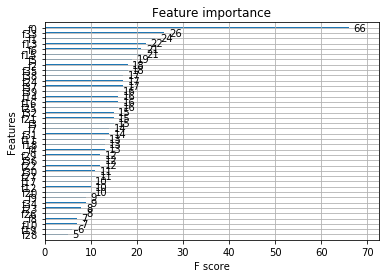

In [75]:
plot_importance(model)

In [243]:
df_best = pd.DataFrame()
for sub in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
    for lat in ["CON", "IPS"]:
        for loc in ["ECOG", "STN"]:
            for hem in ["RIGHT", "LEFT"]:
                df_extr = df[(df["sub"] == sub) & (df["lat"] == lat) & (df["loc"] == loc)]
                df_extr_cpy = df_extr.copy()
                for index, row in df_extr_cpy.iterrows():
                    if hem not in row["ch_"]:
                        df_extr = df_extr.drop(index)
                if df_extr.shape[0] != 0:
                    df_best = df_best.append(df_extr.loc[df_extr["r2"].argmax()], ignore_index=True)


C:\Users\ICN_admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  if sys.path[0] == '':


In [199]:
df_here = df_use[(df_use["loc"] == loc) & (df_use["lat"] == lat)]

In [200]:
df_here

,ch_,hem,importances,lat,loc,r2,sub
2,ECOG_RIGHT_1,RIGHT,"[0.03653162294258027, 0.41237287814943696, 0.0...",IPS,ECOG,0.541025,000
8,ECOG_RIGHT_24,RIGHT,"[0.06468990137932008, 0.08969085890133961, 0.1...",IPS,ECOG,0.285974,001
9,ECOG_LEFT_9,LEFT,"[0.07669206115396465, 0.1275869509370191, 0.48...",IPS,ECOG,0.342022,001
16,ECOG_RIGHT_5,RIGHT,"[0.011039153503734703, 0.050341835929518665, 0...",IPS,ECOG,0.412564,004
17,ECOG_LEFT_6,LEFT,"[0.013516138060629726, 0.03588068627708082, 0....",IPS,ECOG,0.488466,004
24,ECOG_RIGHT_0,RIGHT,"[0.07080330473885268, 0.07059934216535001, 0.1...",IPS,ECOG,0.000000,005
25,ECOG_LEFT_5,LEFT,"[0.04186379700604246, 0.14243417007892212, 0.2...",IPS,ECOG,0.149284,005
32,ECOG_RIGHT_30,RIGHT,"[0.035424144374781655, 0.06648368987976551, 0....",IPS,ECOG,0.056310,006
33,ECOG_LEFT_26,LEFT,"[0.012759312881685575, 0.03995853808085113, 0....",IPS,ECOG,0.600032,006
38,ECOG_LEFT_0,LEFT,"[0.08186207702180372, 0.1416732386172208, 0.18...",IPS,ECOG,0.150330,007


In [245]:
def get_arr_feature_per(df_use, loc="ECOG", lat="CON", importance_type="gain"):

    df_here = df_use[(df_use["loc"] == loc) & (df_use["lat"] == lat)]
    arr_best_importances = np.zeros([df_here.shape[0], 40])
    for idx, l_importances in enumerate(df_here.sort_values("r2", ascending=False)[importance_type]):
        try:
            arr_best_importances[idx,:] = l_importances
        except:
            # well, this is strange, sometimes features seem to be completely discareded 
            pass

    time_points = 5
    f_bands = 8
    arr_reshaped = np.zeros([arr_best_importances.shape[0], 8, 5])
    for t_out in range(arr_best_importances.shape[0]):
        for t_i in range(time_points):
            for f_idx, val in enumerate(arr_best_importances[t_out,f_bands*t_i:f_bands*t_i+8]): 
                arr_reshaped[t_out,f_idx,t_i] = val
    return arr_reshaped, arr_best_importances

In [260]:
def create_subplot(arr_reshaped):
    plt.imshow(arr_reshaped.mean(axis=0), aspect='auto')
    plt.gca().invert_yaxis()
    plt.colorbar()
    ax = plt.gca();
    ax.set_yticks(np.arange(0, 8, 1));
    ax.set_yticklabels([r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                             r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    ax.set_xticks(np.arange(0, 5, 1))
    ax.set_xticklabels(['0', '-100', '-200', '-300', '-400'], rotation=45)
    plt.xlabel("Time [ms]")
    plt.xlim(-0.5,4.5)
    plt.gca().invert_xaxis()

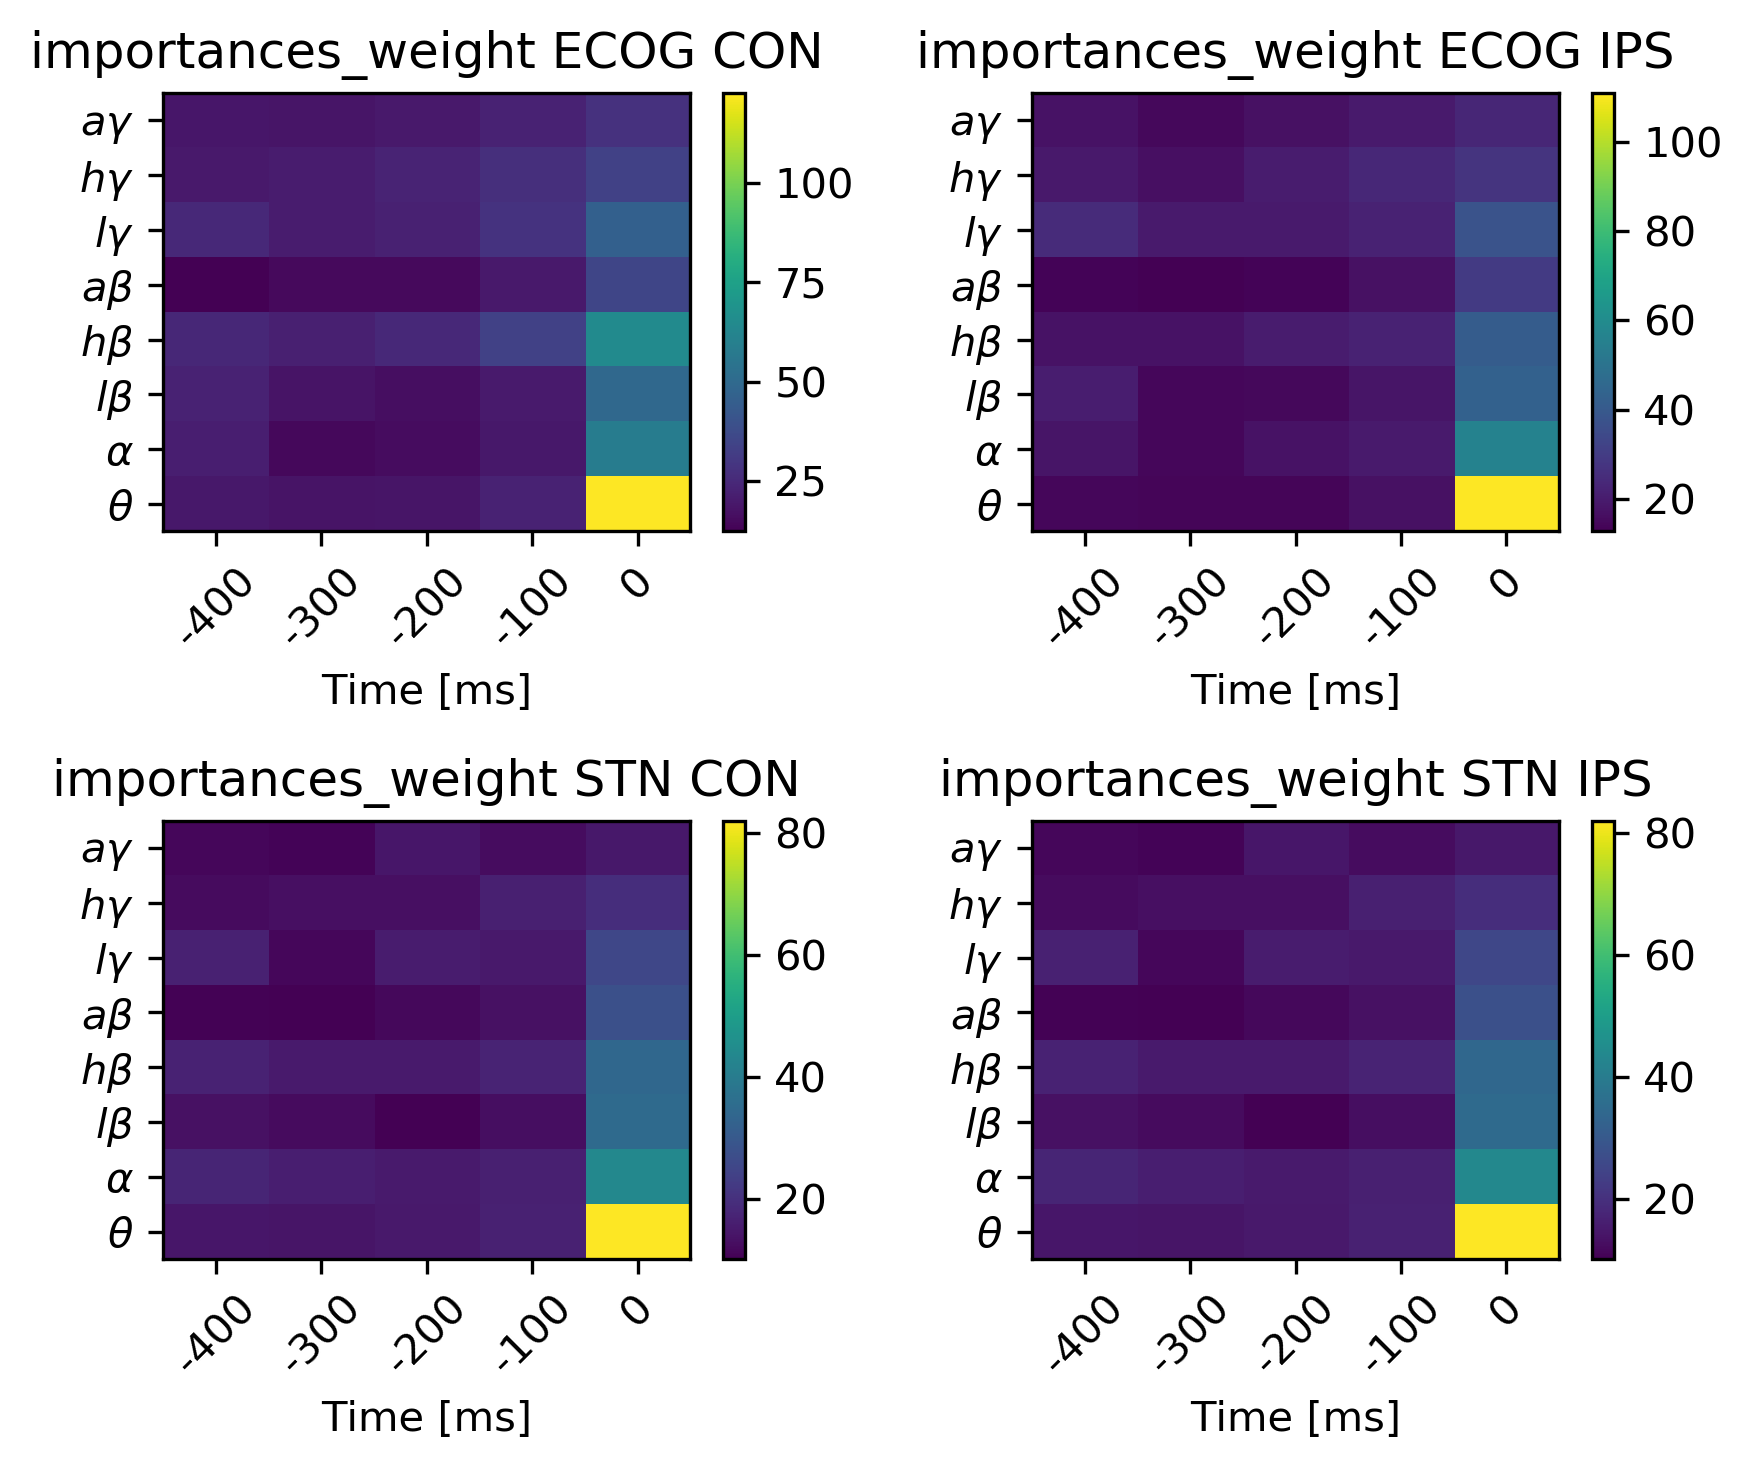

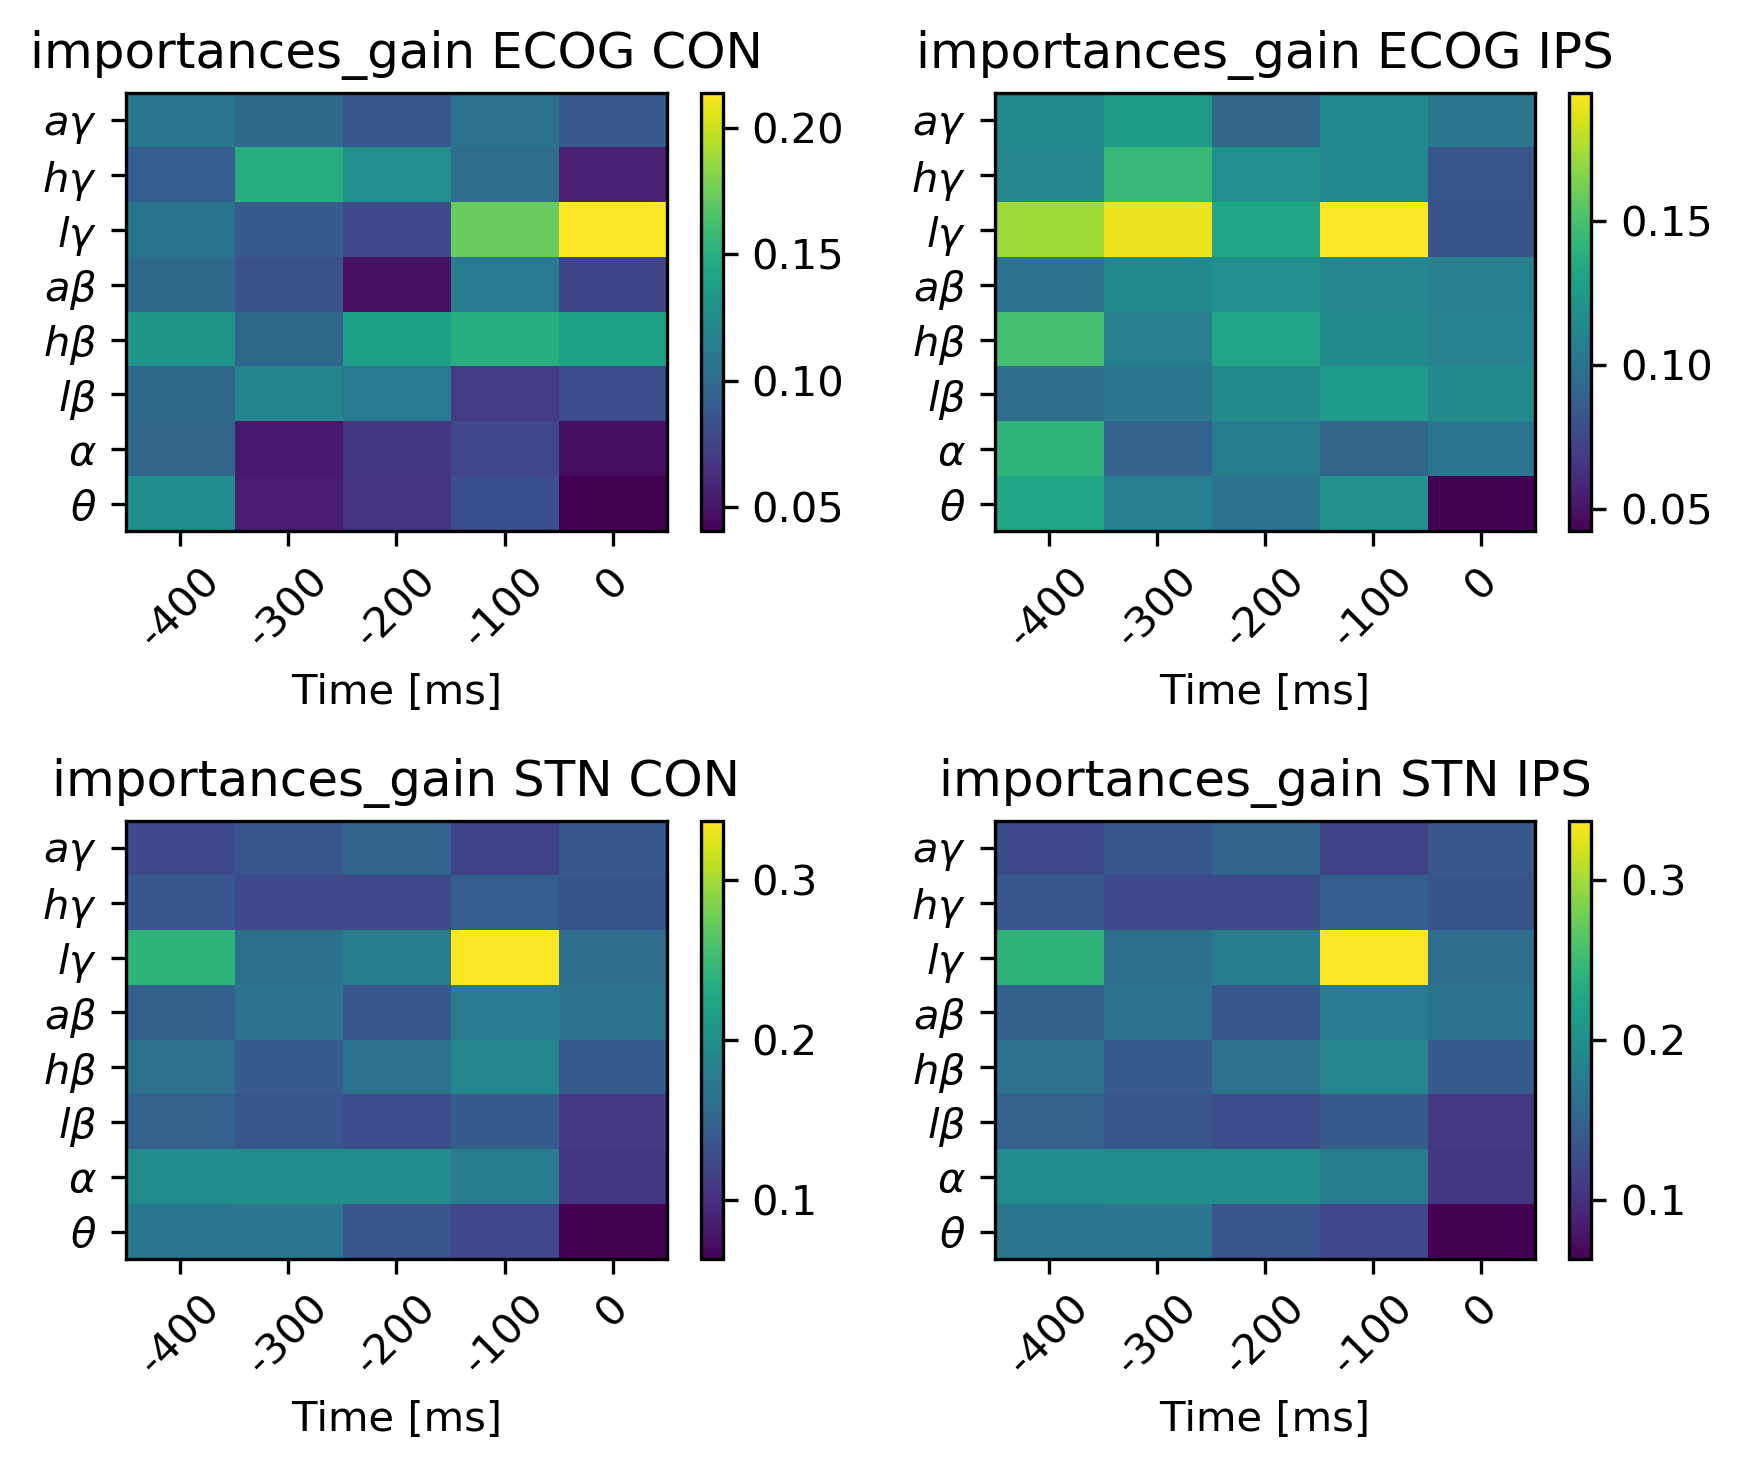

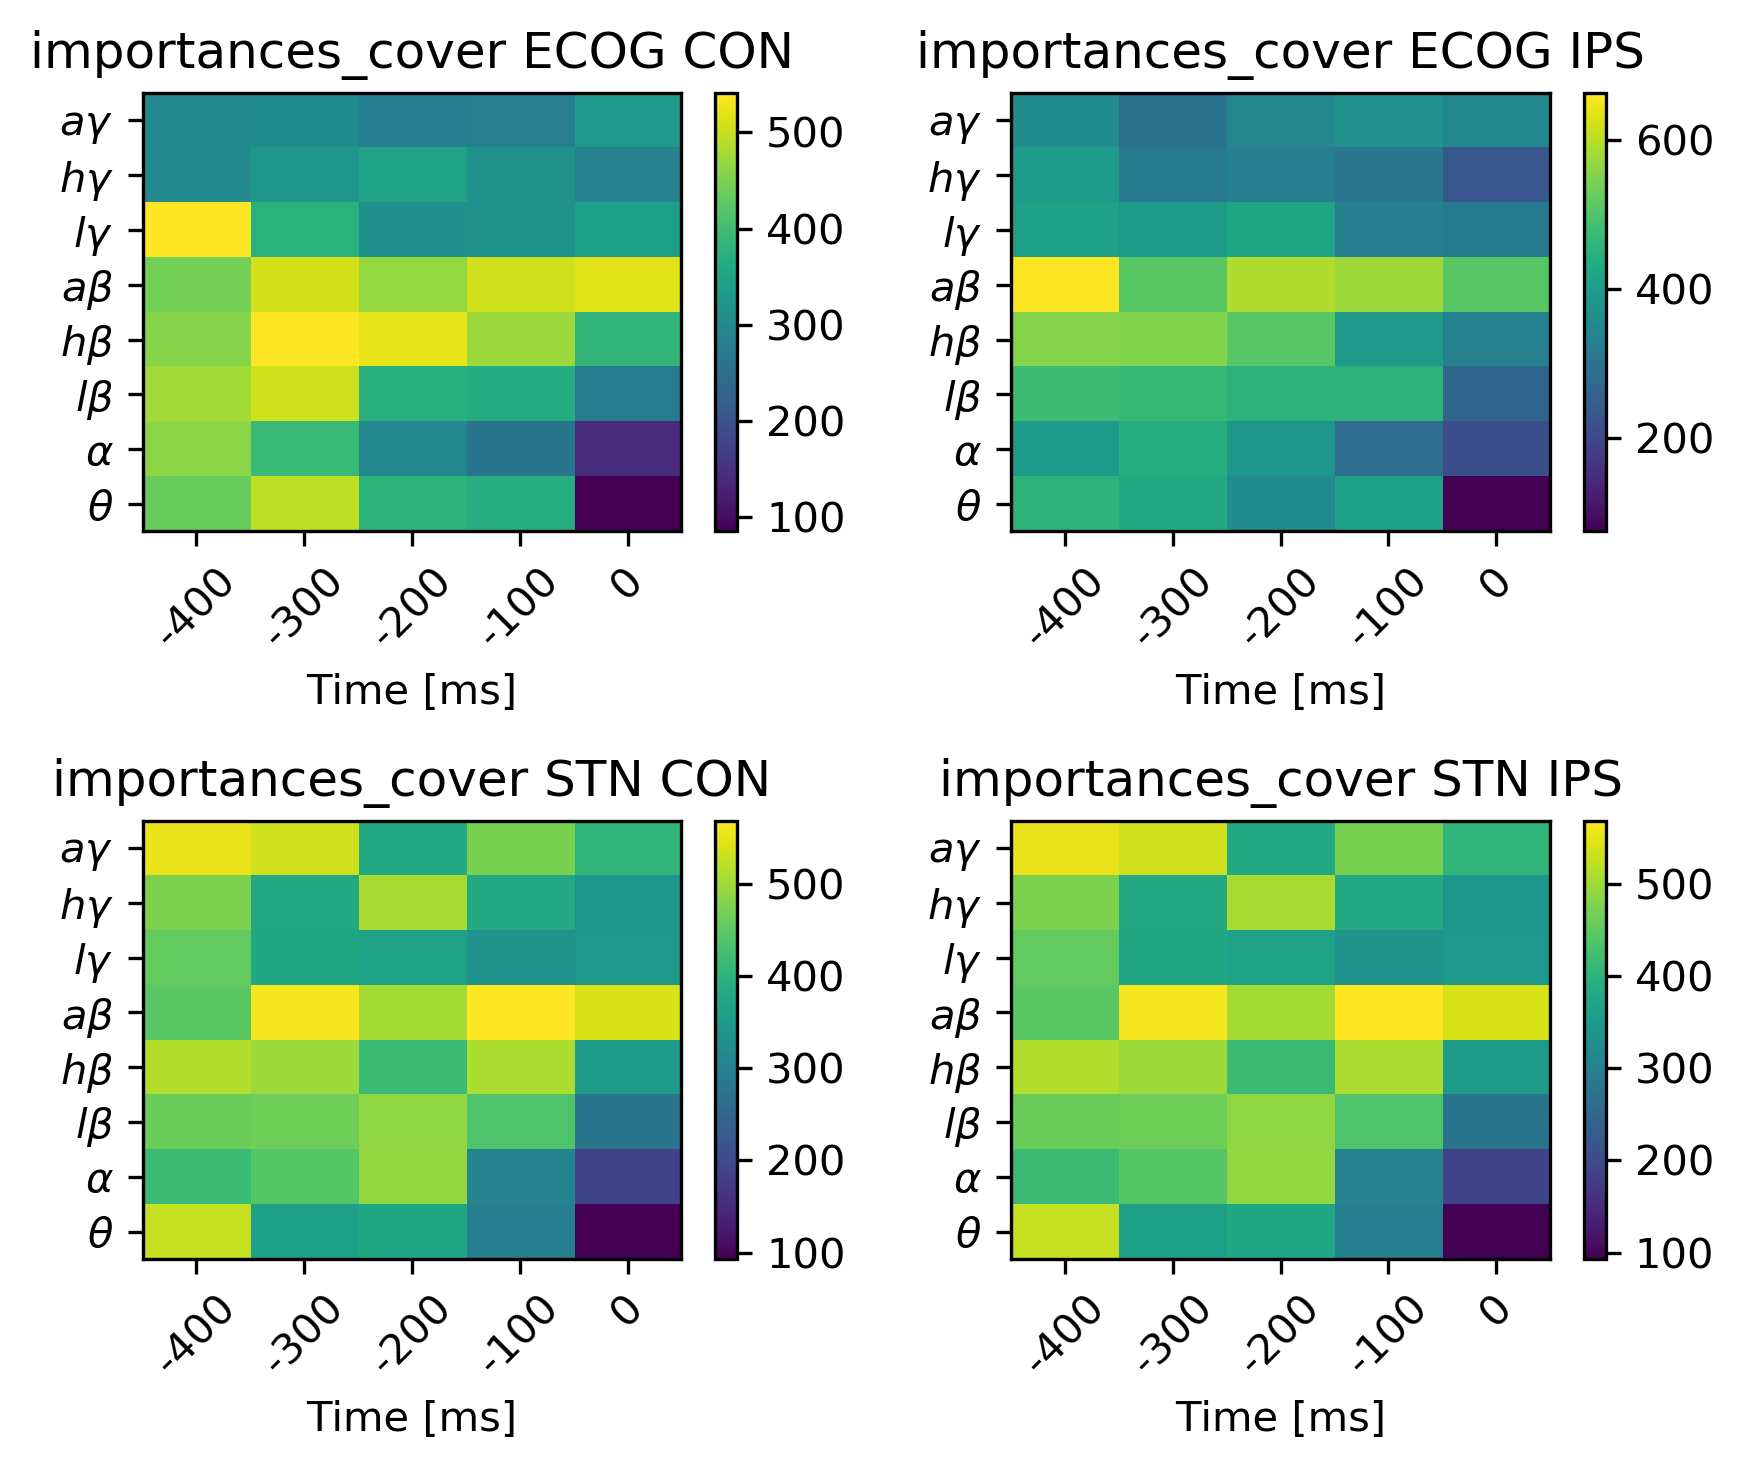

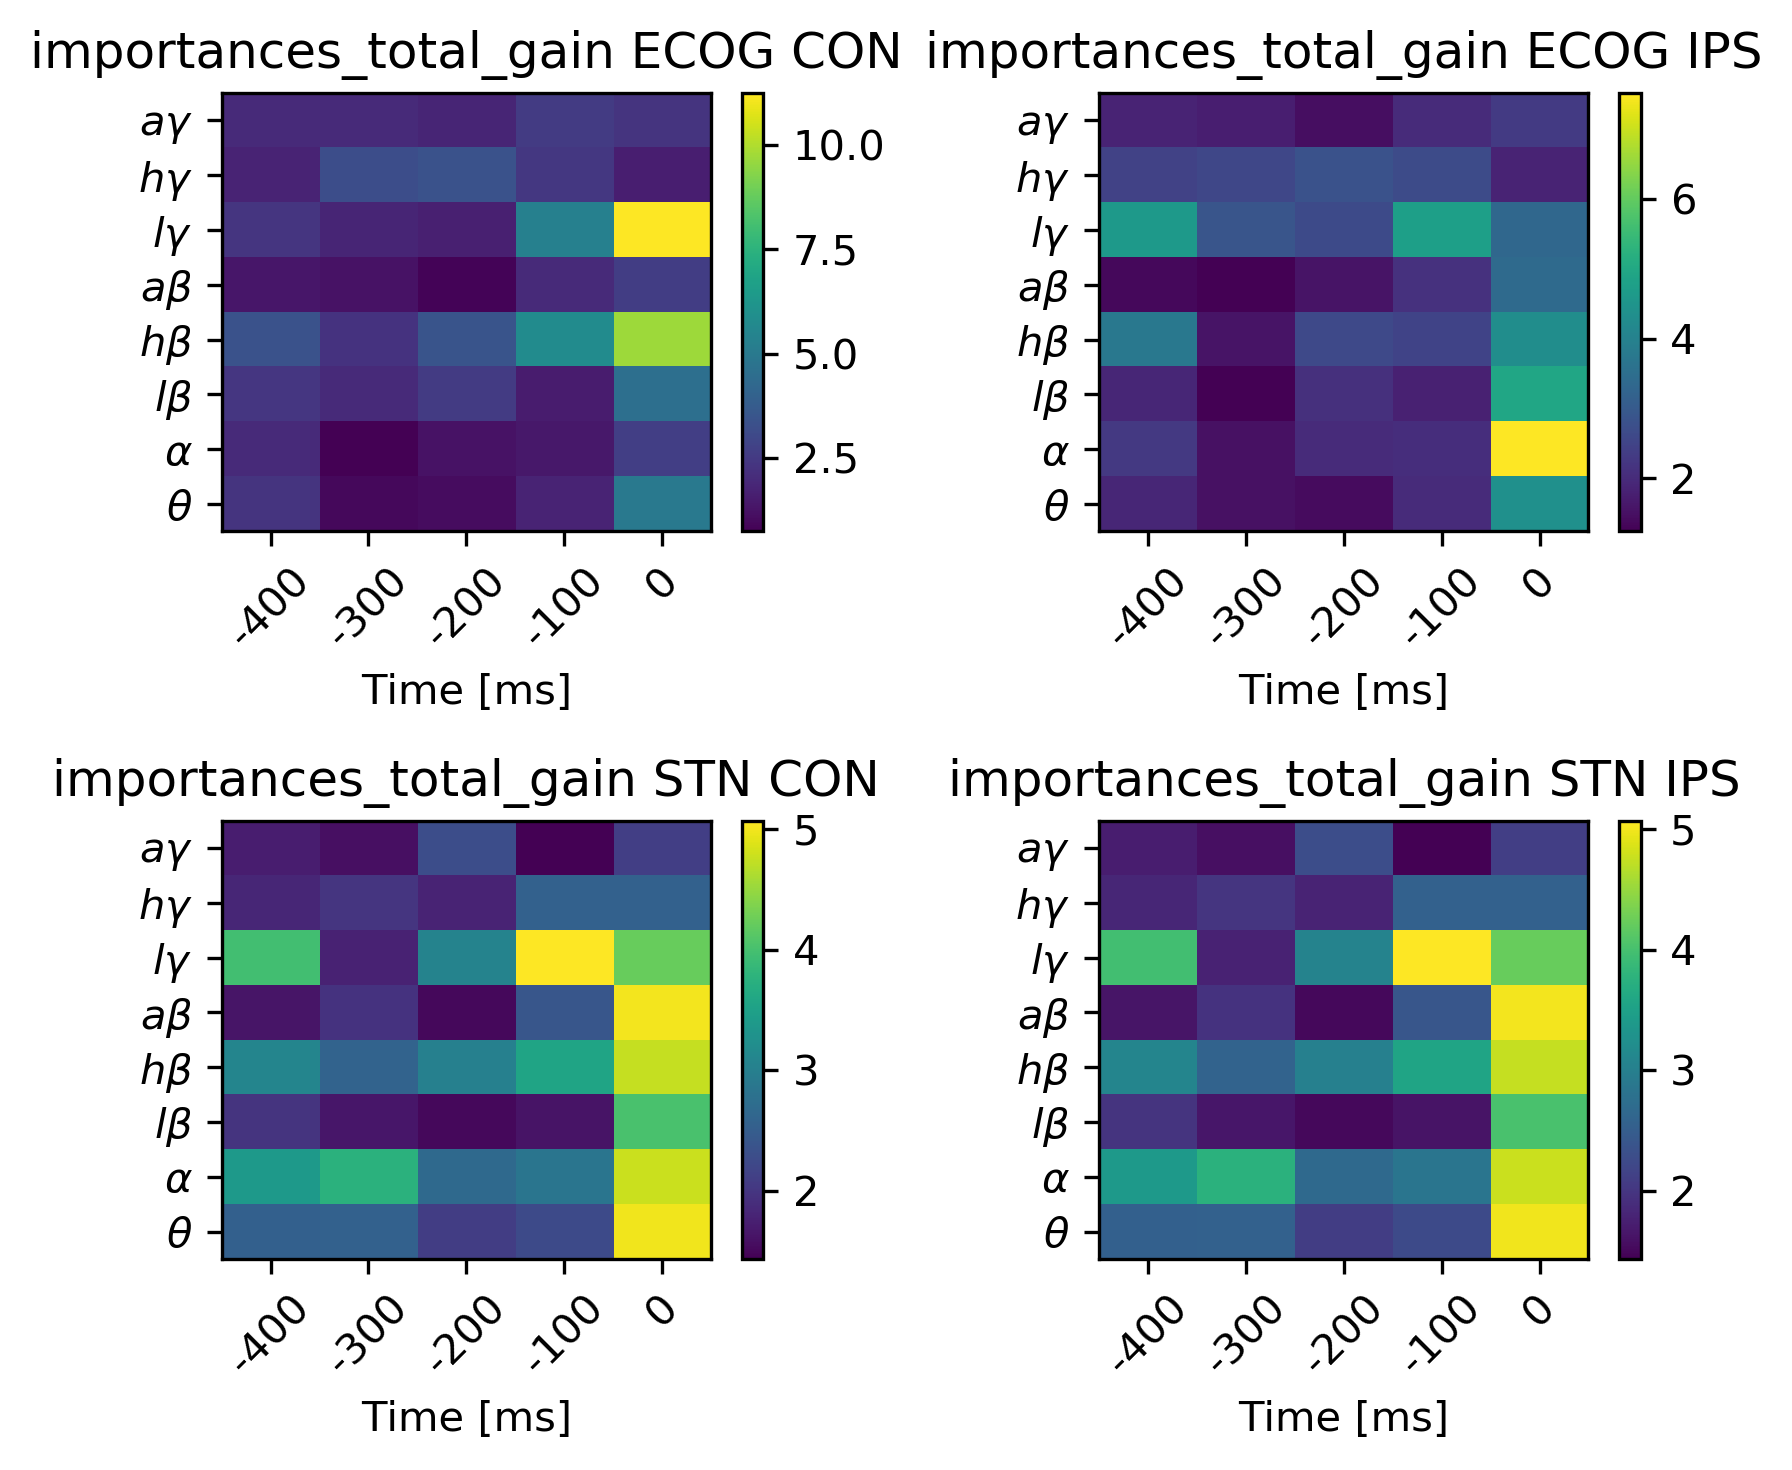

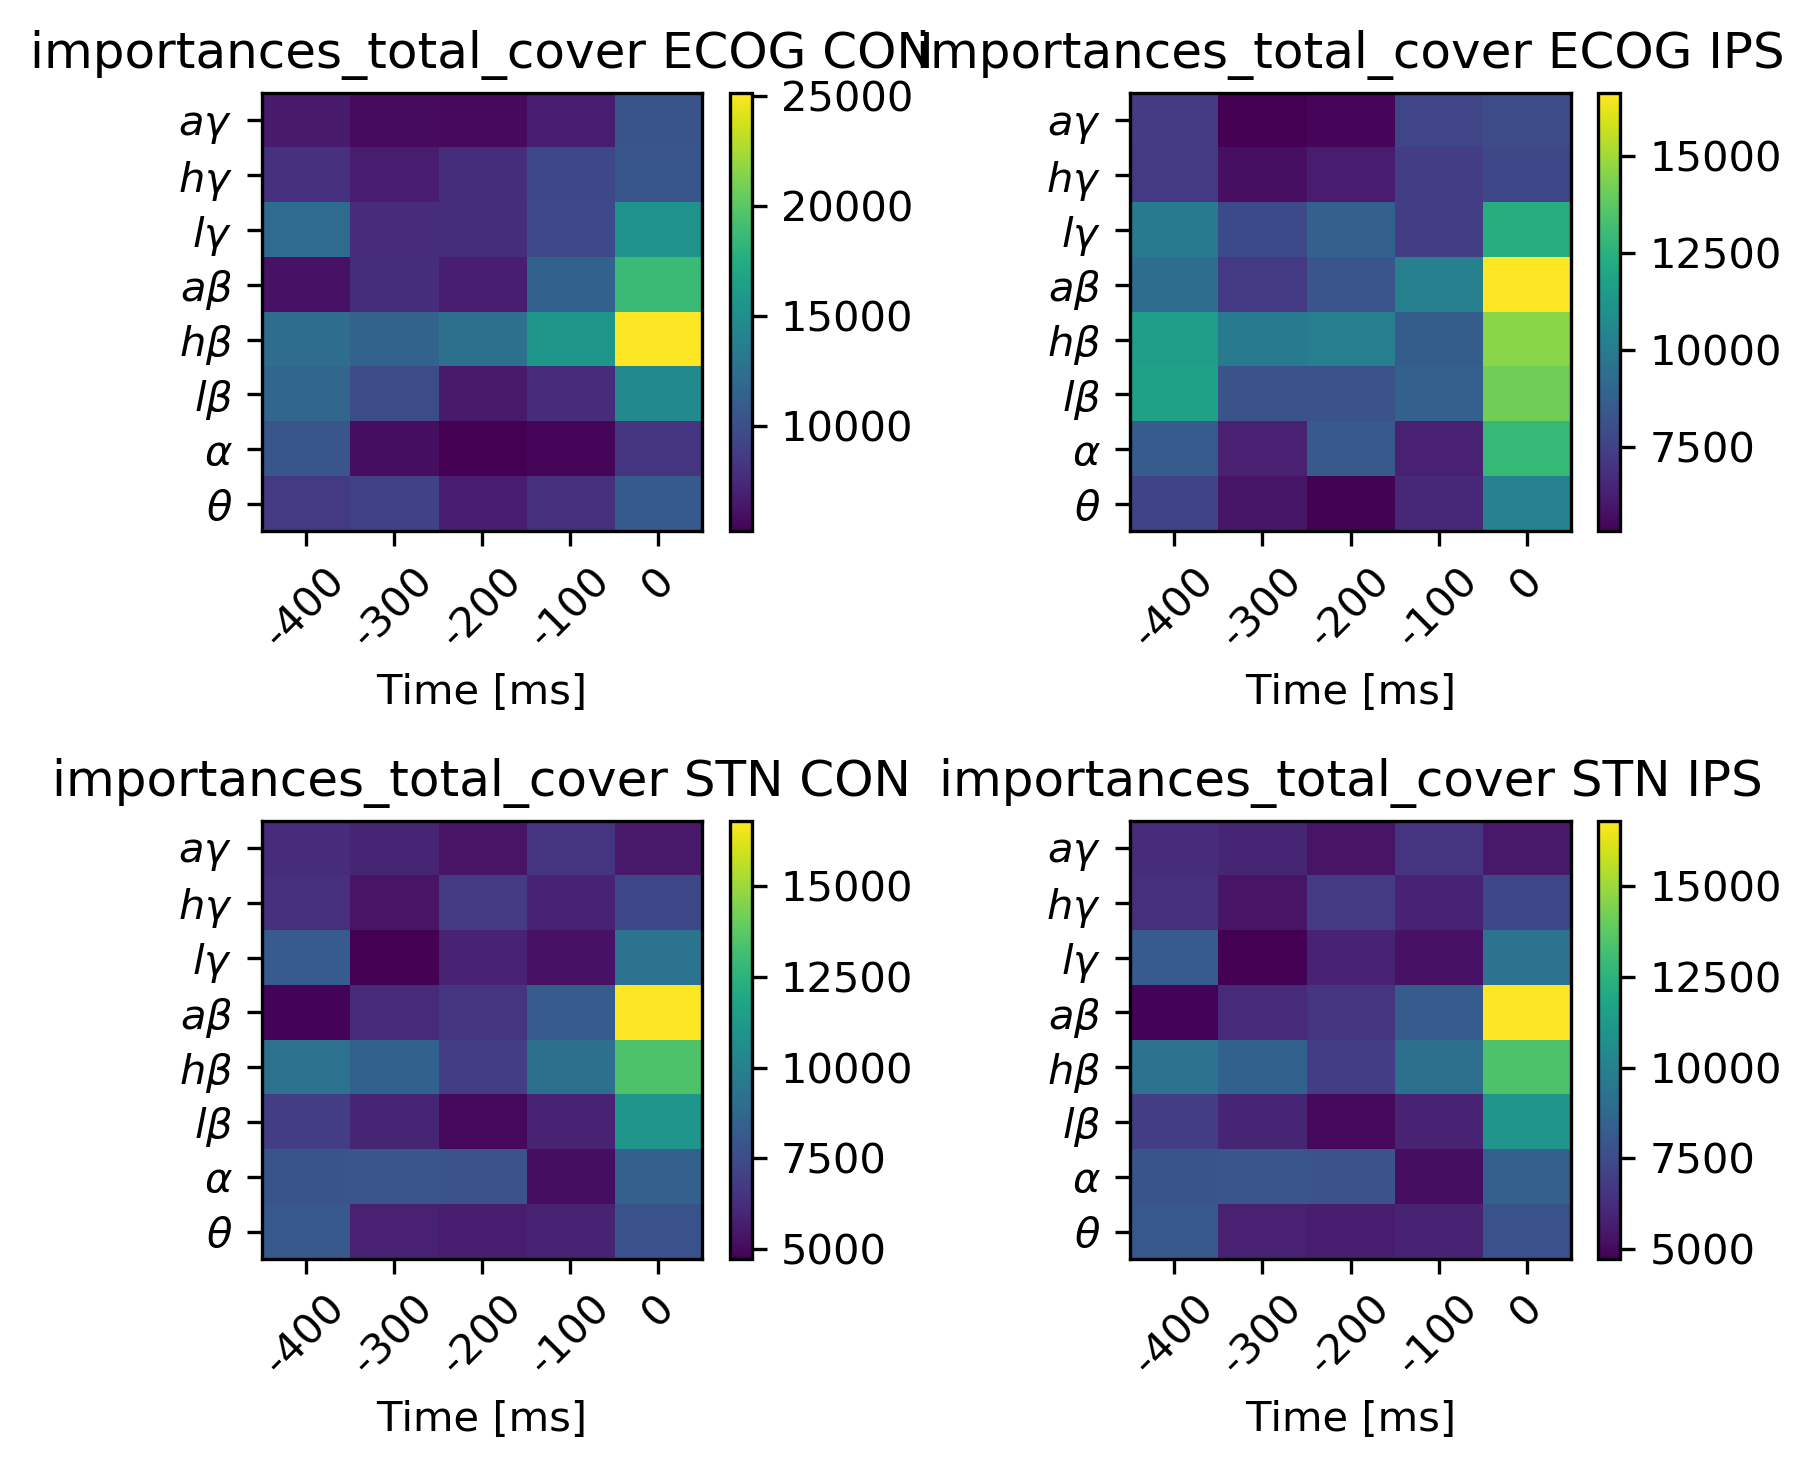

In [261]:
for importance_type in ["importances_weight", "importances_gain", "importances_cover", "importances_total_gain", "importances_total_cover"]:
    plt.figure(figsize=(6,5), dpi=300)
    plt.subplot(221)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="ECOG", lat="CON", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " ECOG CON")
    plt.subplot(222)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="ECOG", lat="IPS", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " ECOG IPS")
    plt.subplot(223)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="STN", lat="CON", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " STN CON")
    plt.subplot(224)
    arr_reshaped, _ = get_arr_feature_per(df_best, loc="STN", lat="CON", importance_type=importance_type)
    create_subplot(arr_reshaped)
    plt.title(importance_type+ " STN IPS")
    plt.tight_layout()

In [249]:
df.to_pickle("df_XGB_importances.p")

NameError: name 's_ECOG_CON' is not defined

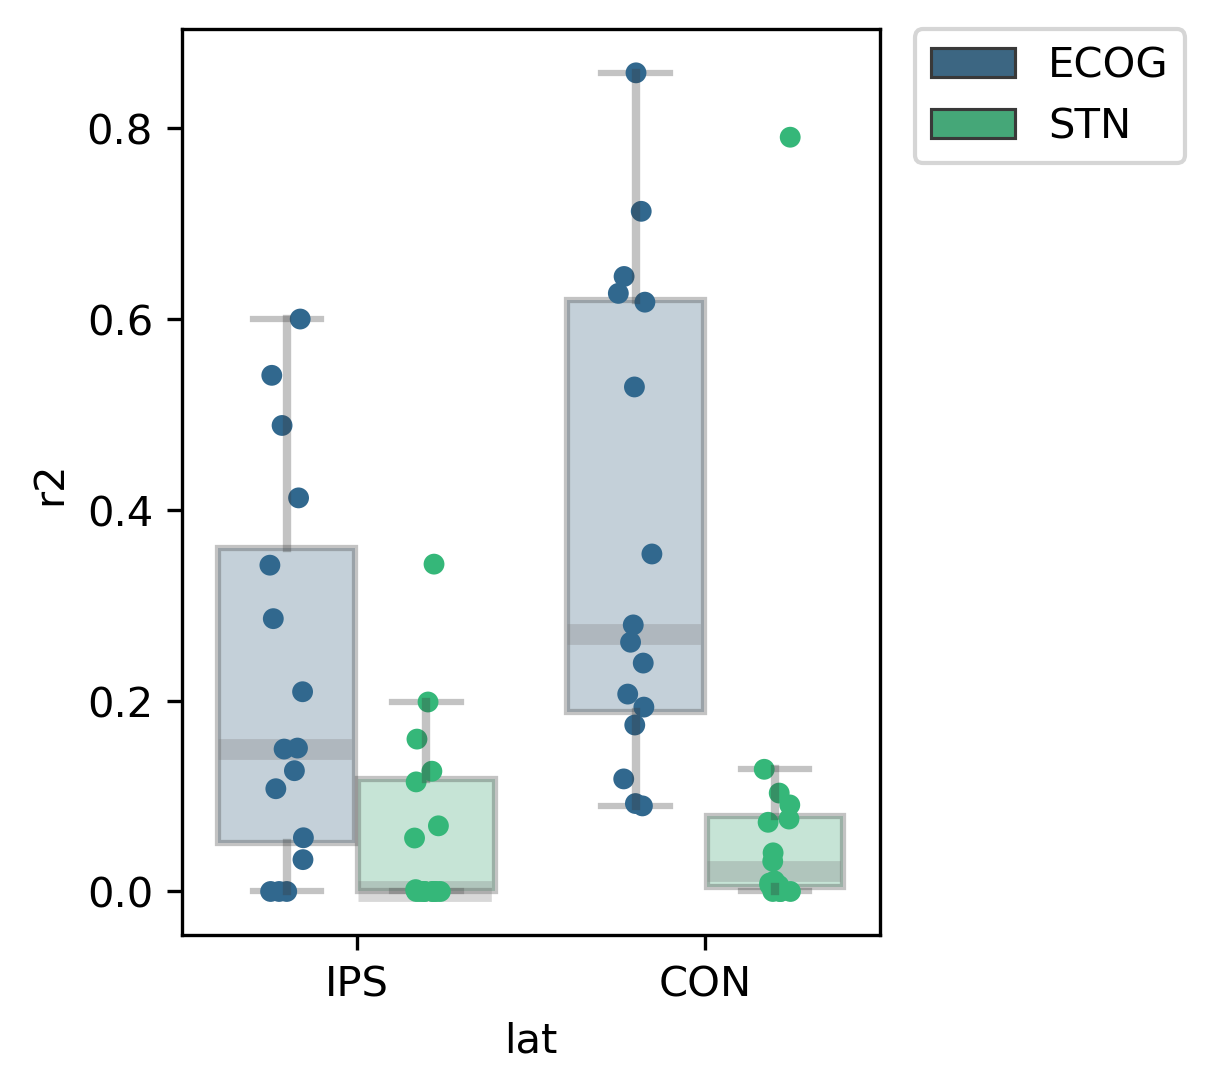

In [257]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], data=df_best,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], 
             data=df_best, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("XGB Cross Validation "+r"$R^2$"+" results\n"+
          "ECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS)


In [28]:
# COMBINATION ECOG
model = linear_model.LinearRegression()
df = pd.DataFrame()
time_stamps = 5

for ch_USED in ["ECOG", "STN","ECOG_STN"]:
    for f in range(len(os.listdir(PATH_))):
        sub_ = os.listdir(PATH_)[f][4:7]
        if sub_ not in ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']:
            continue
        print(sub_)
        with open(PATH_+ '\\'+ os.listdir(PATH_)[f], 'rb') as handle:
            run_ = pickle.load(handle)
            print(run_["ch_names"])
            if len([ch for ch in run_["ch_names"] if "STN" in ch]) == 0:
                continue
            print("PROCESS")
            X_ = []
            start = True
            for ch_idx, ch_ in enumerate([ch for ch in run_["ch_names"] if "MOV" not in ch]):
                if ch_USED == "ECOG" and "ECOG" not in ch_:
                    continue
                if ch_USED == "STN" and "STN" not in ch_:
                    continue
                #ECOG_STN combines all 
                X, y = append_time_dim(run_["rf_data_median"][:,ch_idx,:], \
                                       run_["label_baseline_corrected"][0,:], \
                                       time_stamps=time_stamps)
                if start == True:
                    X_ = X
                    start = False
                else:
                    X_ = np.concatenate((X_, X), axis=1)

            for label_idx, label in enumerate(run_["label_baseline_corrected"]):
                res_ = xgb.cv(xgb.XGBRegressor().get_params(), dtrain=xgb.DMatrix(X_, label=label[time_stamps:]), 
                              feval=evalerror, nfold=3).iloc[-1]["test-r2-mean"]
                
                if res_ < 0:
                    res_ = 0
                if run_["label_con_true"][label_idx] is True:
                    lat = "CON"
                else:
                    lat = "IPS"
                df = df.append({
                    "r2": res_,
                    "ch_": ch_,
                    "sub": sub_,
                    "loc": ch_USED,
                    "lat": lat
                }, ignore_index=True)


000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
000
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
001
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 

['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
006
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIG

001
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
001
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'ECOG_RIGHT_21', 'ECOG_RIGHT_22', 'ECOG_RIGHT_23', 'ECOG_RIGHT_24', 'ECOG_RIGHT_25', 'ECOG_RIGHT_26', 'ECOG_RIGHT_27', 'MOV_RIGHT', 'MOV_LEFT']
004
['ST

010
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
010
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
013
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
013
['ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RIGHT', 'MOV_LEFT']
014
['STN_RIGHT_0', 'STN_RIGHT_1', 'STN_RIGHT_2', 'ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'MOV_RI

006
['STN_LEFT_0', 'STN_LEFT_1', 'STN_LEFT_2', 'ECOG_LEFT_0', 'ECOG_LEFT_1', 'ECOG_LEFT_2', 'ECOG_LEFT_3', 'ECOG_LEFT_4', 'ECOG_LEFT_5', 'ECOG_LEFT_6', 'ECOG_LEFT_7', 'ECOG_LEFT_8', 'ECOG_LEFT_9', 'ECOG_LEFT_10', 'ECOG_LEFT_11', 'ECOG_LEFT_12', 'ECOG_LEFT_13', 'ECOG_LEFT_14', 'ECOG_LEFT_15', 'ECOG_LEFT_16', 'ECOG_LEFT_17', 'ECOG_LEFT_18', 'ECOG_LEFT_19', 'ECOG_LEFT_20', 'ECOG_LEFT_21', 'ECOG_LEFT_22', 'ECOG_LEFT_23', 'ECOG_LEFT_24', 'ECOG_LEFT_25', 'ECOG_LEFT_26', 'ECOG_LEFT_27', 'ECOG_LEFT_28', 'ECOG_LEFT_29', 'ECOG_LEFT_30', 'ECOG_LEFT_31', 'ECOG_LEFT_32', 'ECOG_LEFT_33', 'ECOG_LEFT_34', 'ECOG_LEFT_35', 'MOV_RIGHT', 'MOV_LEFT']
PROCESS
006
['ECOG_RIGHT_0', 'ECOG_RIGHT_1', 'ECOG_RIGHT_2', 'ECOG_RIGHT_3', 'ECOG_RIGHT_4', 'ECOG_RIGHT_5', 'ECOG_RIGHT_6', 'ECOG_RIGHT_7', 'ECOG_RIGHT_8', 'ECOG_RIGHT_9', 'ECOG_RIGHT_10', 'ECOG_RIGHT_11', 'ECOG_RIGHT_12', 'ECOG_RIGHT_13', 'ECOG_RIGHT_14', 'ECOG_RIGHT_15', 'ECOG_RIGHT_16', 'ECOG_RIGHT_17', 'ECOG_RIGHT_18', 'ECOG_RIGHT_19', 'ECOG_RIGHT_20', 'E

In [45]:
df_best = pd.read_pickle("XGB_best_ECOGSTN_samesize.p")

In [52]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"]

0     0.811594
4     0.591416
5     0.609079
12    0.278797
13    0.118298
20    0.106521
21    0.338424
28    0.561382
29    0.503900
36    0.117641
40    0.469334
44    0.050412
48    0.122537
49    0.270217
56    0.217977
60    0.236155
Name: r2, dtype: float64

In [49]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].mean()

0.3377301875

In [50]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].std()

0.22643373944468445

In [51]:
df_best[(df_best["lat"] == "CON") & (df_best["loc"] == "ECOG")]["r2"].median()

0.27450683333333337

In [40]:
s_ECOG_CON = str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG")]["r2"].std(),2))
s_ECOG_IPS = str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG")]["r2"].std(),2))
s_STN_CON = str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "STN")]["r2"].std(),2))
s_STN_IPS = str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "STN")]["r2"].std(),2)) 
s_ECOGSTN_CON = str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG_STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "CON") & (df["loc"] == "ECOG_STN")]["r2"].std(),2))
s_ECOGSTN_IPS = str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG_STN")]["r2"].mean(), 2))+\
                 r"$\pm$"+str(np.round(df[(df["lat"] == "IPS") & (df["loc"] == "ECOG_STN")]["r2"].std(),2))           

In [38]:
s_ECOGSTN_CON

'0.4$\\pm$0.18'

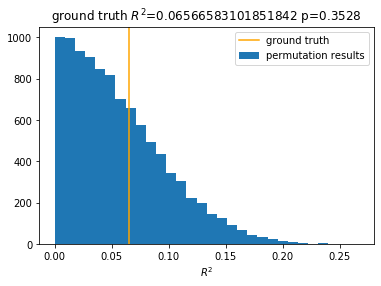

(0.06566583101851842, 0.3528)

In [21]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="CON") & (df_best["loc"] == "ECOG")]["r2"],
                                    df[(df["lat"]=="CON") & (df["loc"] == "ECOG")]["r2"], True,
                                    r"$R^2$", 10000)

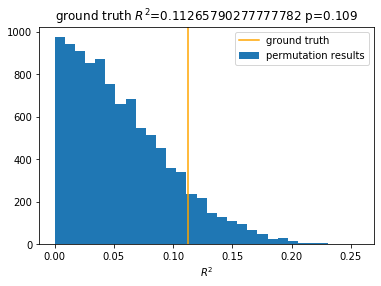

(0.11265790277777782, 0.109)

In [22]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "ECOG")]["r2"],
                                    df[(df["lat"]=="IPS") & (df["loc"] == "ECOG")]["r2"], True,
                                    r"$R^2$", 10000)

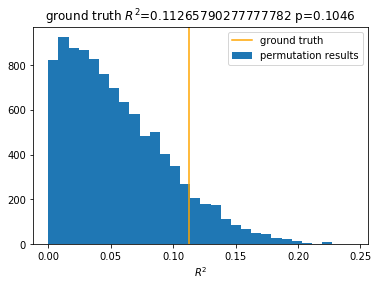

(0.11265790277777782, 0.1046)

In [23]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "ECOG")]["r2"],
                                    df[(df["lat"]=="IPS") & (df["loc"] == "ECOG_STN")]["r2"], True,
                                    r"$R^2$", 10000)

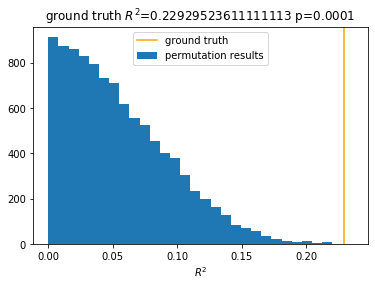

(0.22929523611111113, 0.0001)

In [24]:
icn_permutation_test.permutationTest(df_best[(df_best["lat"]=="IPS") & (df_best["loc"] == "STN")]["r2"],
                                    df[(df["lat"]=="IPS") & (df["loc"] == "STN")]["r2"], True,
                                    r"$R^2$", 10000)

Text(0.5, 1.0, 'XGB Cross Validation $R^2$ results\nECOG con: 0.34$\\pm$0.23 ips: 0.19$\\pm$0.2\nSTN con: 0.1$\\pm$0.17 ips: 0.03$\\pm$0.1\nECOG_STN con: 0.4$\\pm$0.18 ips: 0.31$\\pm$0.2')

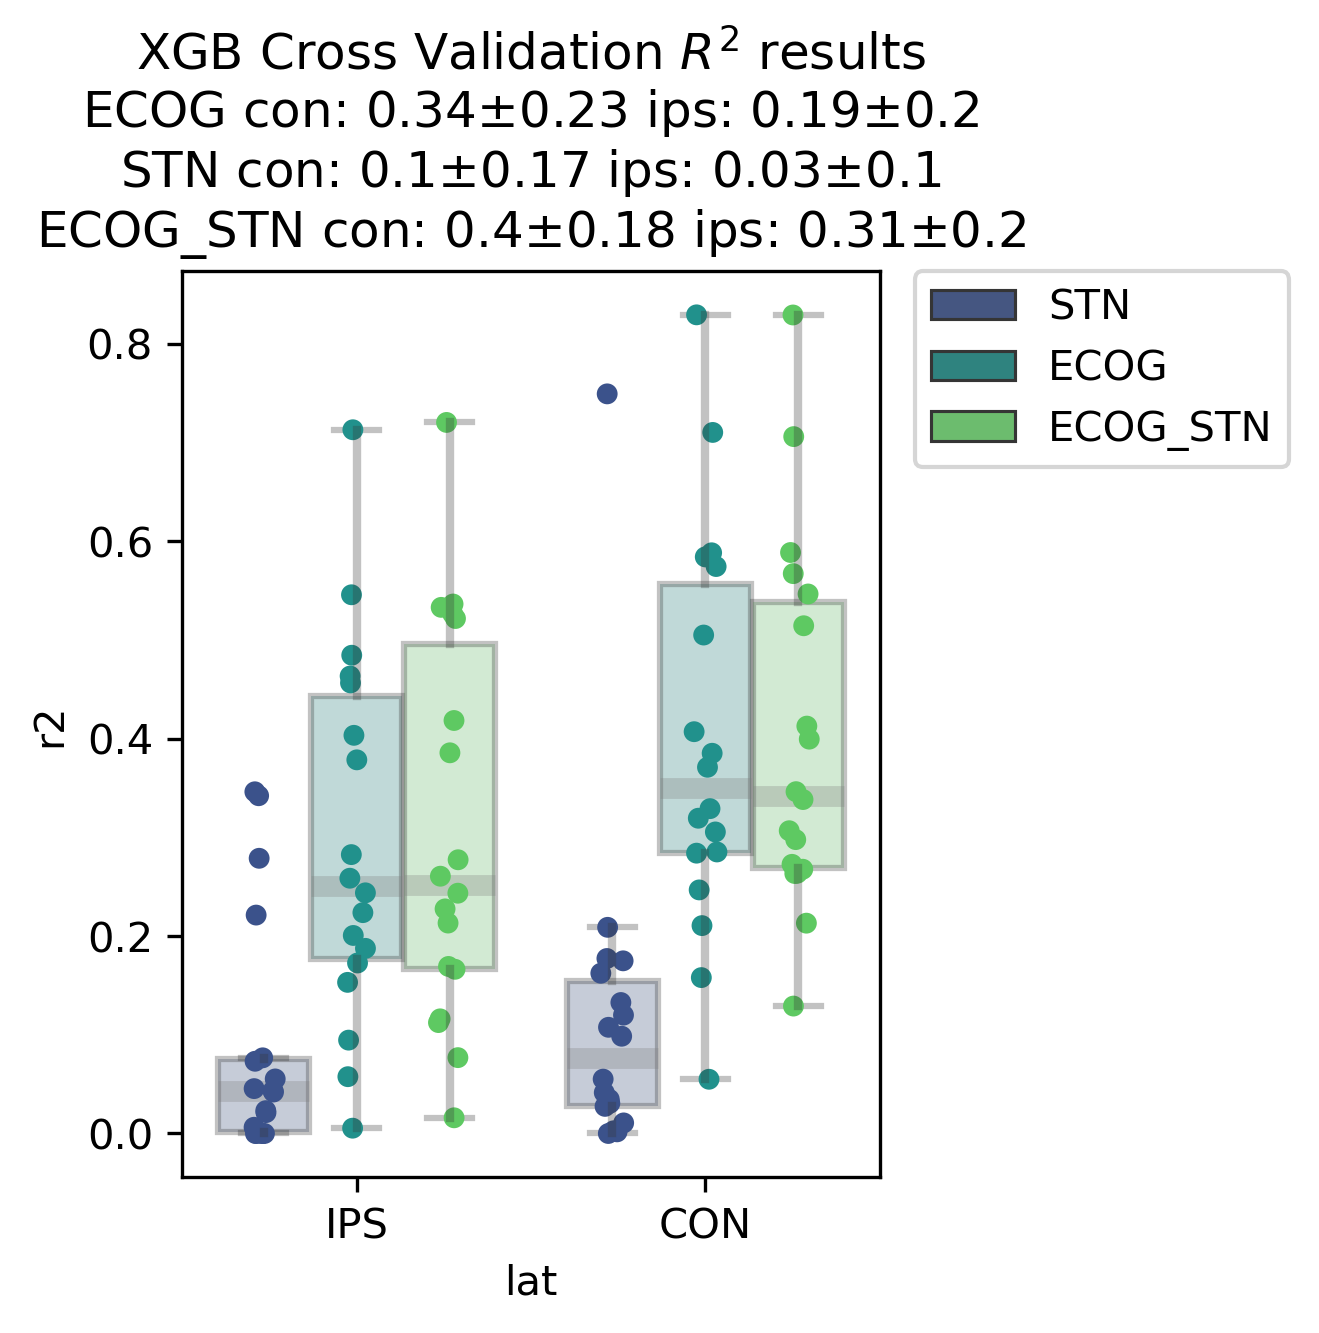

In [54]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"],
             data=df, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("XGB Cross Validation "+r"$R^2$"+" results\n"+
         "ECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS+\
         "\nECOG_STN con: "+s_ECOGSTN_CON+ " ips: "+s_ECOGSTN_IPS)


Text(0.5, 1.0, 'XGB Cross Validation $R^2$ results\nECOG con: 0.34$\\pm$0.23 ips: 0.19$\\pm$0.2\nSTN con: 0.1$\\pm$0.17 ips: 0.03$\\pm$0.1\nECOG_STN con: 0.4$\\pm$0.18 ips: 0.31$\\pm$0.2')

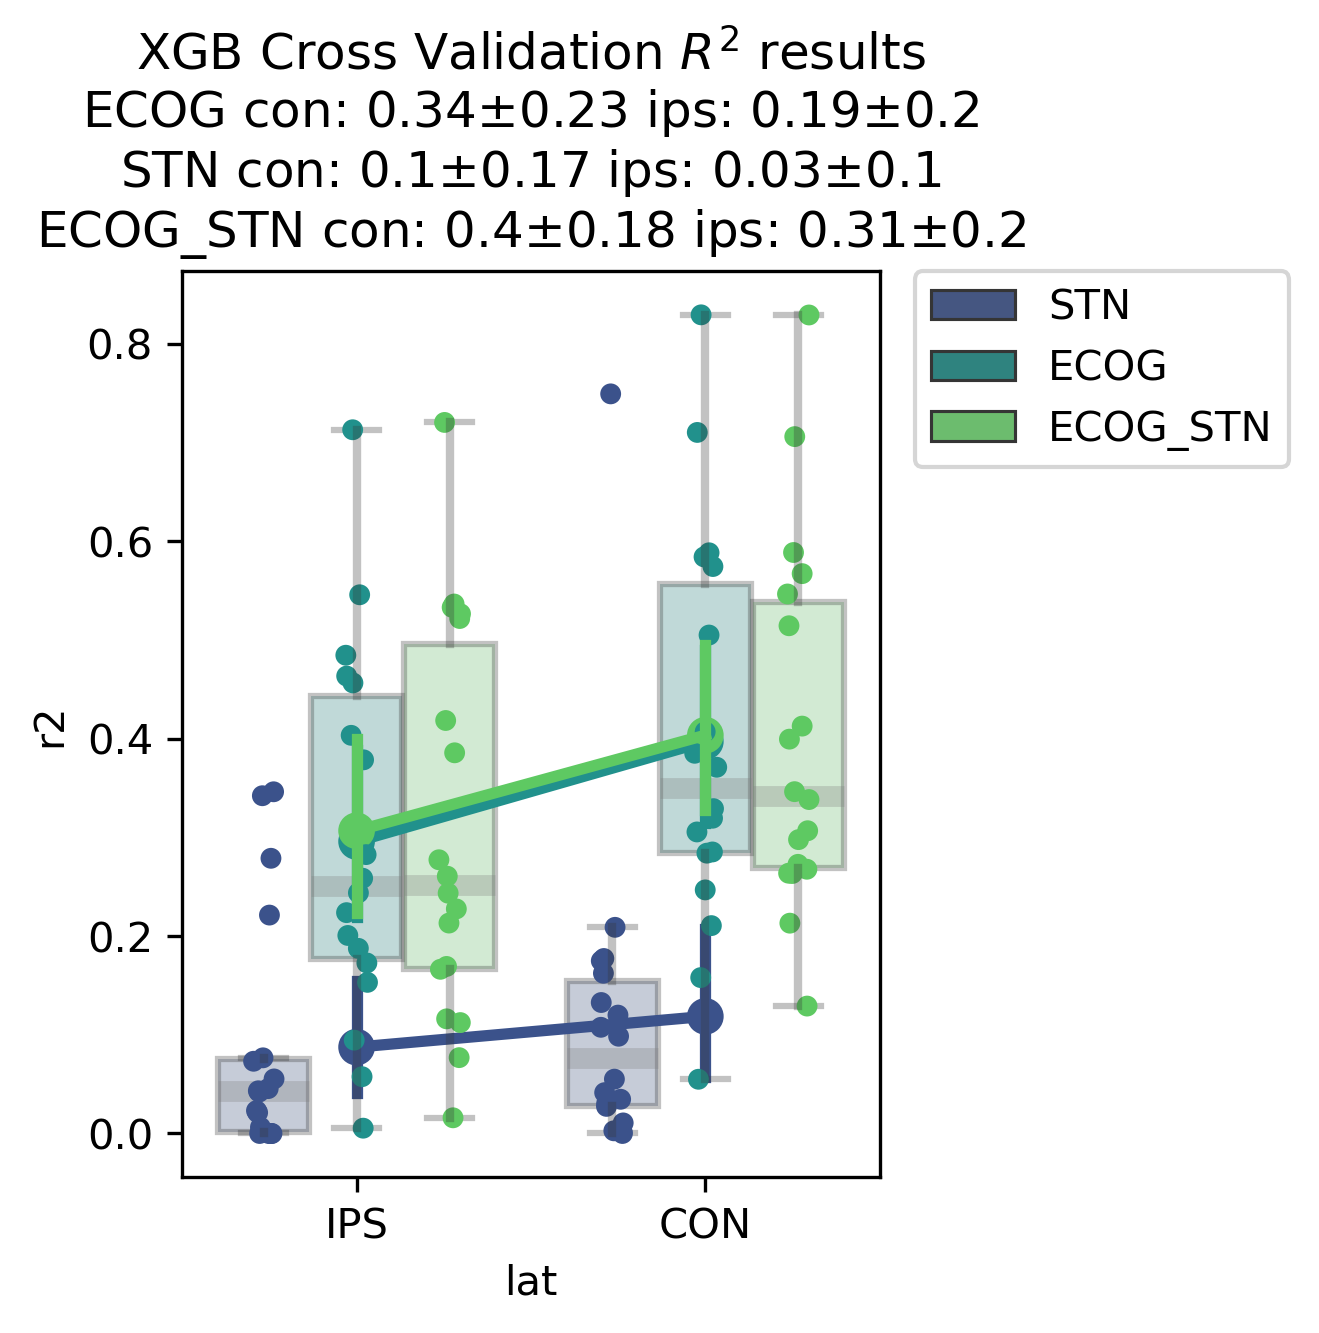

In [60]:
alpha_box = 0.3
plt.figure(figsize=(3,4), dpi=300)
sb.boxplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))

sb.pointplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", alpha=alpha_box)
    
ax = sb.stripplot(x="lat", y="r2", hue="loc", order=["IPS", "CON"], hue_order=["STN", "ECOG", "ECOG_STN"],
             data=df, palette="viridis", dodge=True, s=5)
#plt.xticks(rotation=90)

# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("XGB Cross Validation "+r"$R^2$"+" results\n"+
         "ECOG con: "+s_ECOG_CON+ " ips: "+s_ECOG_IPS+\
         "\nSTN con: "+s_STN_CON+ " ips: "+s_STN_IPS+\
         "\nECOG_STN con: "+s_ECOGSTN_CON+ " ips: "+s_ECOGSTN_IPS)


Text(0.5, 1.0, 'XGB Performance comparison for combined channels')

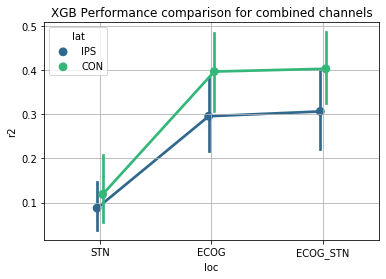

In [82]:
sb.pointplot(x ="loc", y="r2", hue="lat", hue_order=["IPS", "CON"], 
           order=["STN", "ECOG", "ECOG_STN"], data=df,
           palette="viridis", alpha=0.3, dodge=True)
plt.grid(True)
plt.title("XGB Performance comparison for combined channels")

In [70]:
sb.pointplot?

In [57]:
df[(df["loc"] == "ECOG") & (df["lat"] == "CON")]

,ch_,lat,loc,r2,sub
1,ECOG_RIGHT_5,CON,ECOG,0.829167,000
2,ECOG_LEFT_27,CON,ECOG,0.710066,001
5,ECOG_RIGHT_27,CON,ECOG,0.583997,001
6,ECOG_LEFT_7,CON,ECOG,0.246710,004
9,ECOG_RIGHT_7,CON,ECOG,0.370936,004
10,ECOG_LEFT_7,CON,ECOG,0.385104,005
13,ECOG_RIGHT_7,CON,ECOG,0.157897,005
14,ECOG_LEFT_34,CON,ECOG,0.329030,006
16,ECOG_LEFT_35,CON,ECOG,0.504857,006
18,ECOG_LEFT_35,CON,ECOG,0.574244,006
